# 프로젝트: 더 멋진 번역기 만들기

라이브러리 버전을 확인해 봅니다.

In [1]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.9.0
1.22.4
3.6.0


## Step 1. 데이터 다운로드 (클라우드 유저용)
아래 링크에서 korean-english-park.train.tar.gz 를 사용할 예정입니다. 다운로드할 필요는 없습니다.

- jungyeul/korean-parallel-corpora

클라우드 환경에서는 위 데이터를 미리 준비해 놓았으니 연결만 시켜줍시다. 우측 하단의 Cloud shell을 열어주세요.
아래와 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성해 주시면 됩니다.

## Step 2. 데이터 정제 및 토큰화

In [2]:
import os, re

### 1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # 병렬 쌍을 유지하며 중복 제거
    combined = set(zip(kor, eng))
    cleaned_corpus = list(combined)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [4]:
cleaned_corpus[0]

('용량이 좀 더 늘어난다면 영상물 공급업자들은 한 디스크 안에 동일한 영화의 여러 버전을 저장할 수 있을 것이다.',
 'With even more space, content providers could store multiple versions of the same film on a disc.')

### 2. 정제 함수를 아래 조건을 만족하게 정의하세요.
> - 모든 입력을 소문자로 변환합니다.
> - 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
> - 문장부호 양옆에 공백을 추가합니다.
> - 문장 앞뒤의 불필요한 공백을 제거합니다.

In [5]:
def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환
    sentence = sentence.lower()
    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) 
    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 문장 앞뒤의 불필요한 공백을 제거
    sentence = sentence.strip()
    
    # 추가) 문장 앞 문장부호 있으면 제거
    sentence = sentence.lstrip('.?!, ')
    # 추가) 다중 공백 제거
    sentence = ' '.join(sentence.split())
    return sentence

### 3. 
한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

- google/sentencepiece

> - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
> - 학습 후 저장된 `model` 파일을 `SentencePieceProcessor()` 클래스에 `Load()`한 후 반환합니다.
> - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
>    `<PAD>` : 0 / `<BOS>` : 1 / `<EOS>` : 2 / `<UNK>` : 3

In [6]:
import os
import sentencepiece as spm

In [7]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    temp_file = f"{lang}_corpus.txt"

    with open(temp_file, 'w', encoding='utf-8') as f:
        for line in corpus:
            f.write(line + "\n")
            
    # 모델 학습
    spm.SentencePieceTrainer.train(
        input=temp_file,
        model_prefix=f"{lang}_tokenizer",
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{lang}_tokenizer.model")
    
    os.remove(temp_file)
    
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  esc

True

### 4.
토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [8]:
import tensorflow as tf
import numpy as np

In [9]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

import matplotlib.pyplot as plt

### 토큰 확인

In [10]:
kor_corpus[0]

'용량이 좀 더 늘어난다면 영상물 공급업자들은 한 디스크 안에 동일한 영화의 여러 버전을 저장할 수 있을 것이다 .'

In [11]:
np.unique([l for l in kor_corpus if len(l) <= 1])

array(['', 'q'], dtype='<U1')

In [12]:
eng_corpus[0]

'with even more space , content providers could store multiple versions of the same film on a disc .'

In [13]:
np.unique([l for l in eng_corpus if len(l) <= 2])

array([''], dtype='<U1')

In [14]:
kor_tokens = [ko_tokenizer.encode(x, out_type=int) for x in tqdm(kor_corpus)]
eng_tokens = [en_tokenizer.encode(x, out_type=int) for x in tqdm(eng_corpus)]

  0%|          | 0/78968 [00:00<?, ?it/s]

  0%|          | 0/78968 [00:00<?, ?it/s]

In [15]:
np.unique([l for l in eng_corpus if len(l) < 5])

array(['', 'cobb', 'eggs', 'food', 'men'], dtype='<U4')

In [16]:
max_len = 50

In [17]:
def get_token_len(token_list, max_tokens=None, hist=False):
    num_tokens = [len(tokens) for tokens in token_list]
    num_tokens = np.array(num_tokens)

    # 평균값, 최댓값, 표준편차
    print(f"토큰 길이 평균: {np.mean(num_tokens)}")
    print(f"토큰 길이 최소: {np.min(num_tokens)}")
    print(f"토큰 길이 최대: {np.max(num_tokens)}")
    print(f"토큰 길이 표준편차: {np.std(num_tokens)}")
    
    if max_tokens==None:
        max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print(f'설정 최대 길이: {maxlen}')
    ratio = np.sum(num_tokens < max_tokens) / len(num_tokens) * 100
    print(f'전체 문장의 {round(ratio, 1)}%가 설정값인 {maxlen}에 포함됩니다.')
    
    if hist:
        plt.hist(num_tokens, bins=50)
        plt.axvline(maxlen, color='r', linestyle='dashed', linewidth=1)
        plt.xlabel('length of samples')
        plt.ylabel('number of samples')
        plt.title('Distribution of token lengths')
        plt.show();

토큰 길이 평균: 25.368060480194508
토큰 길이 최소: 0
토큰 길이 최대: 132
토큰 길이 표준편차: 11.005651771319513
설정 최대 길이: 50
전체 문장의 97.4%가 설정값인 50에 포함됩니다.


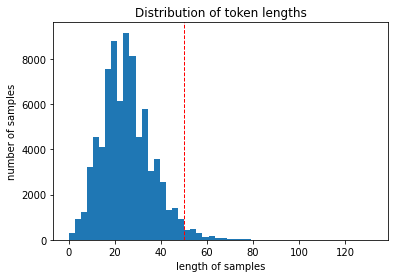

In [18]:
get_token_len(kor_tokens, max_len, True)

토큰 길이 평균: 31.04476496808834
토큰 길이 최소: 2
토큰 길이 최대: 118
토큰 길이 표준편차: 12.882826222378892
설정 최대 길이: 50
전체 문장의 91.4%가 설정값인 50에 포함됩니다.


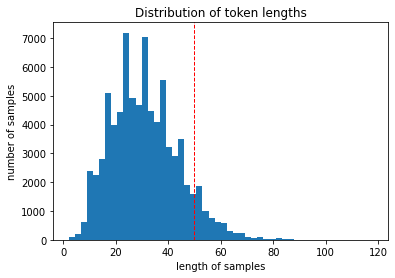

In [19]:
get_token_len(eng_tokens, max_len, True)

In [20]:

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    
    src_tok = ko_tokenizer.encode(kor_corpus[idx], out_type=int)
    tgt_tok = en_tokenizer.encode(eng_corpus[idx], out_type=int)
    
    cond1 = len(src_tok) > 1 & len(src_tok) <= 50
    cond2 = len(tgt_tok) > 1 & len(tgt_tok) <= 50
    
    if cond1 & cond2:
        src_corpus.append(src_tok)
        tgt_corpus.append(tgt_tok)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

## Step 3. 모델 설계

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

## Positional Encoding

In [22]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    sinusoid_table = sinusoid_table[np.newaxis, ...]
    return sinusoid_table #tf.cast(sinusoid_table, dtype=tf.float32)

## Multi-Head Attention

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        scaled_qk = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(d_k)
        
        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        
        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x self.num_heads x length x self.depth ]
        """
        batch = x.shape[0]
        split_x = tf.reshape(x, shape=(batch, -1, self.num_heads, self.depth))

        return tf.transpose(split_x, perm=[0, 2, 1, 3])

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])

        return tf.reshape(combined_x, shape=(batch, -1, self.d_model))
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        # step 1
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # step 2
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        # step 3
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_split, WK_split, WV_split, mask)
        
        # Step 4
        out = self.combine_heads(out)
        
        # Step 5
        out = self.linear(out)

        return out, attention_weights

## Position-wise Feed-Forward Network

In [24]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## Encoder 레이어 구현하기

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

## Decoder 레이어 구현하기

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, enc_dec_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, enc_dec_attn

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## Transformer 완성하기

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        # 1. Embedding layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared: 
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        # 6. Dropout 정의
        self.dropout = tf.keras.layers.Dropout(dropout)

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        
        out = emb(x)
        
        if self.shared: 
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[:, :seq_len, :]
        
        out = self.dropout(out)
        
        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


## 모델 밖의 조력자들

In [30]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## Step 4. 훈련하기

앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, 예문에 대한 멋진 번역을 제출하세요!

### 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)

In [32]:
N_LAYERS = 2       # 인코더와 디코더의 층의 개수
D_MODEL = 256      # 인코더와 디코더 내부 입, 출력의 고정 차원
N_HEADS = 8        # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 2048       # 피드 포워드 신경망의 은닉층의 크기
# src_vocab_size
# tgt_vocab_size,
POS_LEN = enc_train.shape[1]
DROPOUT = 0.2      #dropout
#shared

In [33]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

In [34]:
transformer = Transformer(N_LAYERS,
                         D_MODEL,
                         N_HEADS,
                         UNITS,
                         SRC_VOCAB_SIZE,
                         TGT_VOCAB_SIZE,
                         POS_LEN,
                         dropout=DROPOUT,
                         shared=True)

### 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [36]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### 결과(output)

        Translations
        > 1. obama is the president elect .
        > 2. they are in the city .
        > 3. they don t need to be a lot of drink .
        > 4. seven other people have been killed in the attacks .

        Hyperparameters
        > n_layers: 2
        > d_model: 512
        > n_heads: 8
        > d_ff: 2048
        > dropout: 0.3

        Training Parameters
        > Warmup Steps: 4000
        > Batch Size: 64
        > Epoch At: 5


### Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)





In [37]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [106]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!


In [39]:
from tqdm import tqdm    # tqdm
import random

In [40]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [41]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [42]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    #print('Input: %s' % (sentence))
    #print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
    return result

In [43]:
enc_train = tf.convert_to_tensor(enc_train)
dec_train = tf.convert_to_tensor(dec_train)

In [105]:
from tqdm import notebook
import random
import tensorflow as tf
import numpy as np

def train_and_translate(transformer, optimizer, enc_train, dec_train, ko_tokenizer, en_tokenizer, 
                        epochs, batch_size, examples, interval, 
                        start_epoch=0, loss_history=None, translates=None):

    if loss_history is None:
        loss_history = []
    if translates is None:
        translates = []

    for epoch in range(start_epoch, start_epoch + epochs):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = notebook.tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(
                enc_train[idx:idx + batch_size],
                dec_train[idx:idx + batch_size],
                transformer,
                optimizer
            )

            loss_history.append(batch_loss)
            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
        results = []
        for example in examples:
            result = translate(example, transformer, ko_tokenizer, en_tokenizer)
            results.append(result)

        translates.append((epoch + 1, results))
        
        if (epoch + 1) % interval == 0:
            print(f"Epoch {epoch + 1}")
            print(f"Translations: ")
            for result in results:
                print(f"> {result}")

    return loss_history, translates

In [45]:
BATCH_SIZE = 64
EPOCHS = 10
INTERVAL = 5

examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

loss_history, translates = train_and_translate(transformer, optimizer, enc_train, dec_train, ko_tokenizer, en_tokenizer, EPOCHS, BATCH_SIZE, examples, INTERVAL)

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 5 Translations: ['obama s presidential race .', 'the city is home to the city .', 'coffee shouldn t be coffee .', 'the death toll in the worst fighting has risen .']


  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 10 Translations: ['obama is a presidential spokesman .', 'the city is a city of downtown .', 'the coffee is a cheap .', 'nine people were killed and others were killed .']


In [46]:
# Continue training from the last epoch
additional_epochs = 10
loss_history, translates = train_and_translate(transformer, optimizer, enc_train, dec_train, ko_tokenizer, en_tokenizer, additional_epochs, BATCH_SIZE, examples, INTERVAL, start_epoch=EPOCHS, loss_history=loss_history, translates=translates)

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 15 Translations: ['obama named him .', 'the city streets are at the downtown street .', 'the option of being handed over .', 'on saturday , the state official s death toll from the quake was killed .']


  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 20 Translations: ['obama won t .', 'the city also stays away from the street .', 'the coffee options are a cheap .', 'that has four people were killed .']


In [47]:
# Continue training from the last epoch
EPOCHS += additional_epochs
additional_epochs = 10
loss_history, translates = train_and_translate(transformer, optimizer, enc_train, dec_train, ko_tokenizer, en_tokenizer, additional_epochs, BATCH_SIZE, examples, INTERVAL, start_epoch=EPOCHS, loss_history=loss_history, translates=translates)

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 25 Translations: ['obama campaigns .', 'the city council shoes will share their reopens within the city .', 'the only journey without users .', 'of the blasts were killed sunday .']


  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 30 Translations: ['obama was in president .', 'the city landed near milan in one place yesterday .', 'the only basis .', 'of the deaths were families reported .']


Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


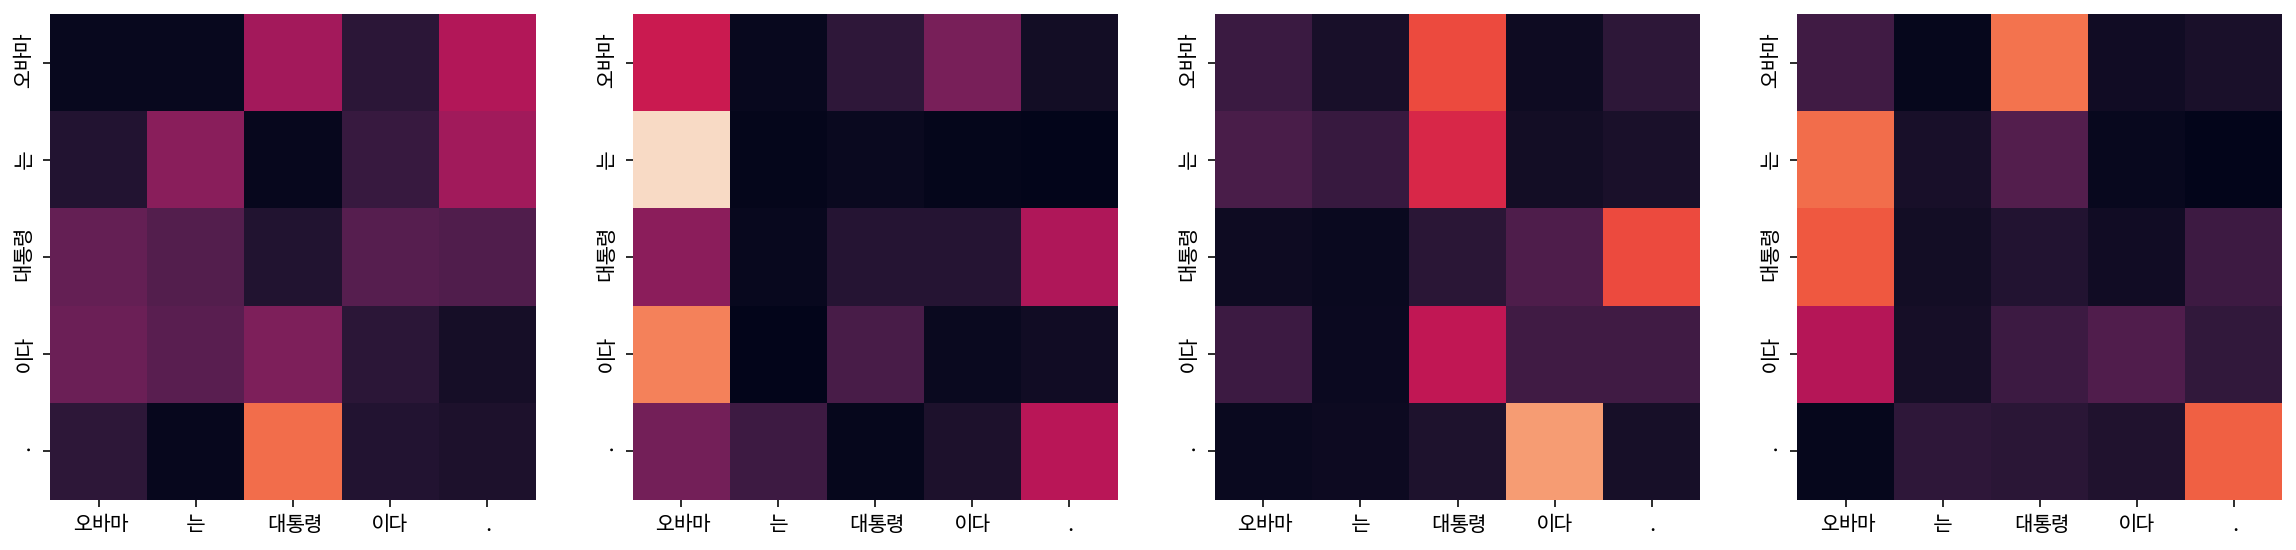

Encoder Layer 2


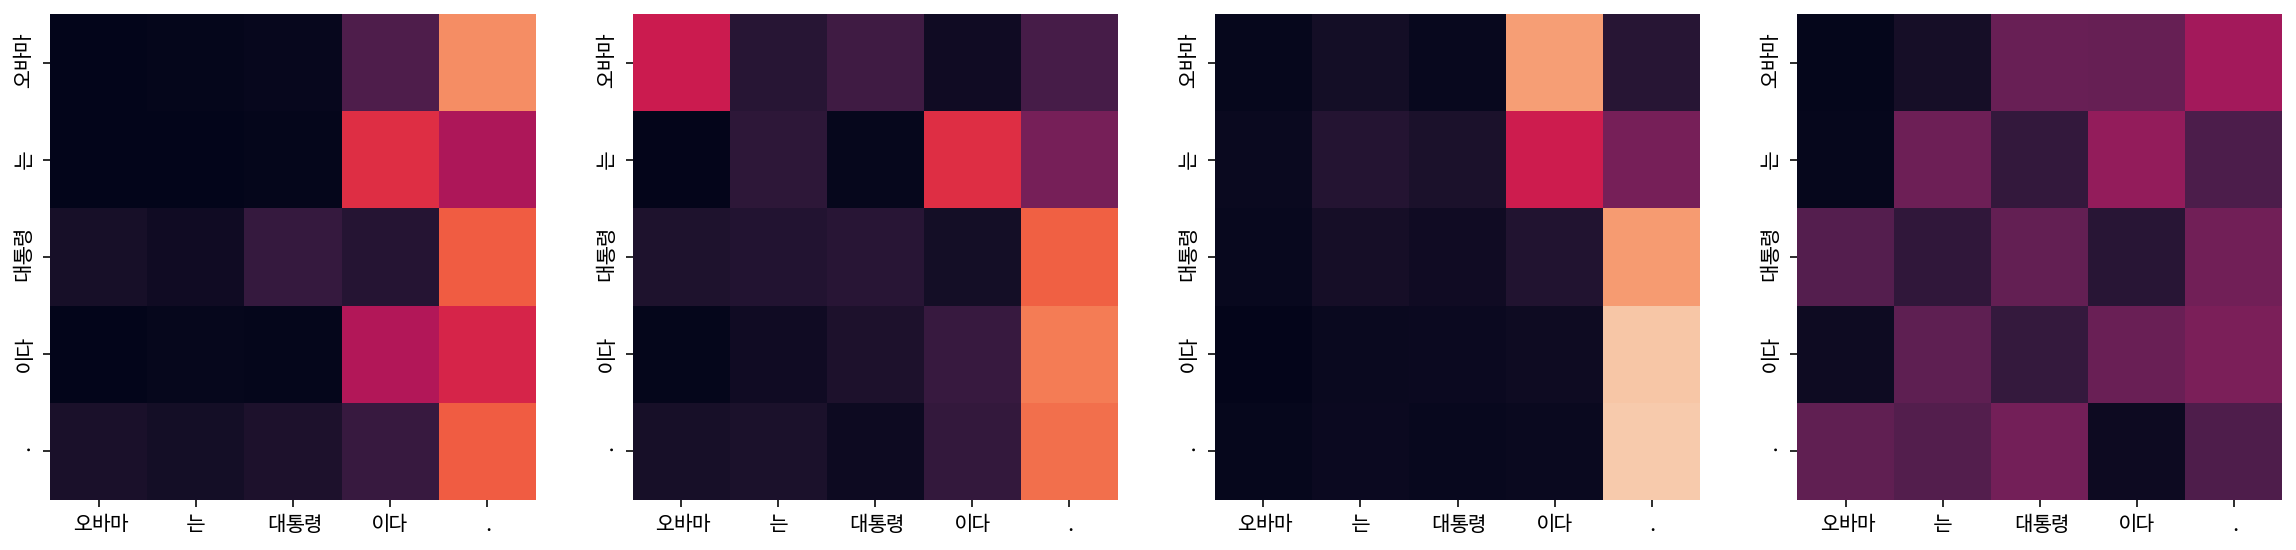

Decoder Self Layer 1


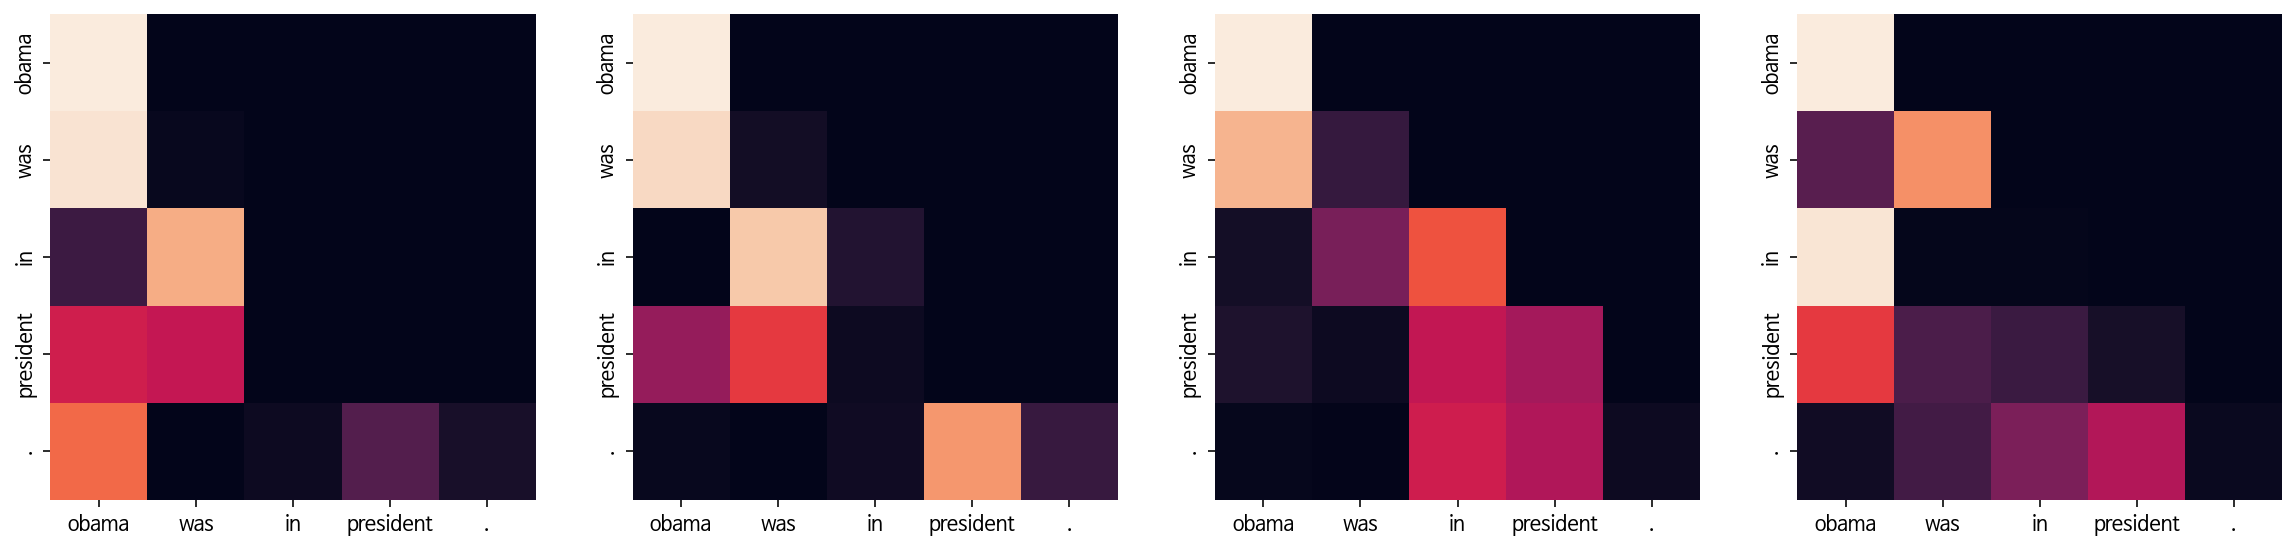

Decoder Src Layer 1


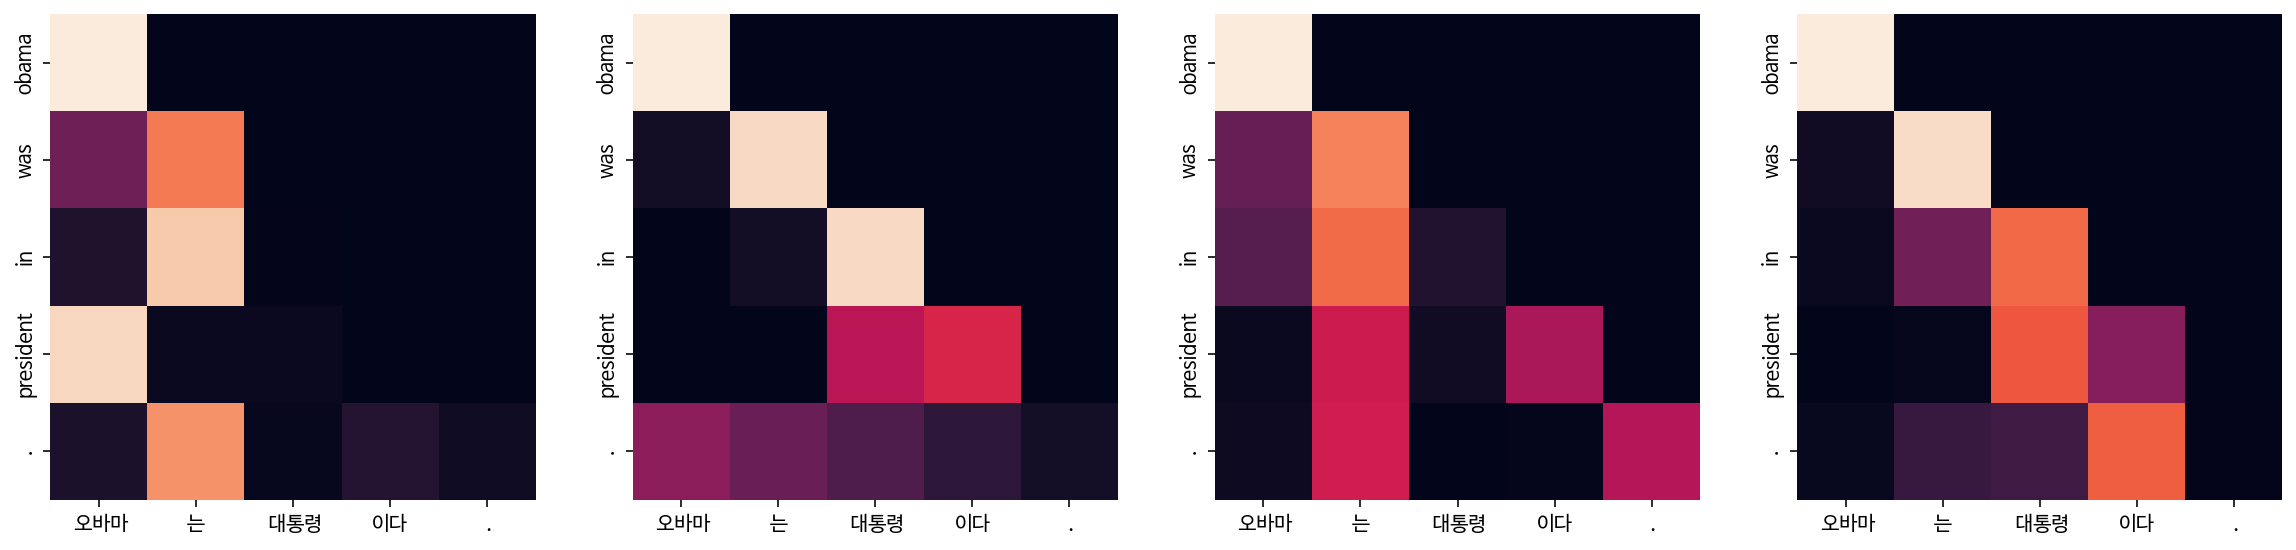

Decoder Self Layer 2


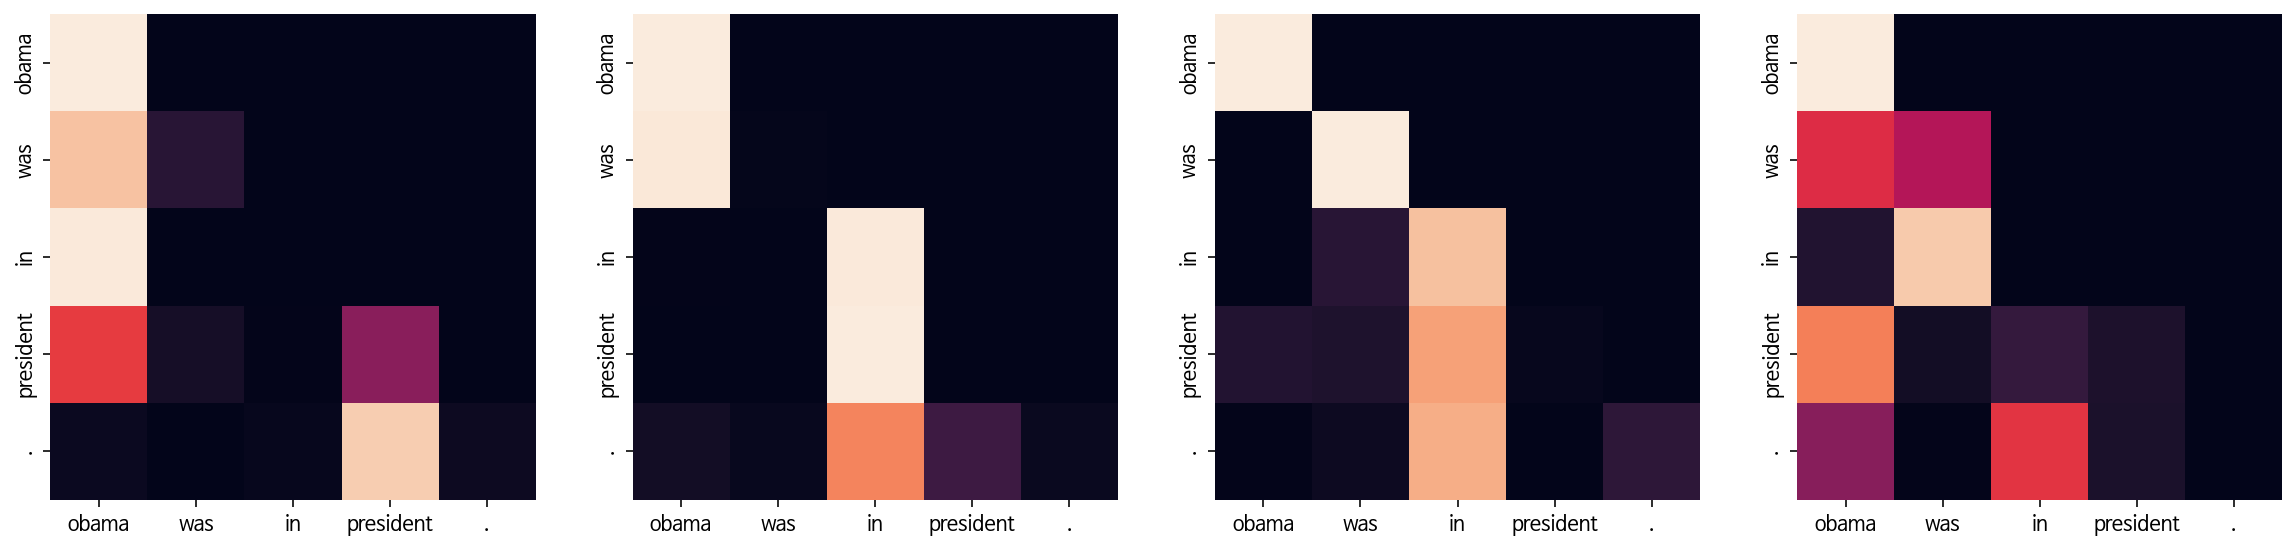

Decoder Src Layer 2


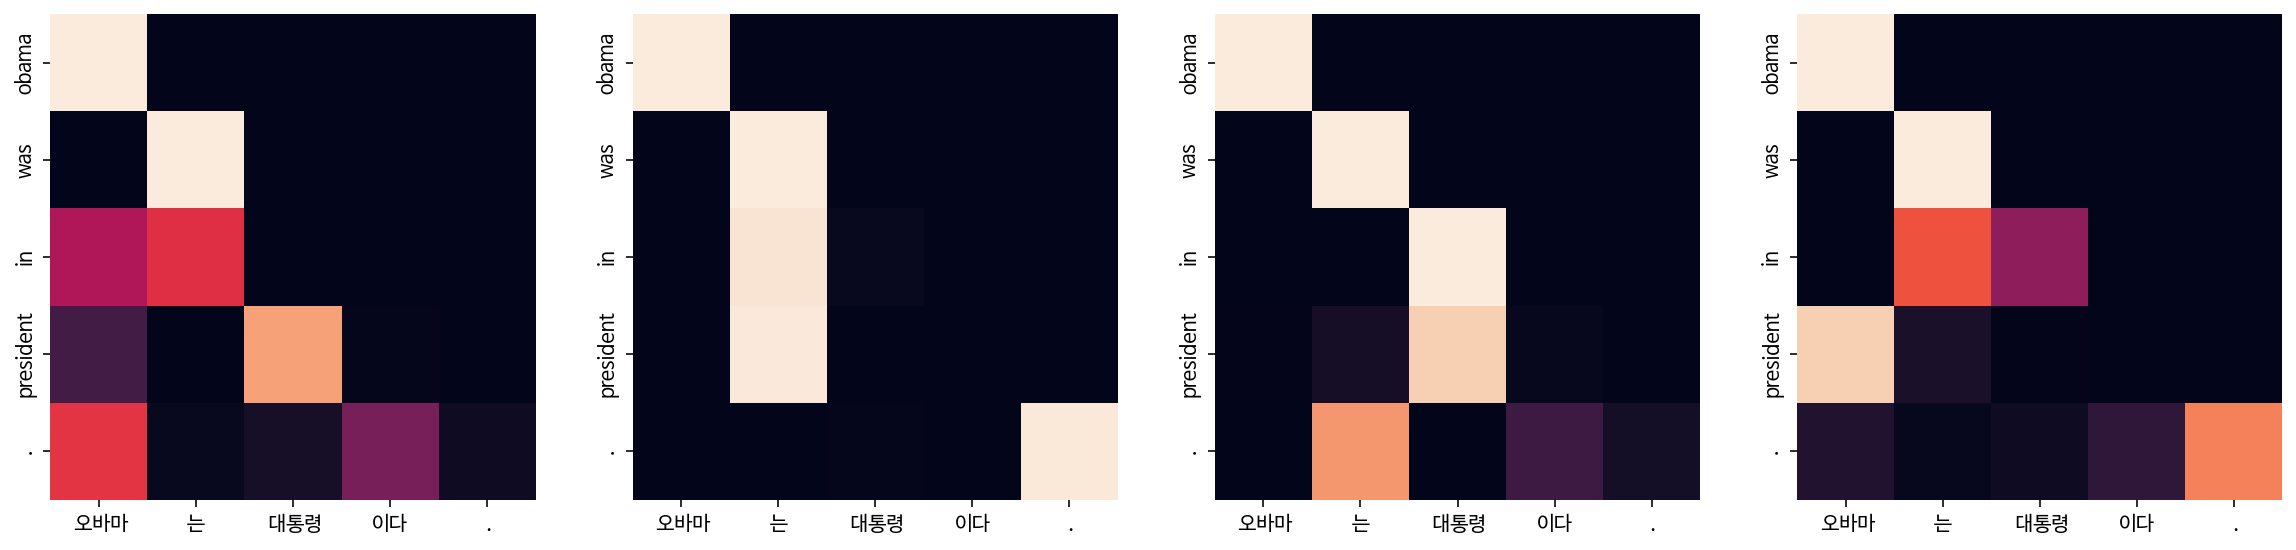

'obama was in president .'

In [48]:
translate(examples[0], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


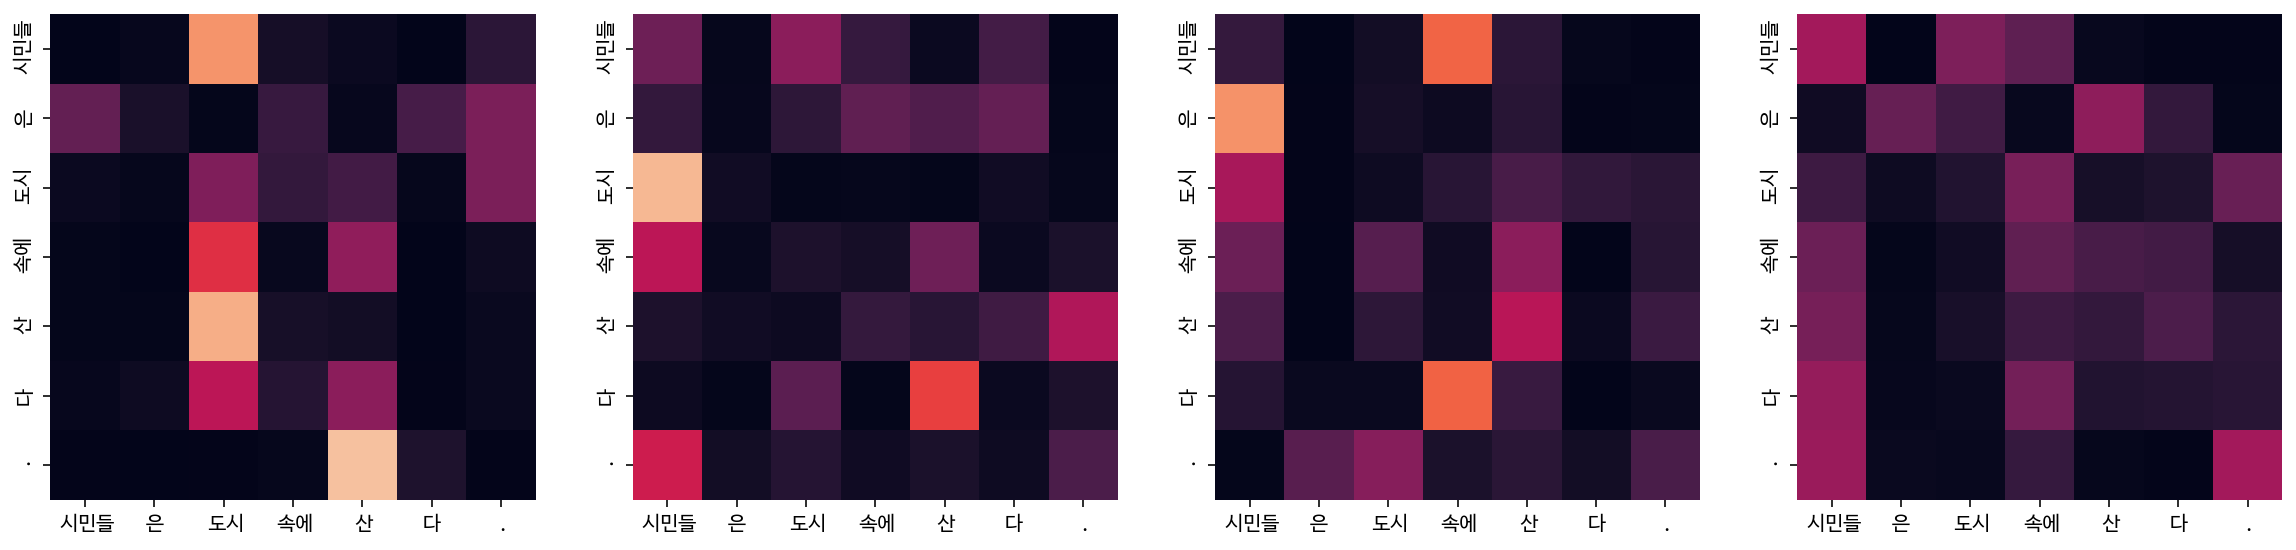

Encoder Layer 2


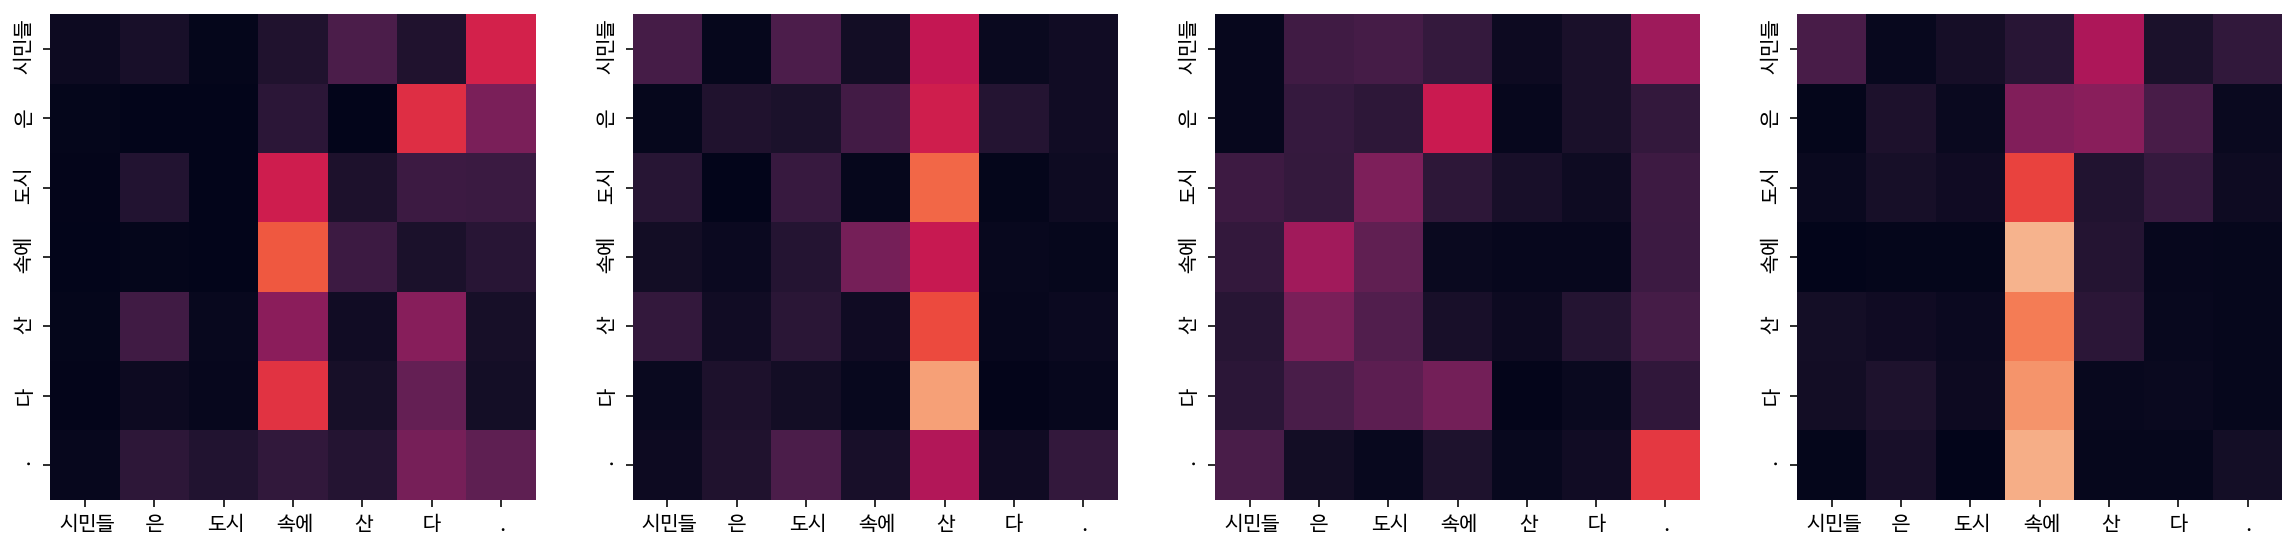

Decoder Self Layer 1


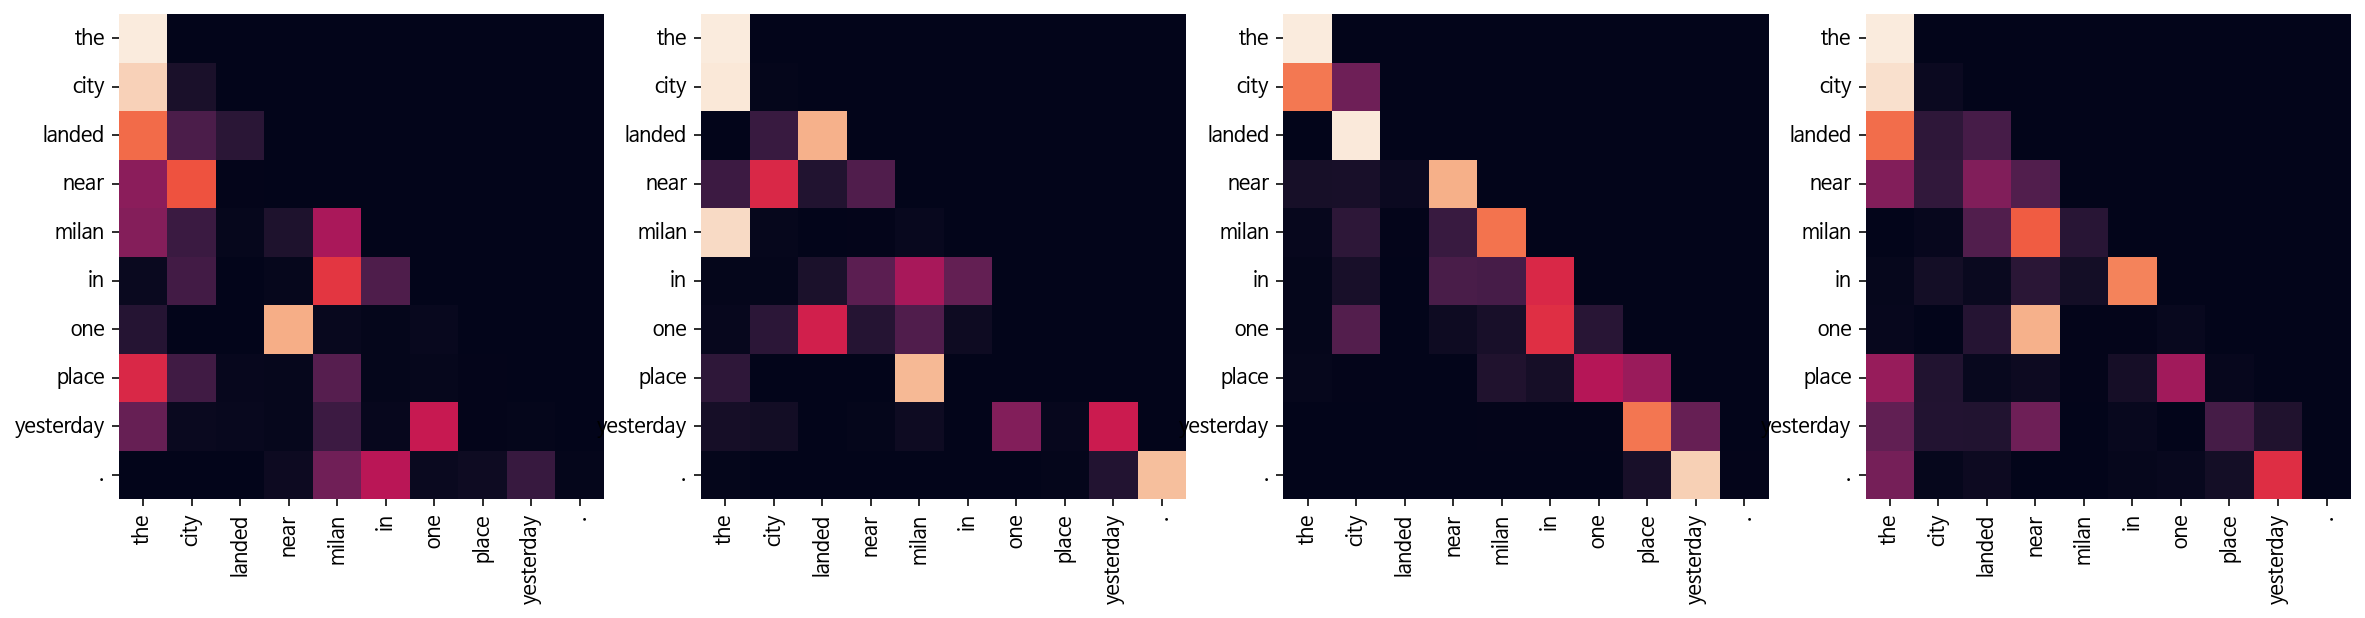

Decoder Src Layer 1


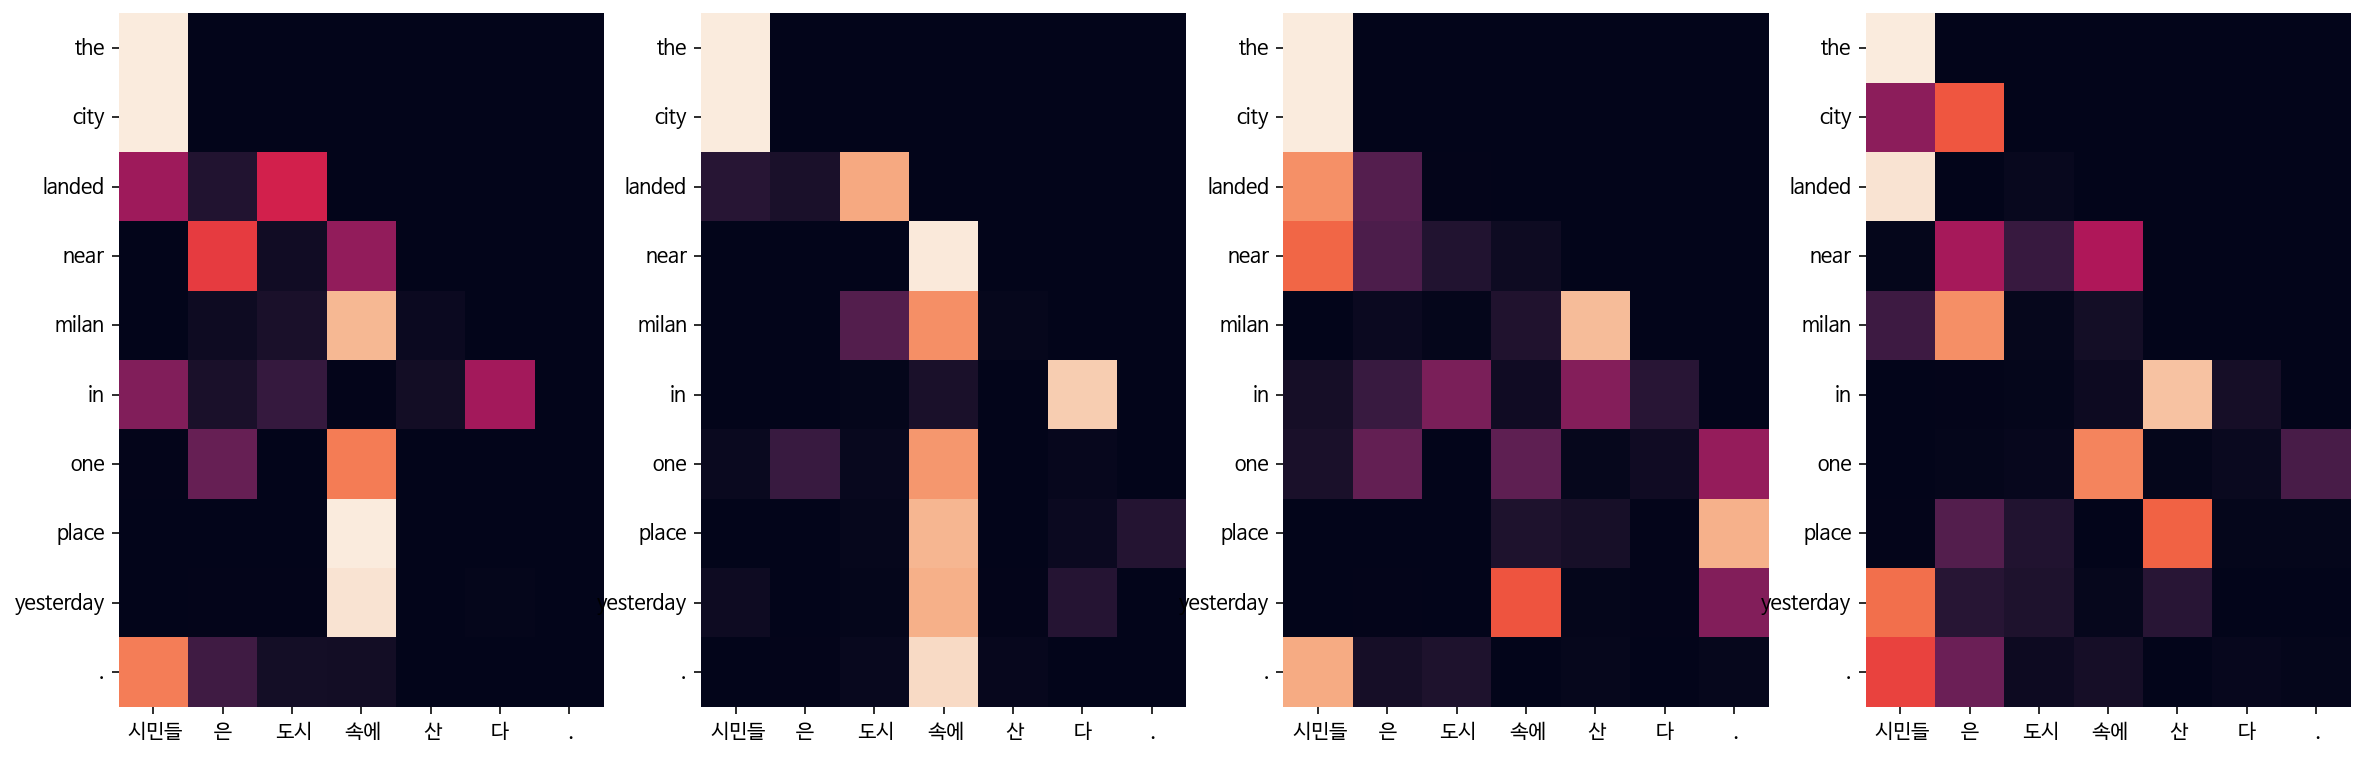

Decoder Self Layer 2


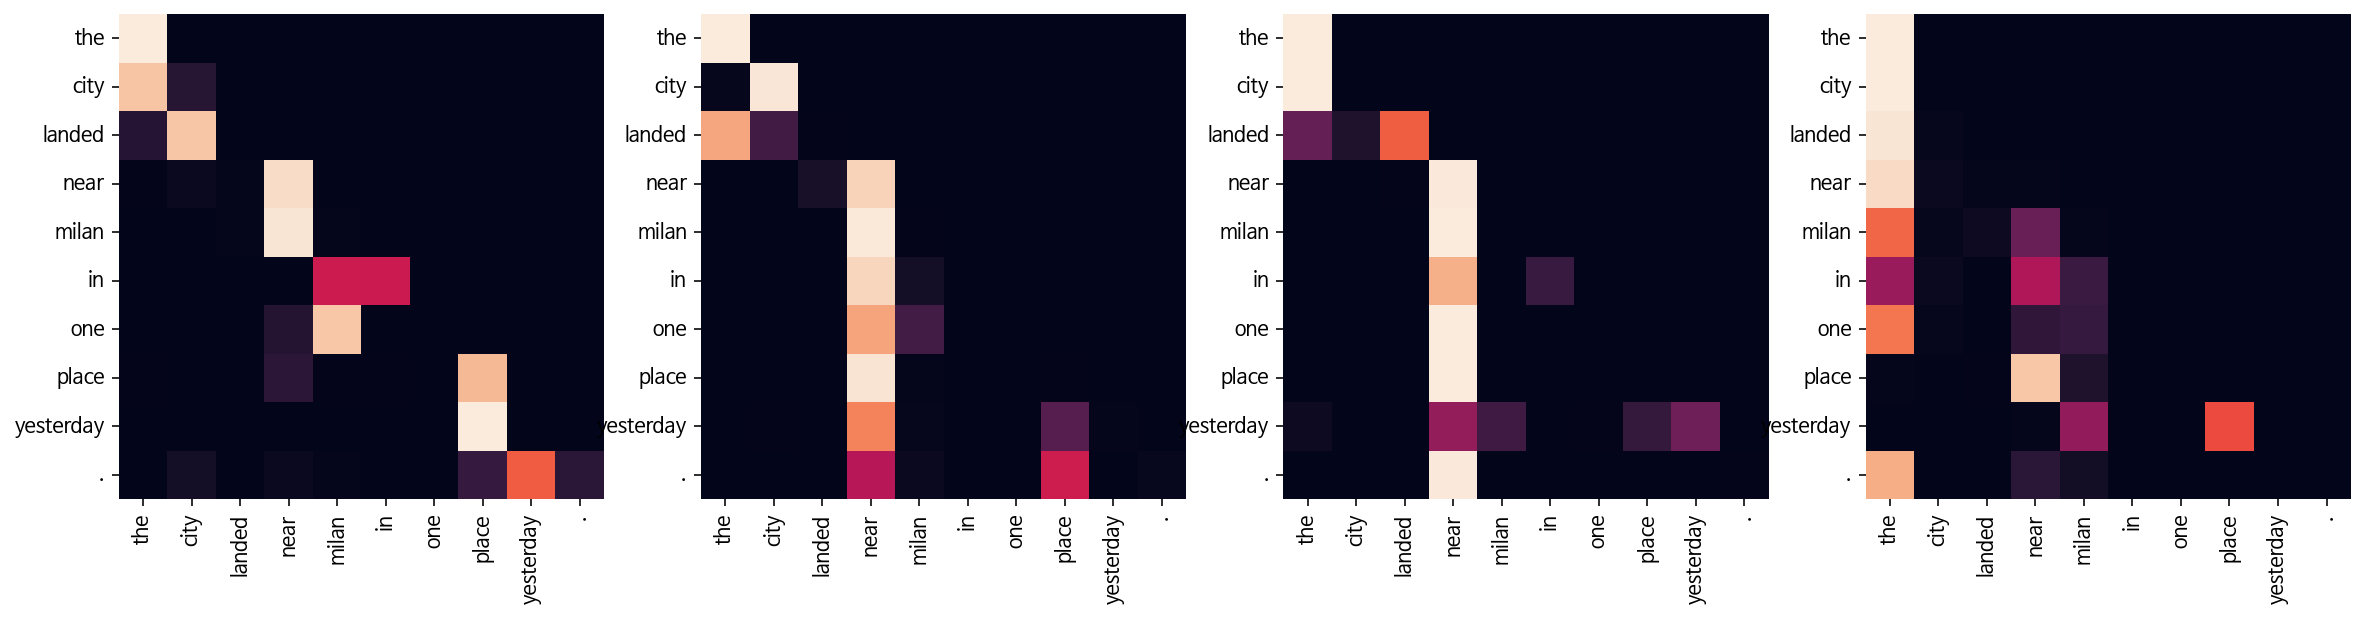

Decoder Src Layer 2


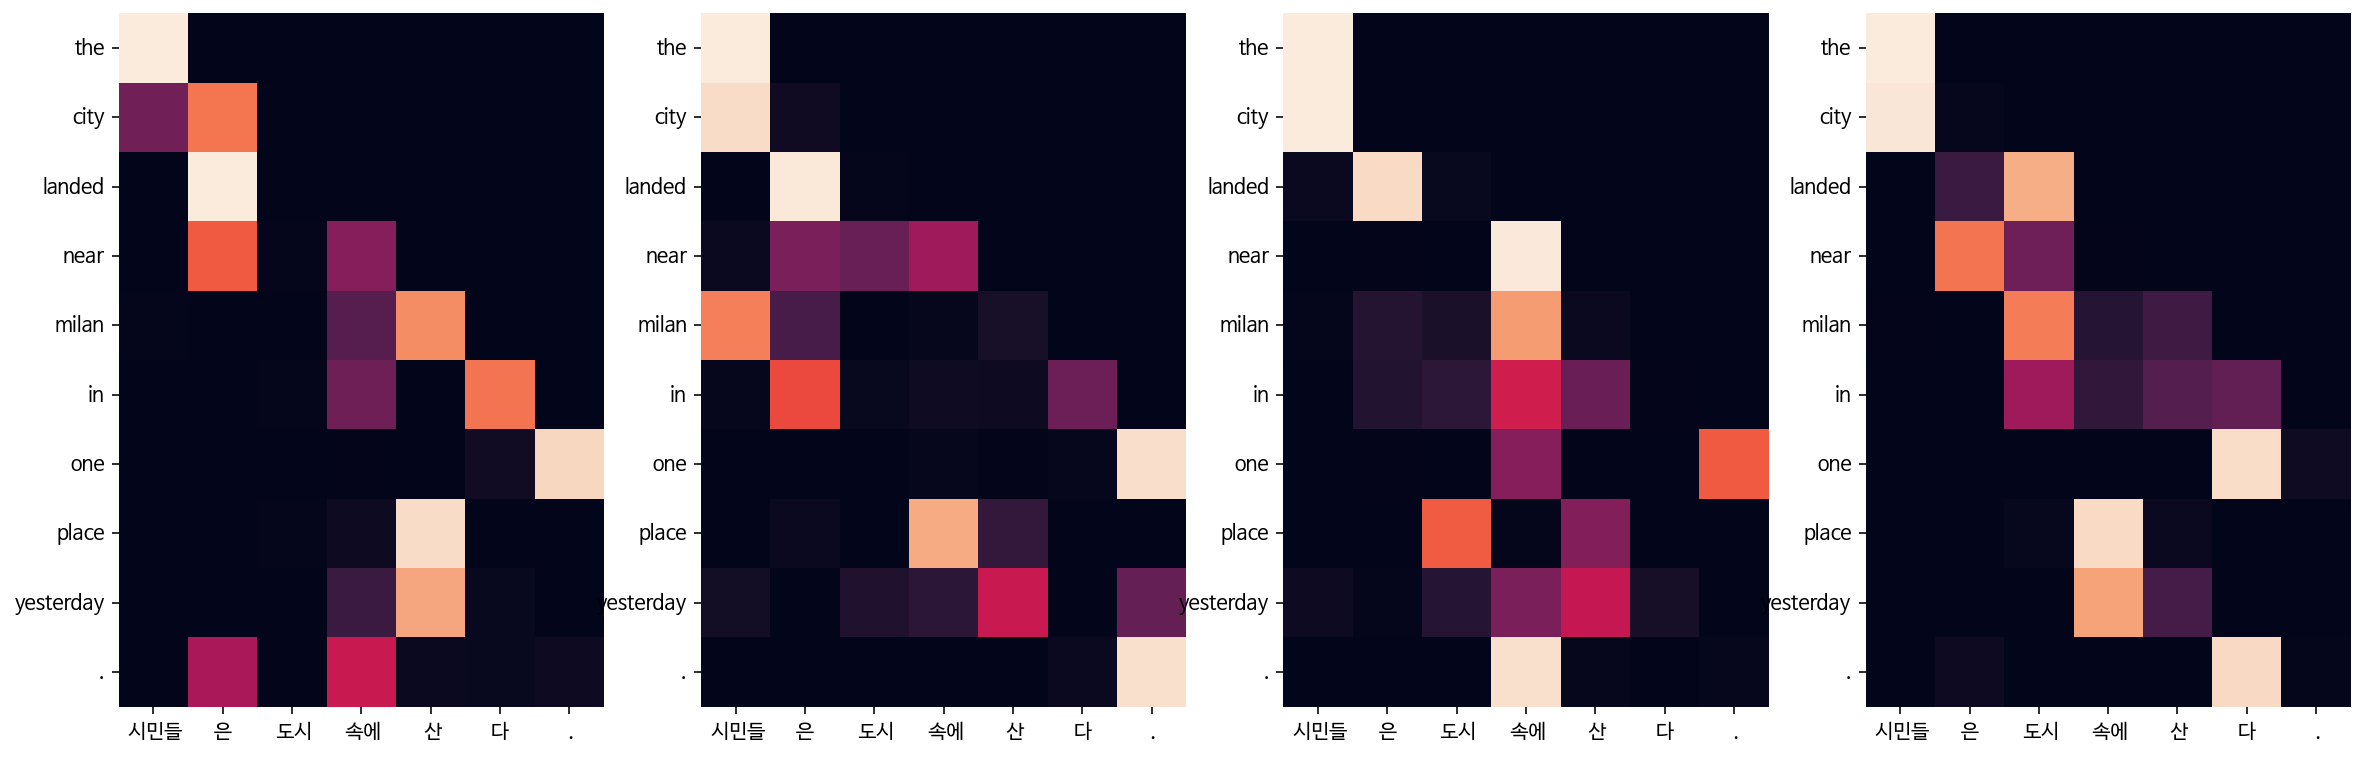

'the city landed near milan in one place yesterday .'

In [49]:
translate(examples[1], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


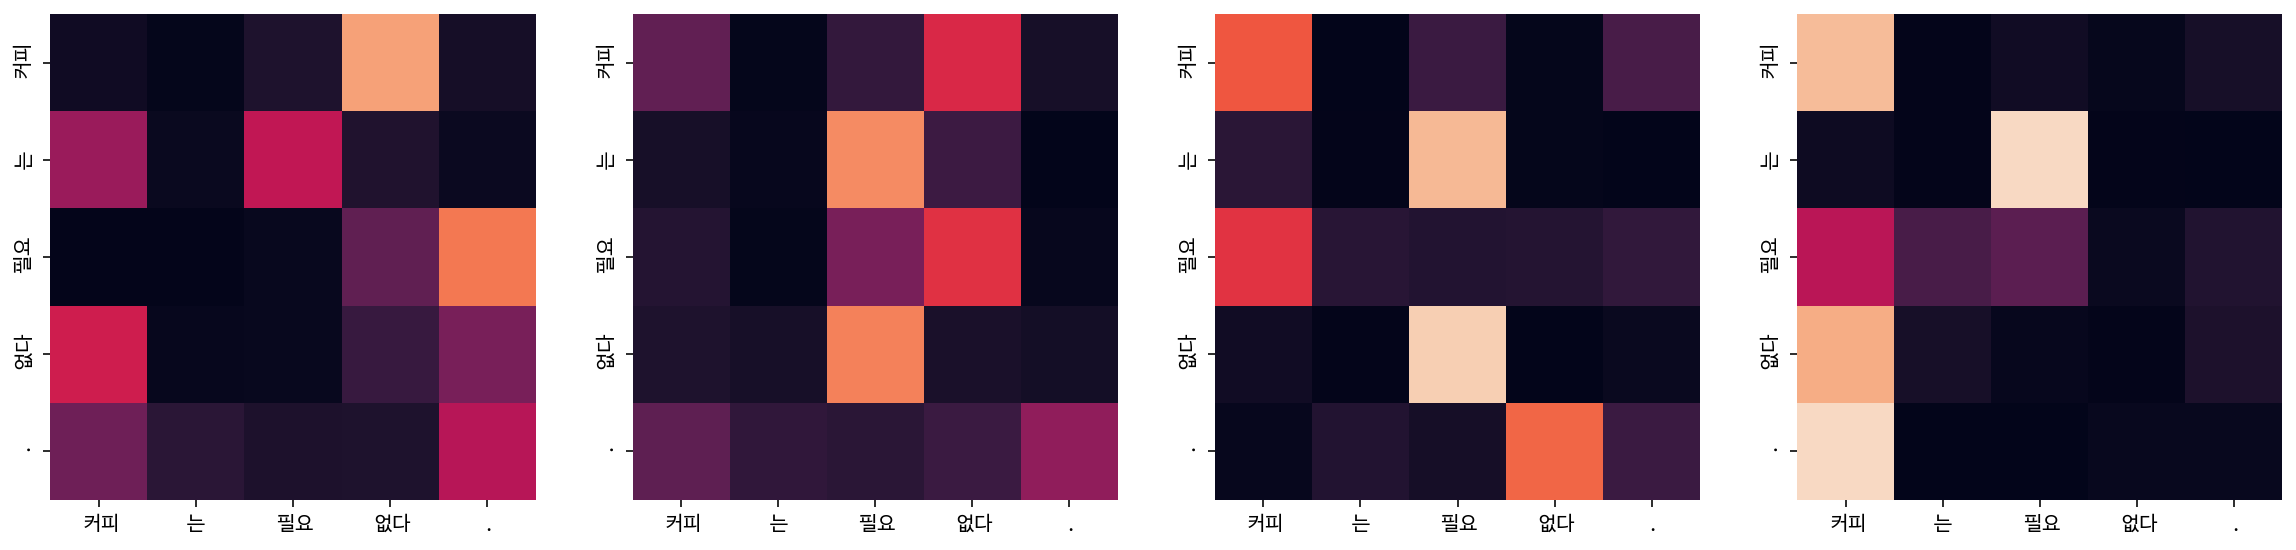

Encoder Layer 2


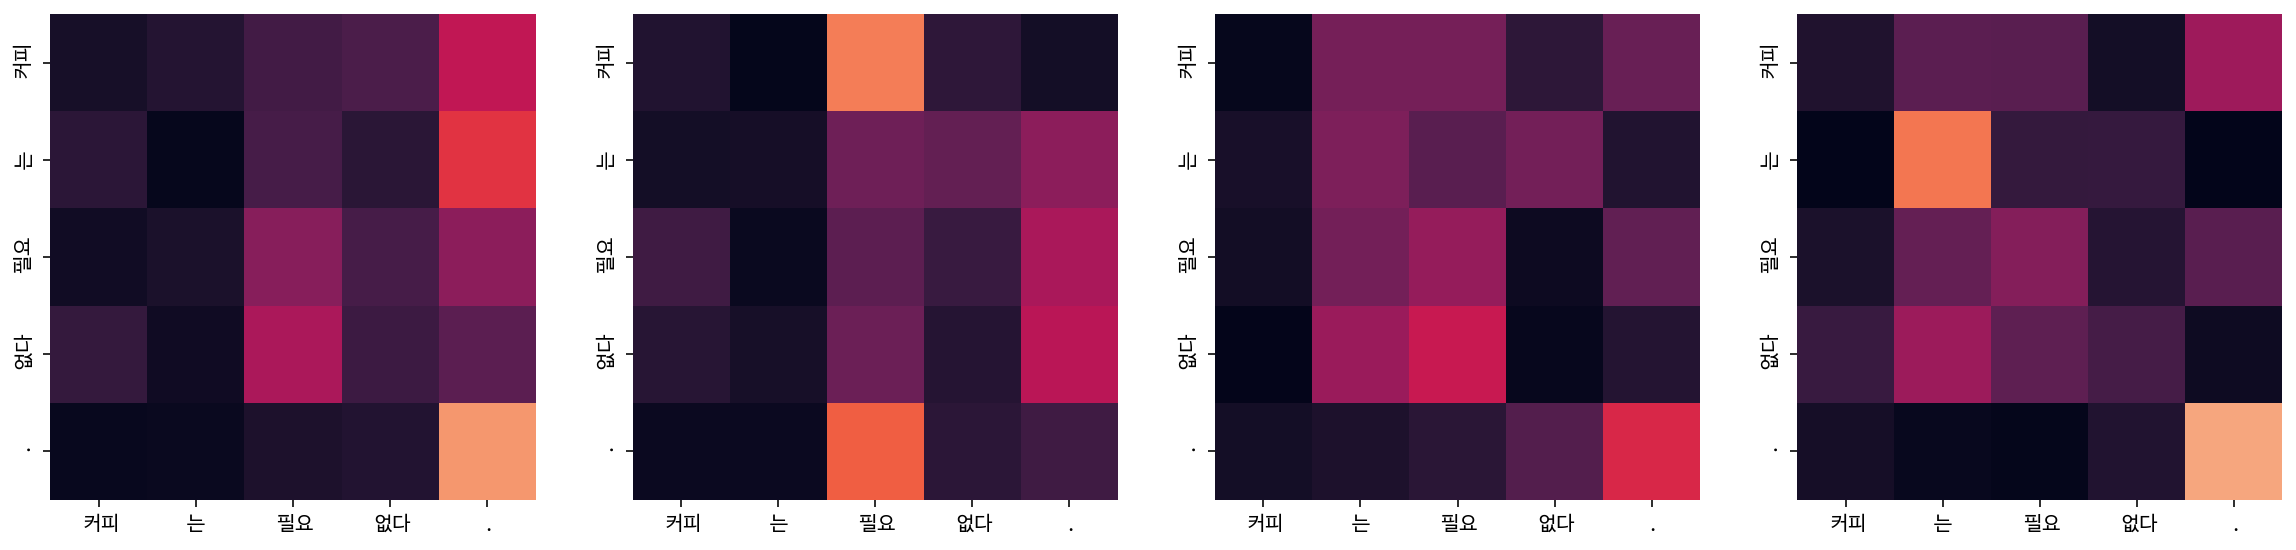

Decoder Self Layer 1


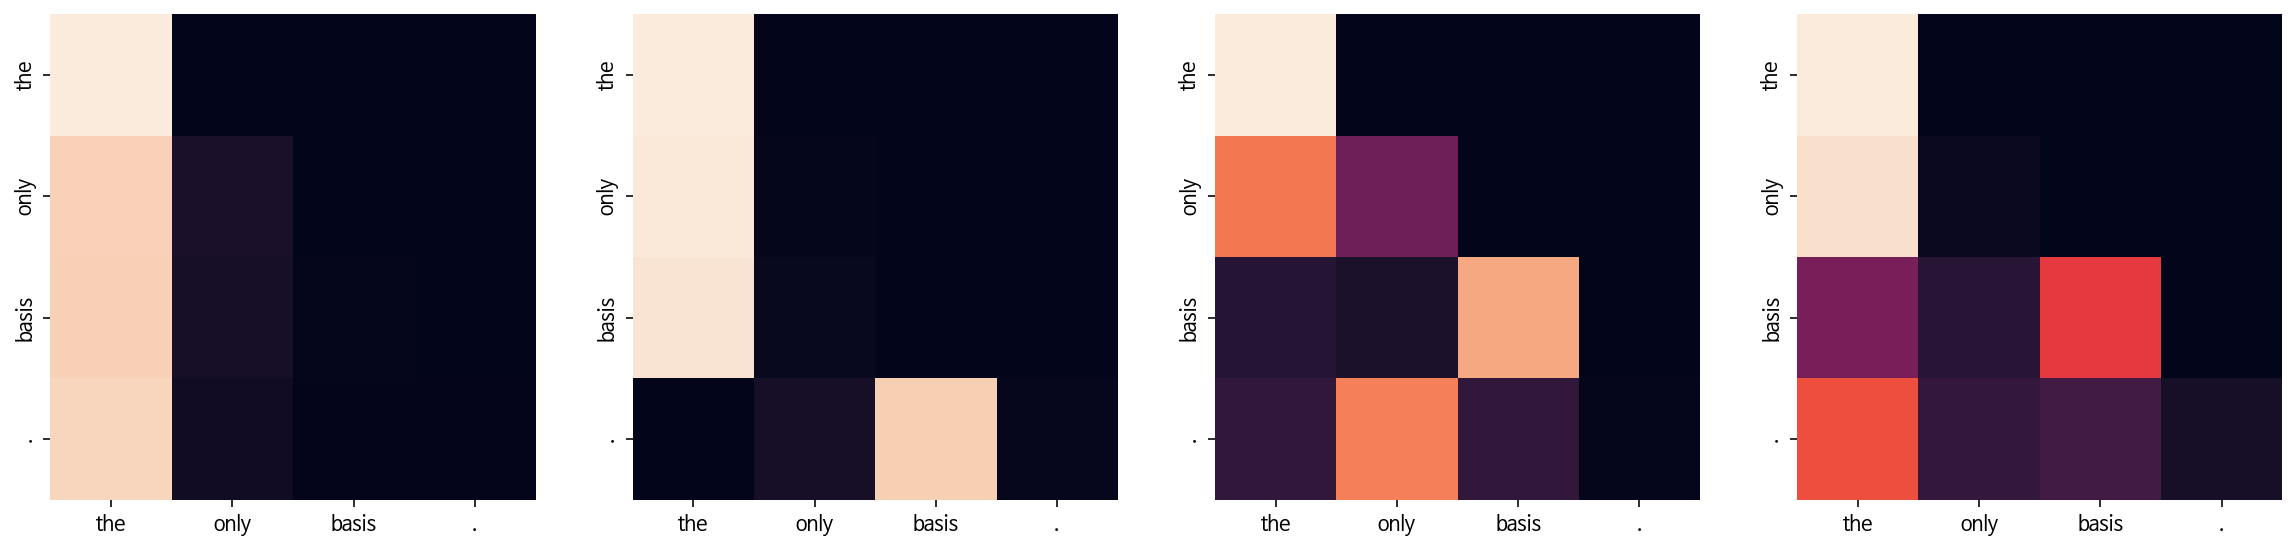

Decoder Src Layer 1


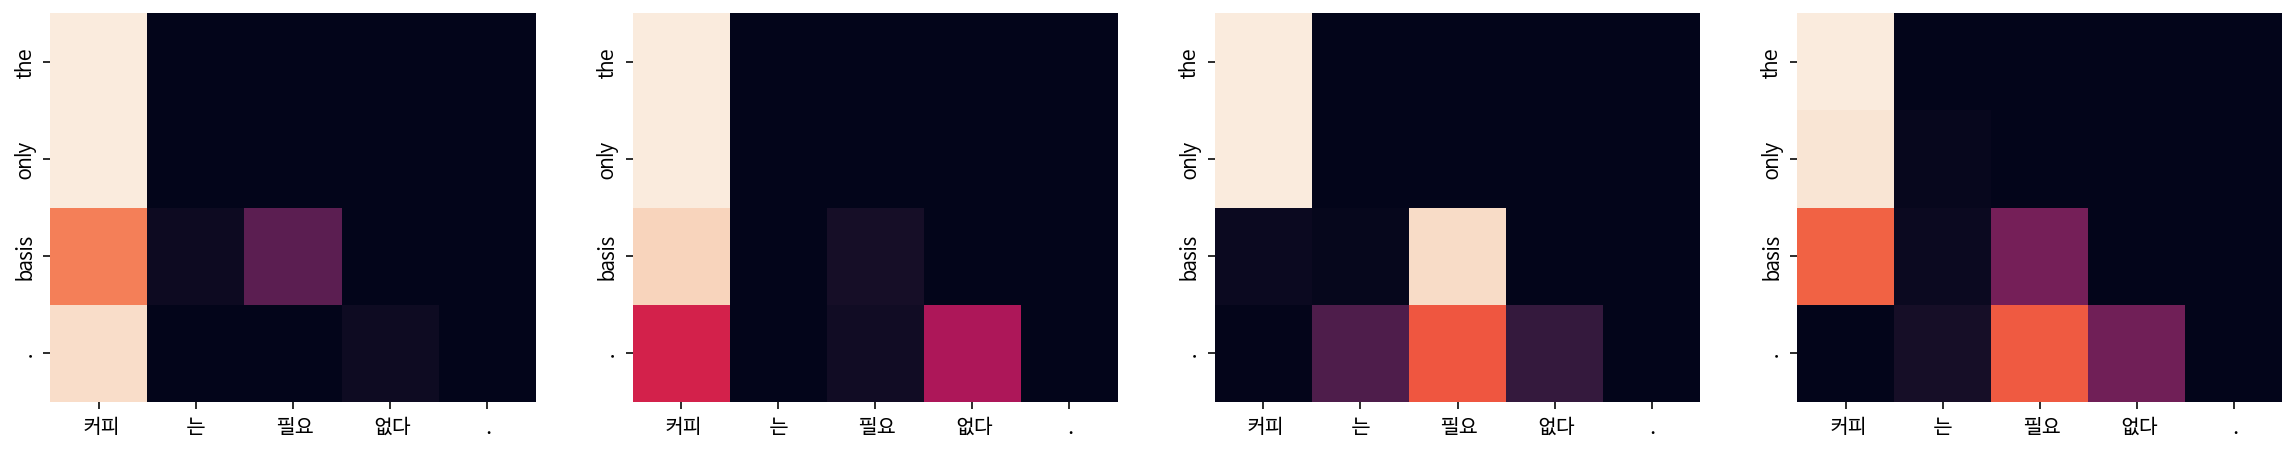

Decoder Self Layer 2


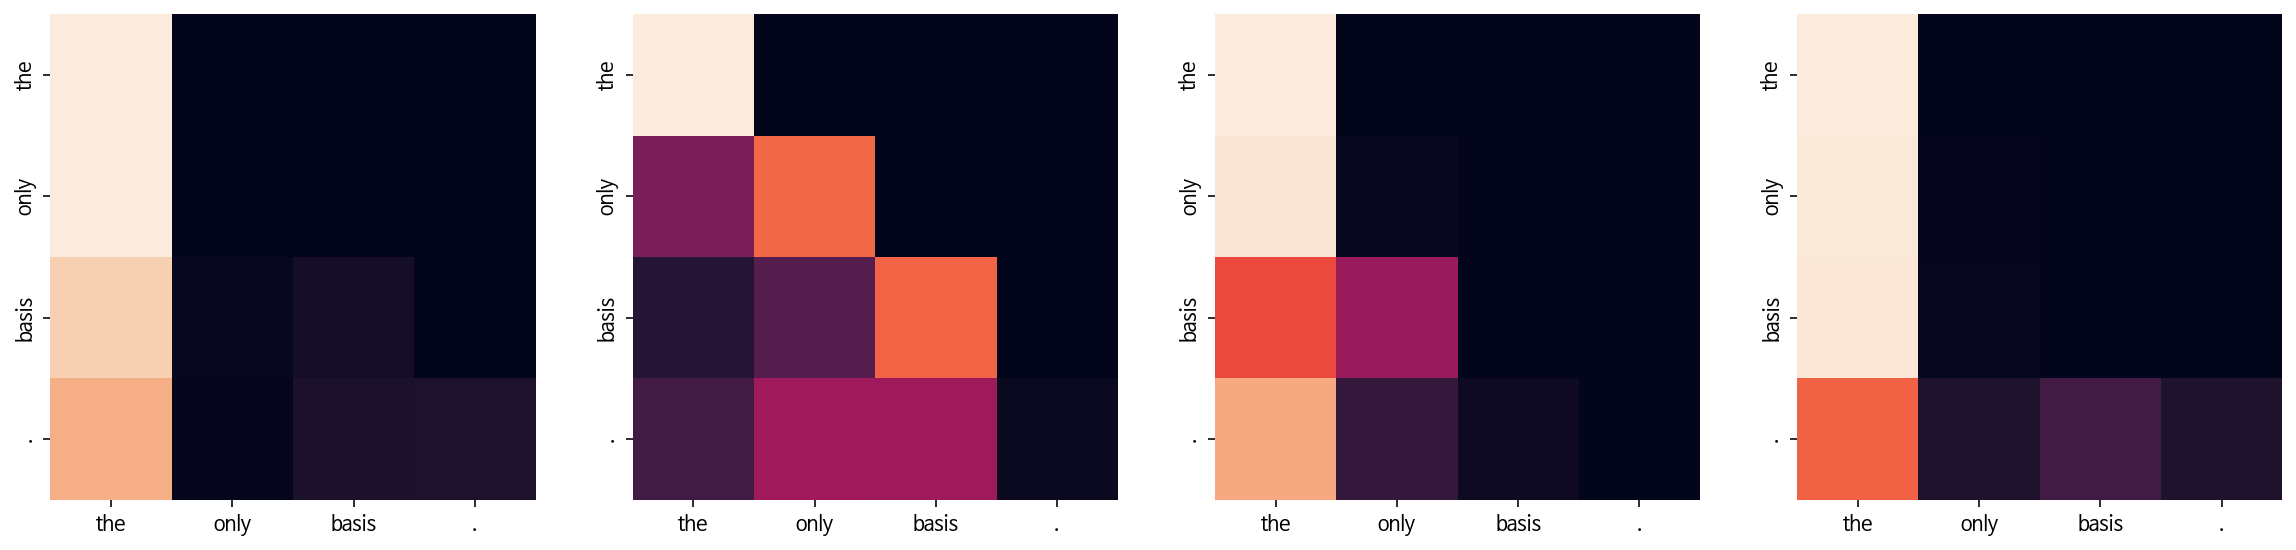

Decoder Src Layer 2


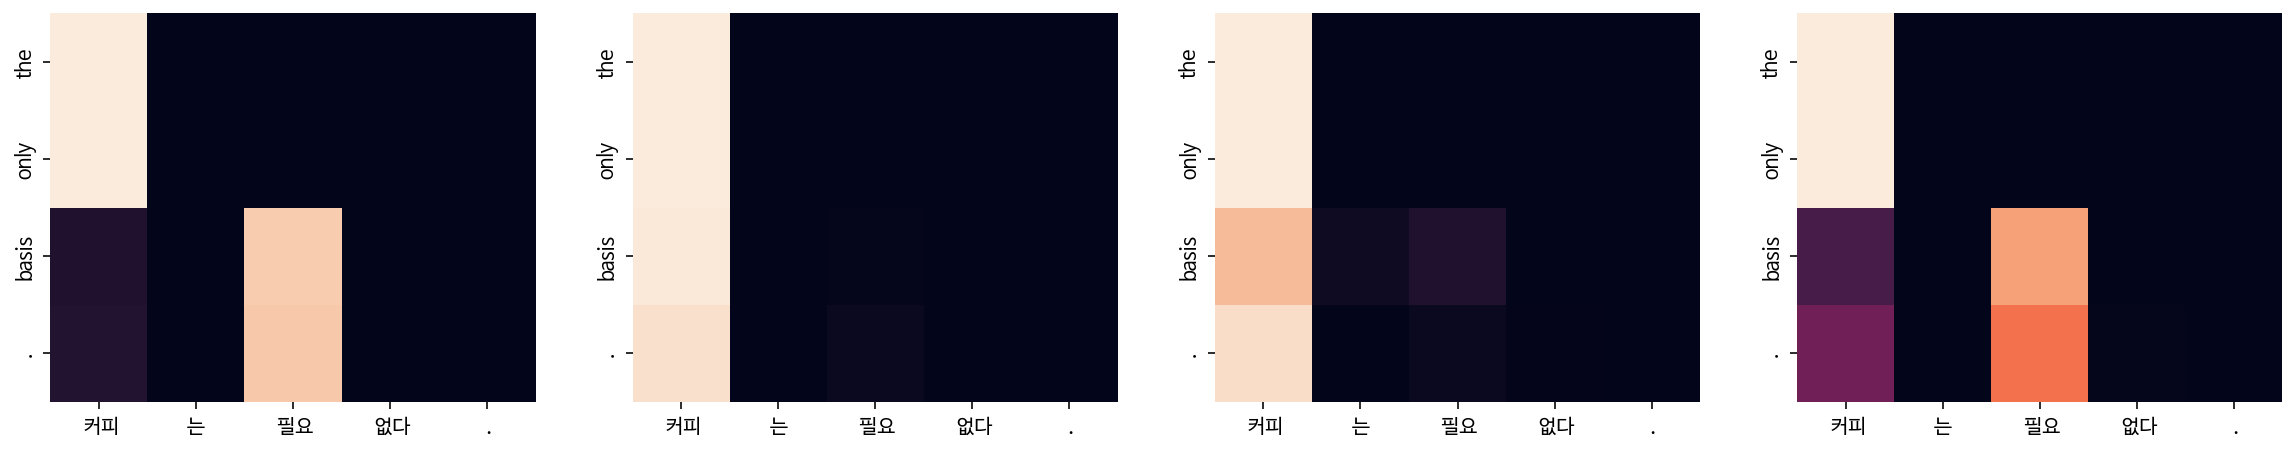

'the only basis .'

In [50]:
translate(examples[2], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


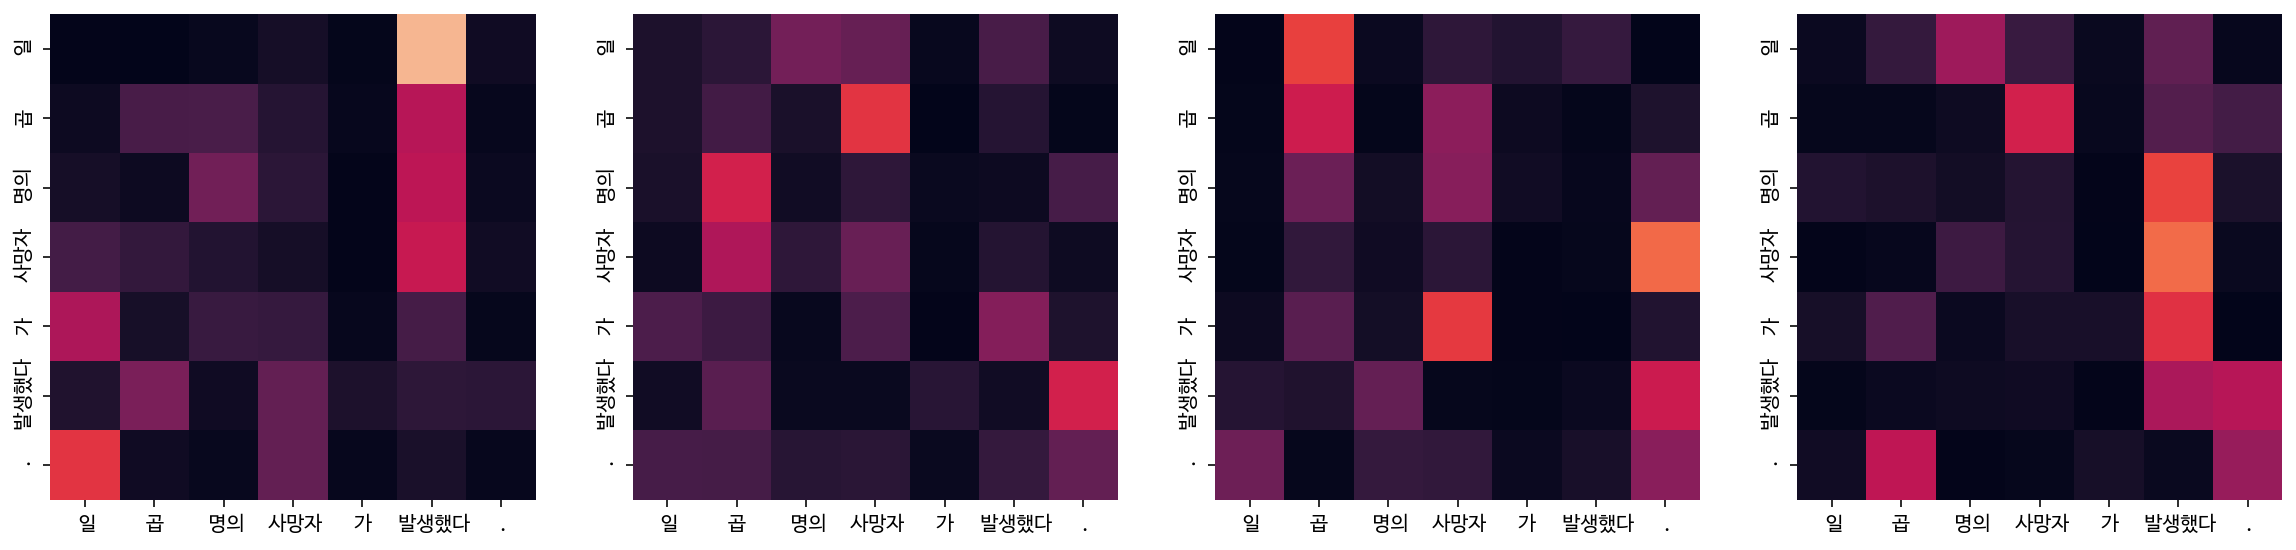

Encoder Layer 2


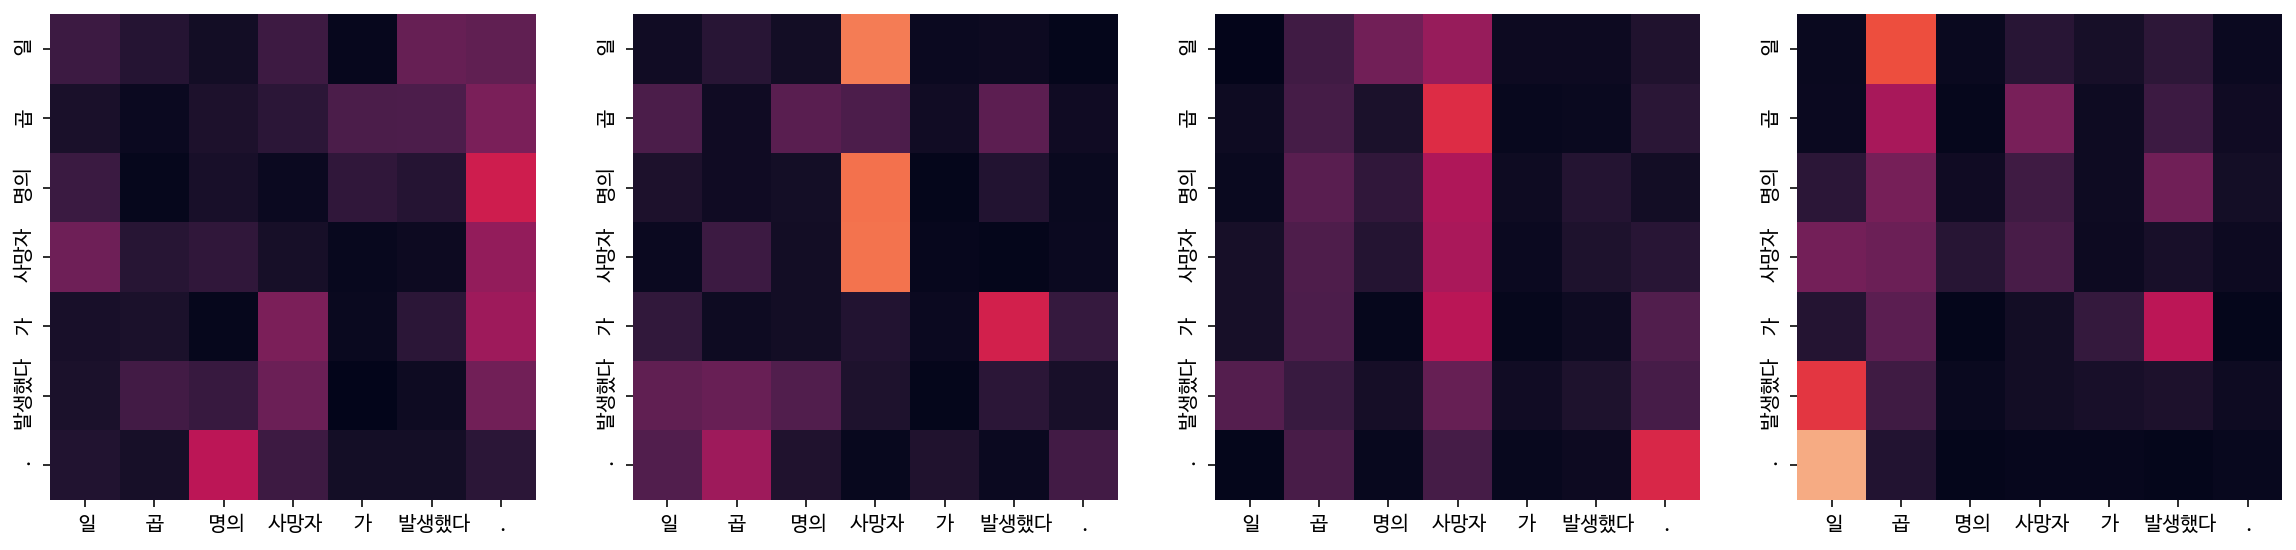

Decoder Self Layer 1


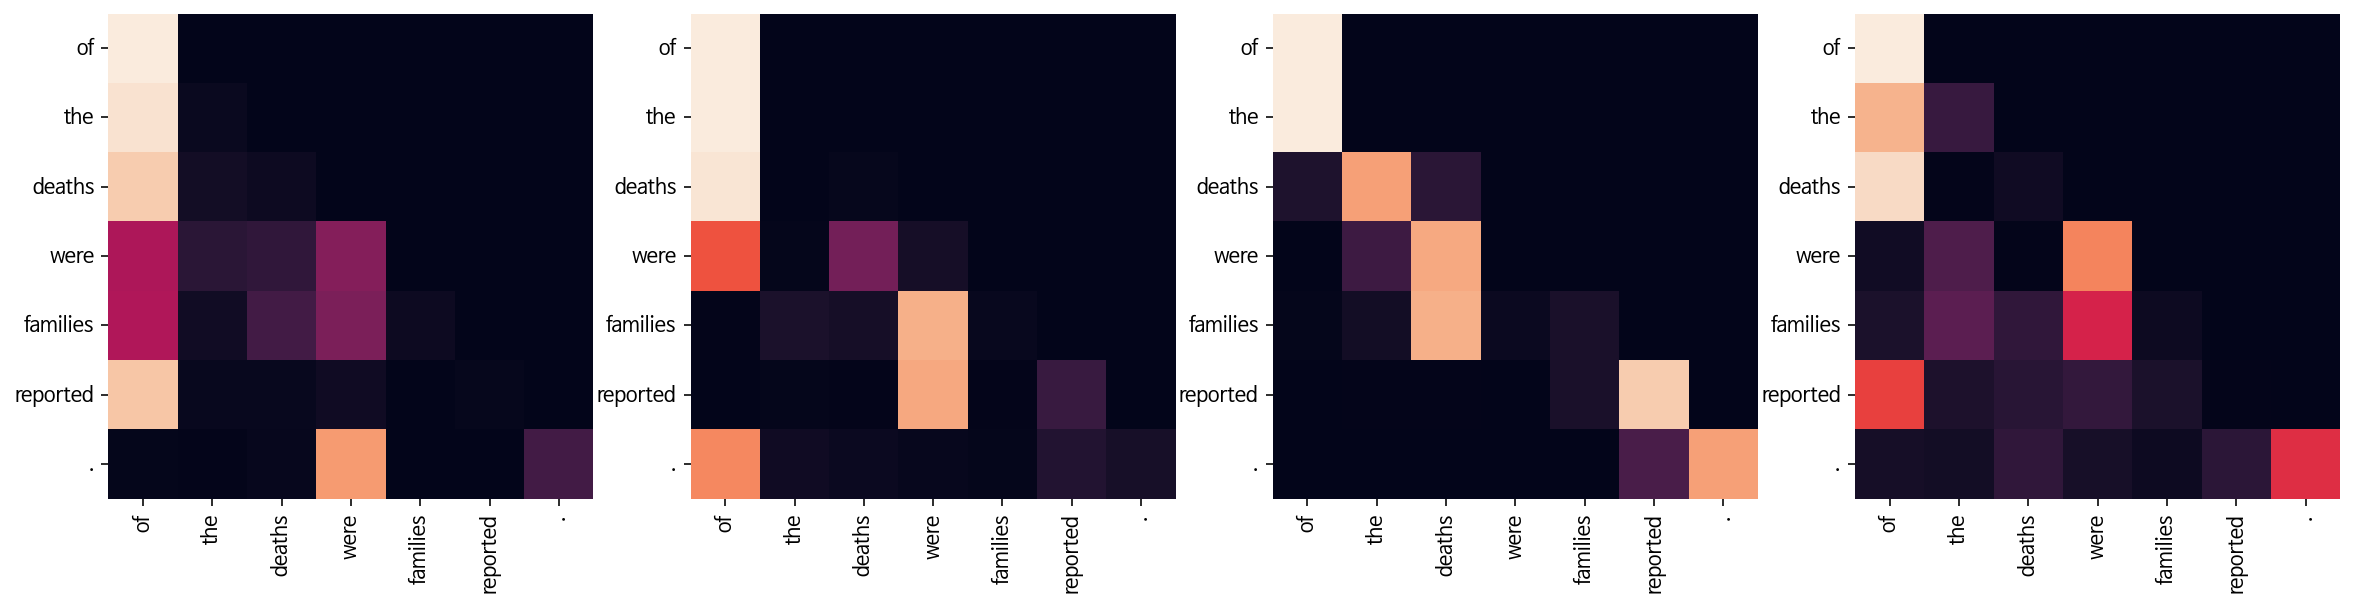

Decoder Src Layer 1


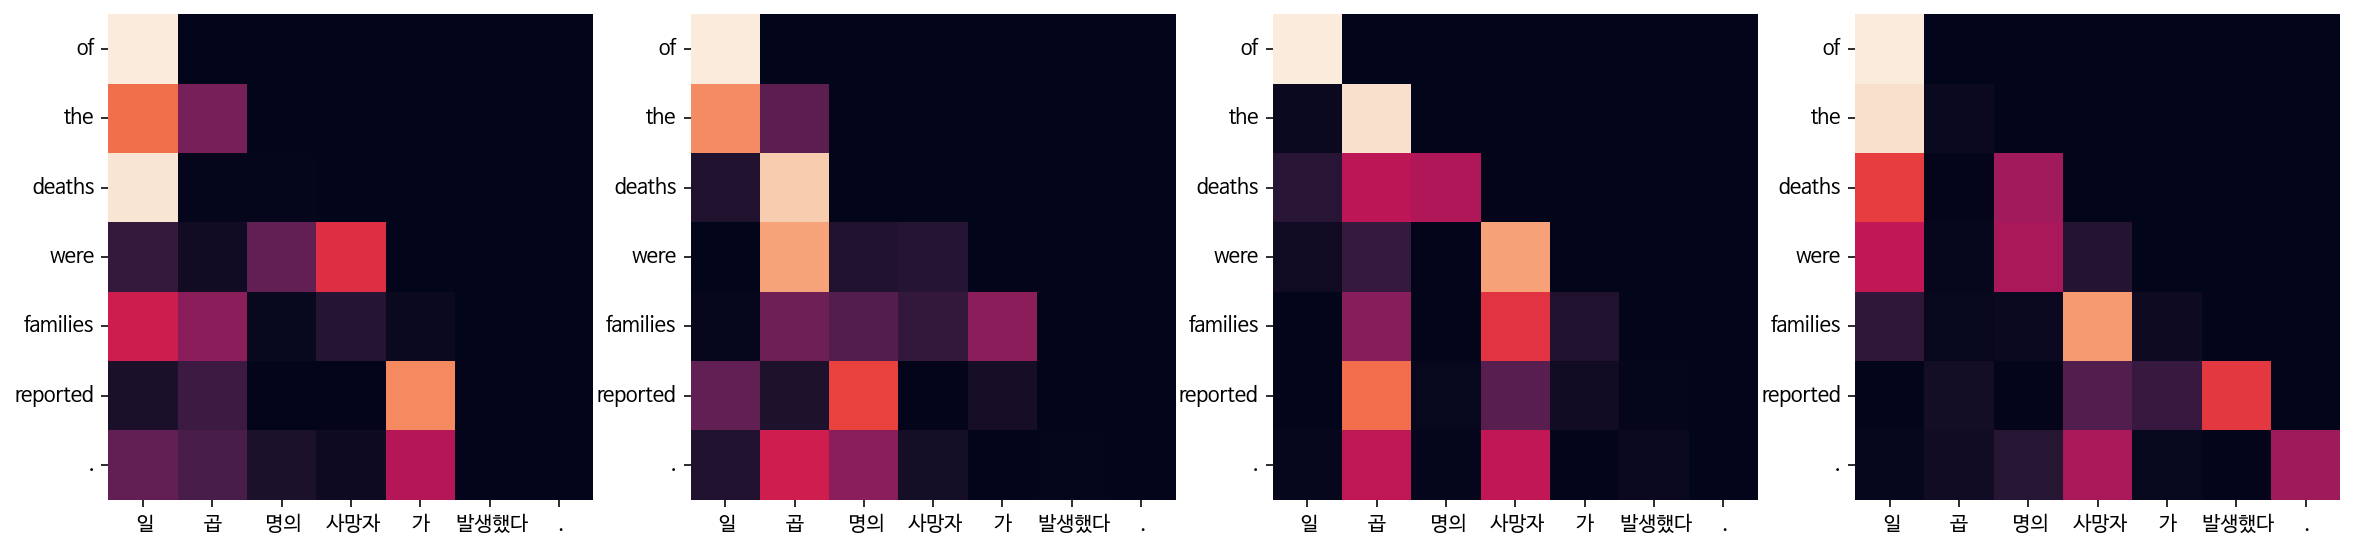

Decoder Self Layer 2


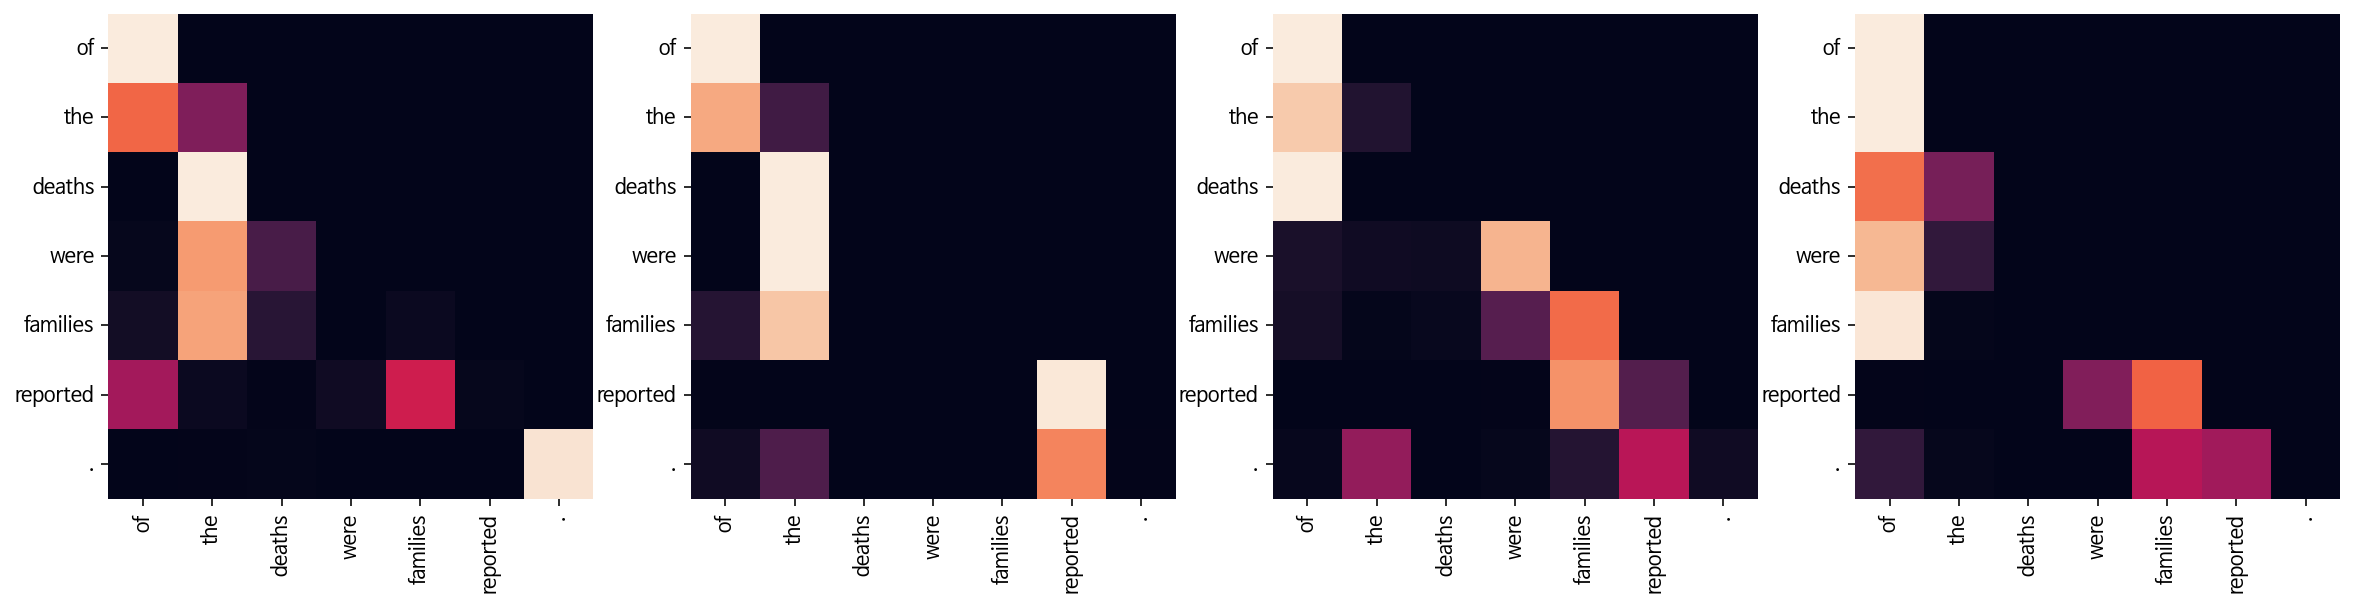

Decoder Src Layer 2


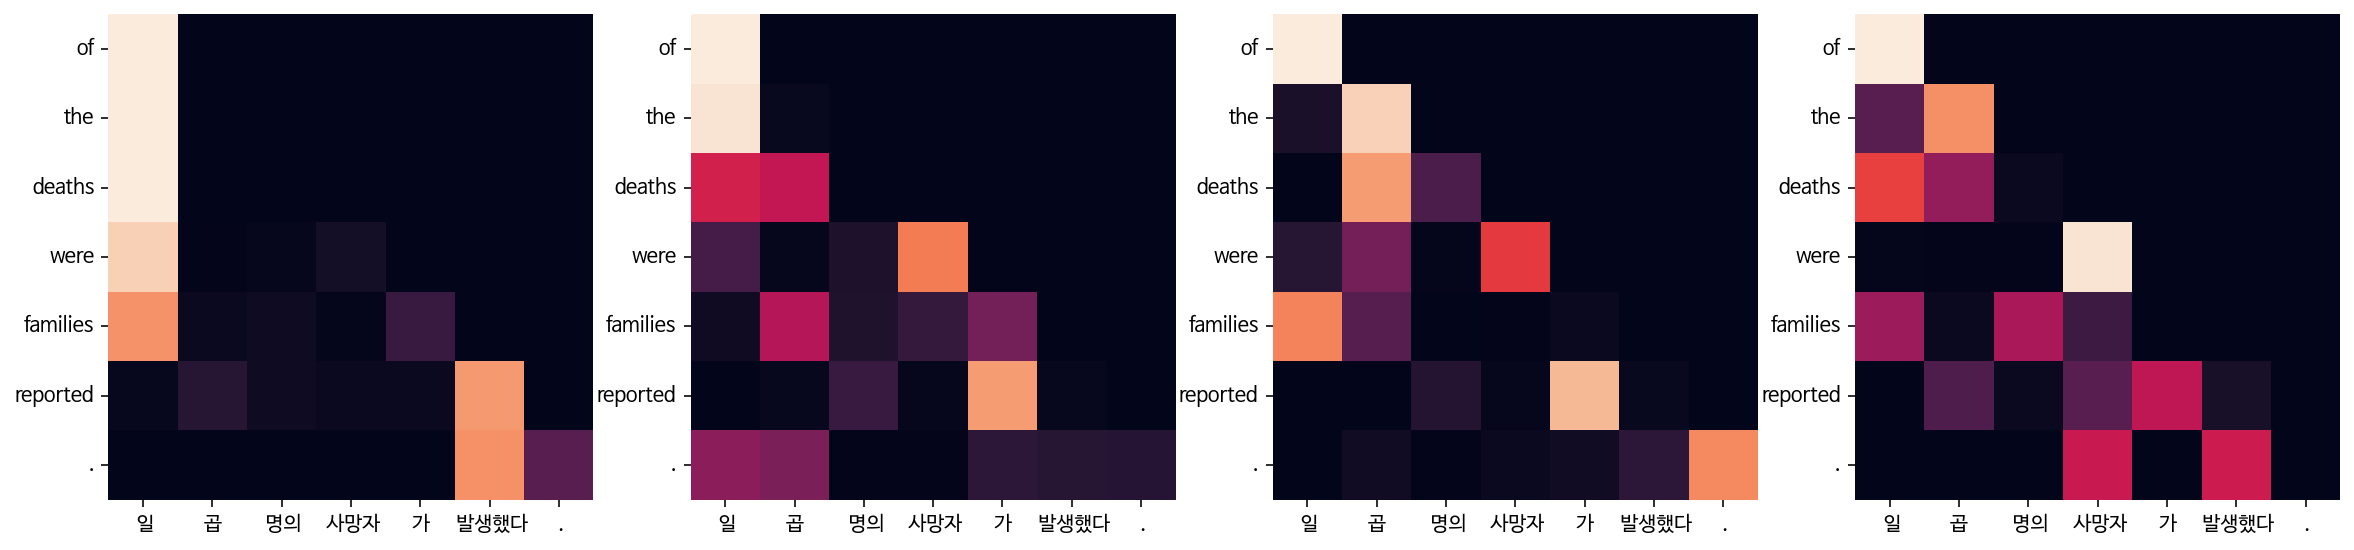

'of the deaths were families reported .'

In [51]:
translate(examples[3], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

In [54]:
# Continue training from the last epoch
start = 30
additional_epochs = 10
loss_history, translates = train_and_translate(transformer, optimizer, enc_train, dec_train, ko_tokenizer, en_tokenizer, additional_epochs, BATCH_SIZE, examples, INTERVAL, start_epoch=start, loss_history=loss_history, translates=translates)

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 35 Translations: ['obama is in office .', 'the city s bag marks the city .', 'the only cheap coffee holds relatively few coffee .', 'that number of people were killed , but the second person killed .']


  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 40 Translations: ['obama was in a wonderful way .', 'the city reopened a city .', 'the only cup .', 'nine people have been killed in the sluggish village of michigan .']


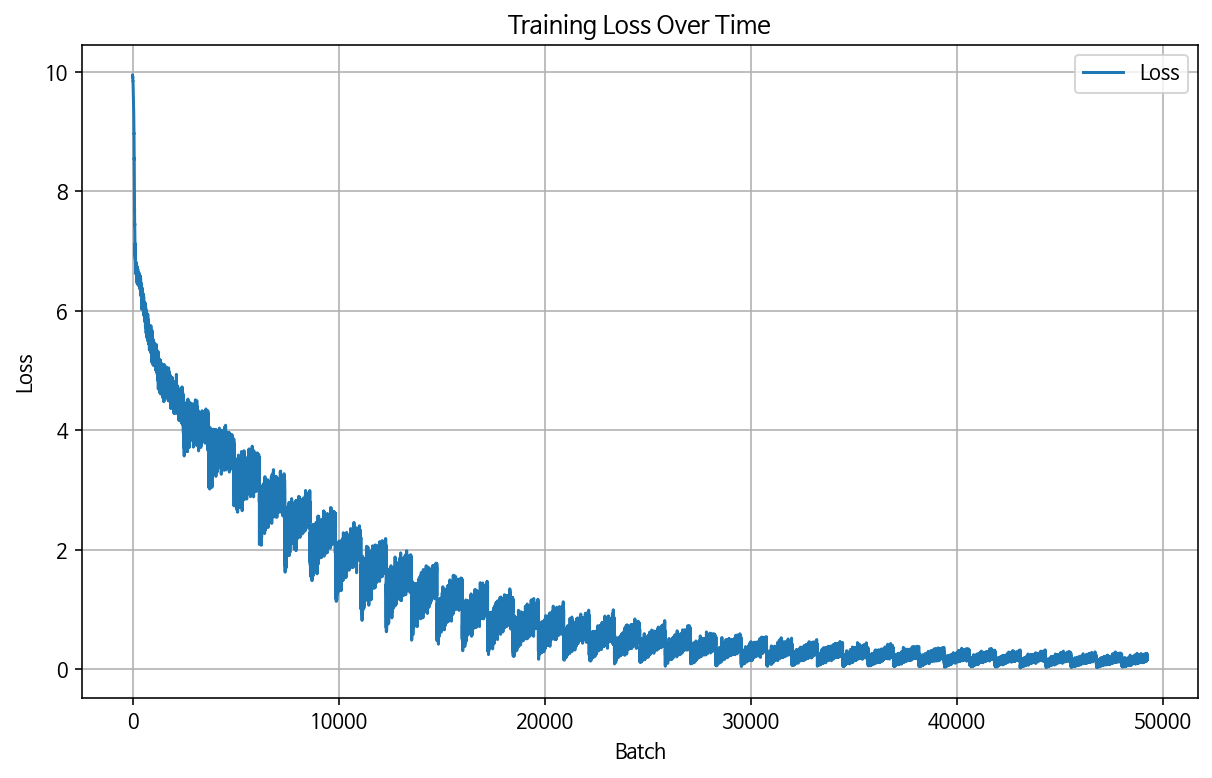

In [55]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

Encoder Layer 1


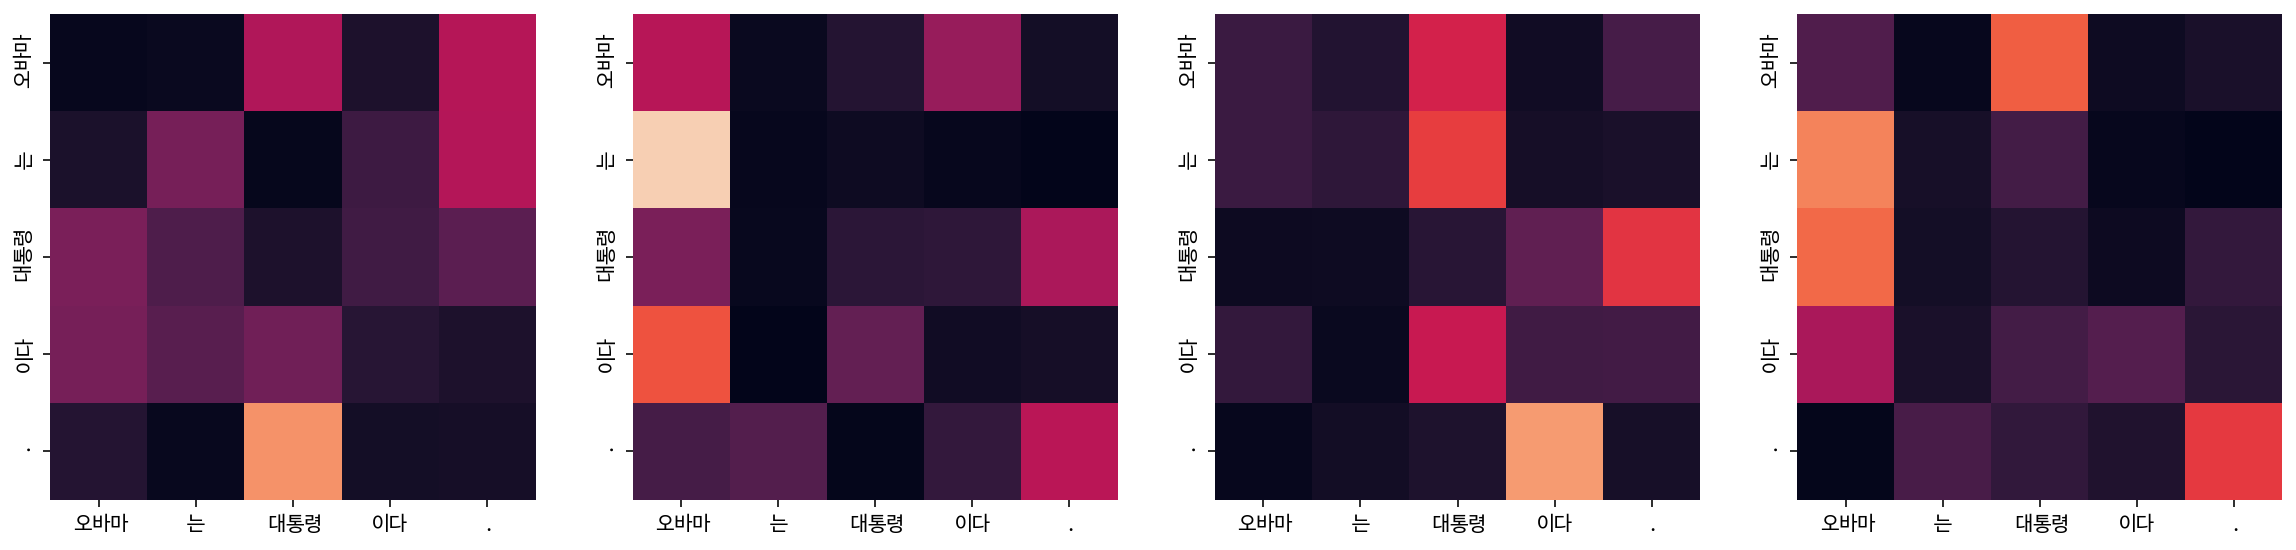

Encoder Layer 2


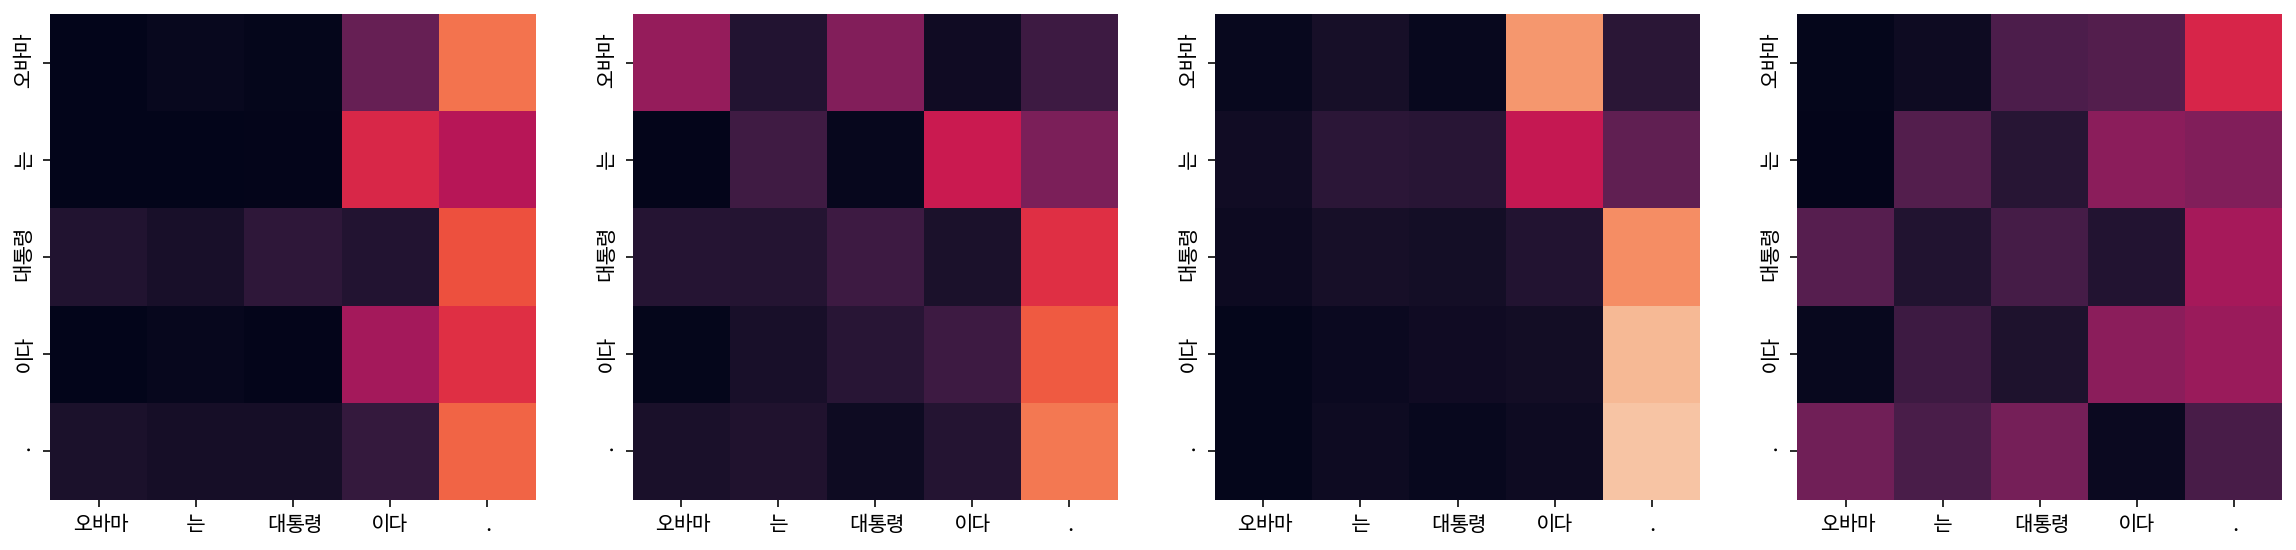

Decoder Self Layer 1


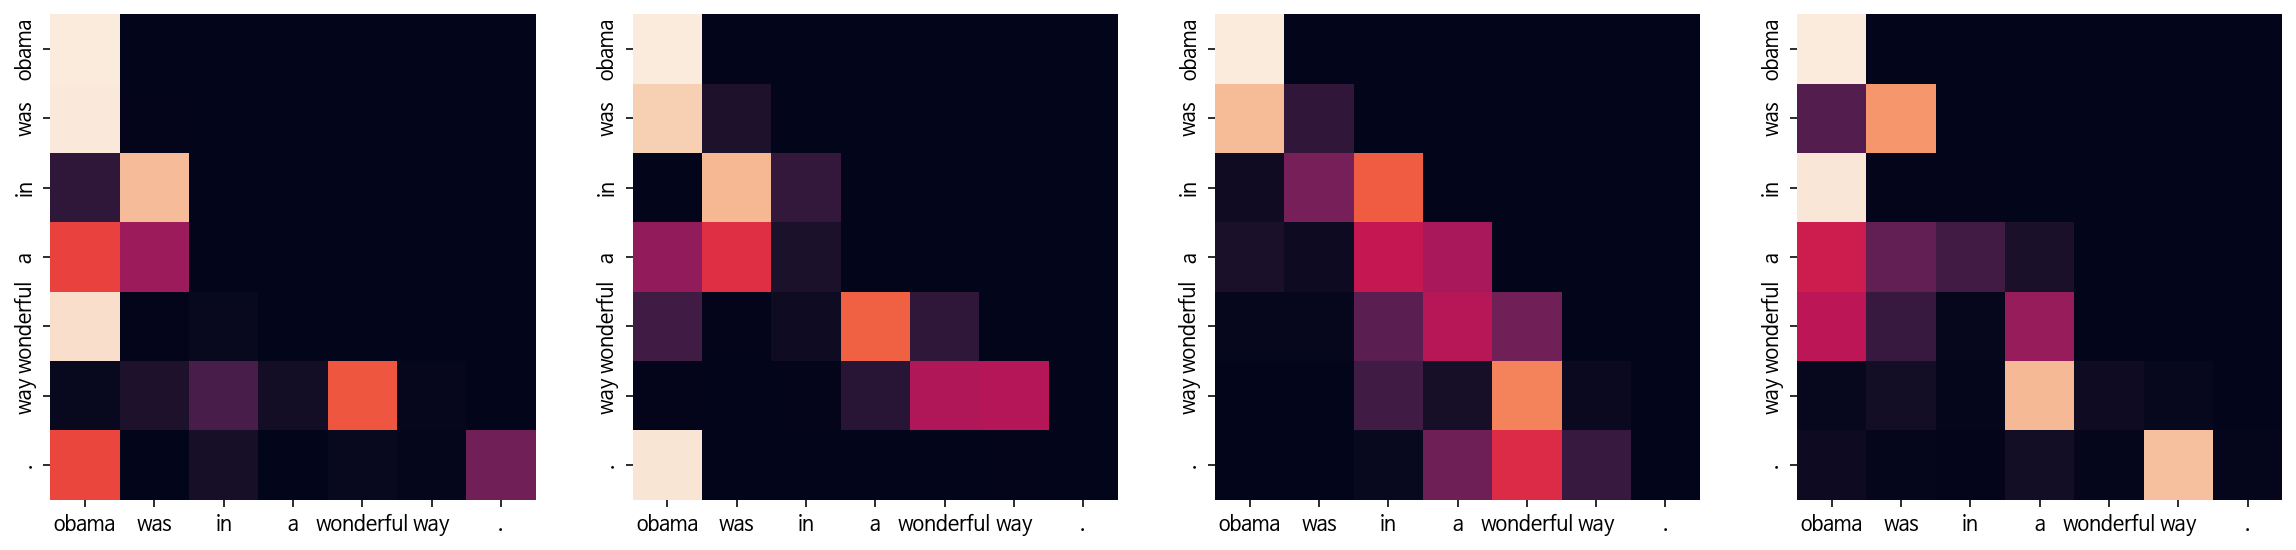

Decoder Src Layer 1


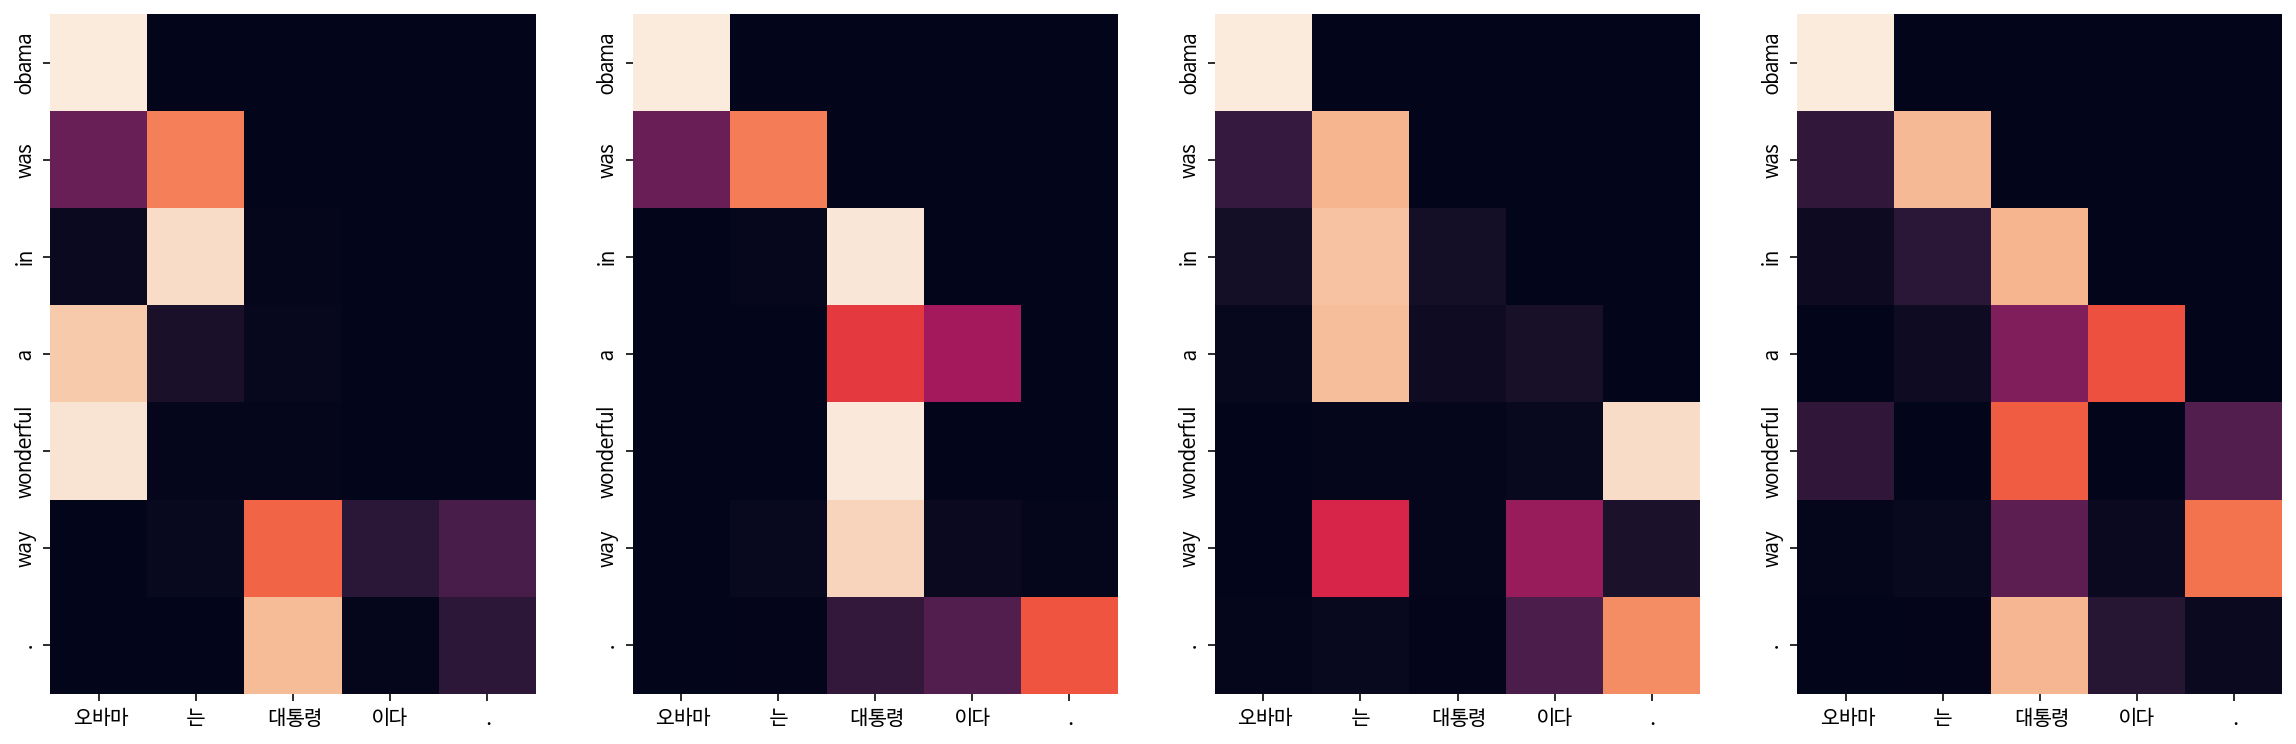

Decoder Self Layer 2


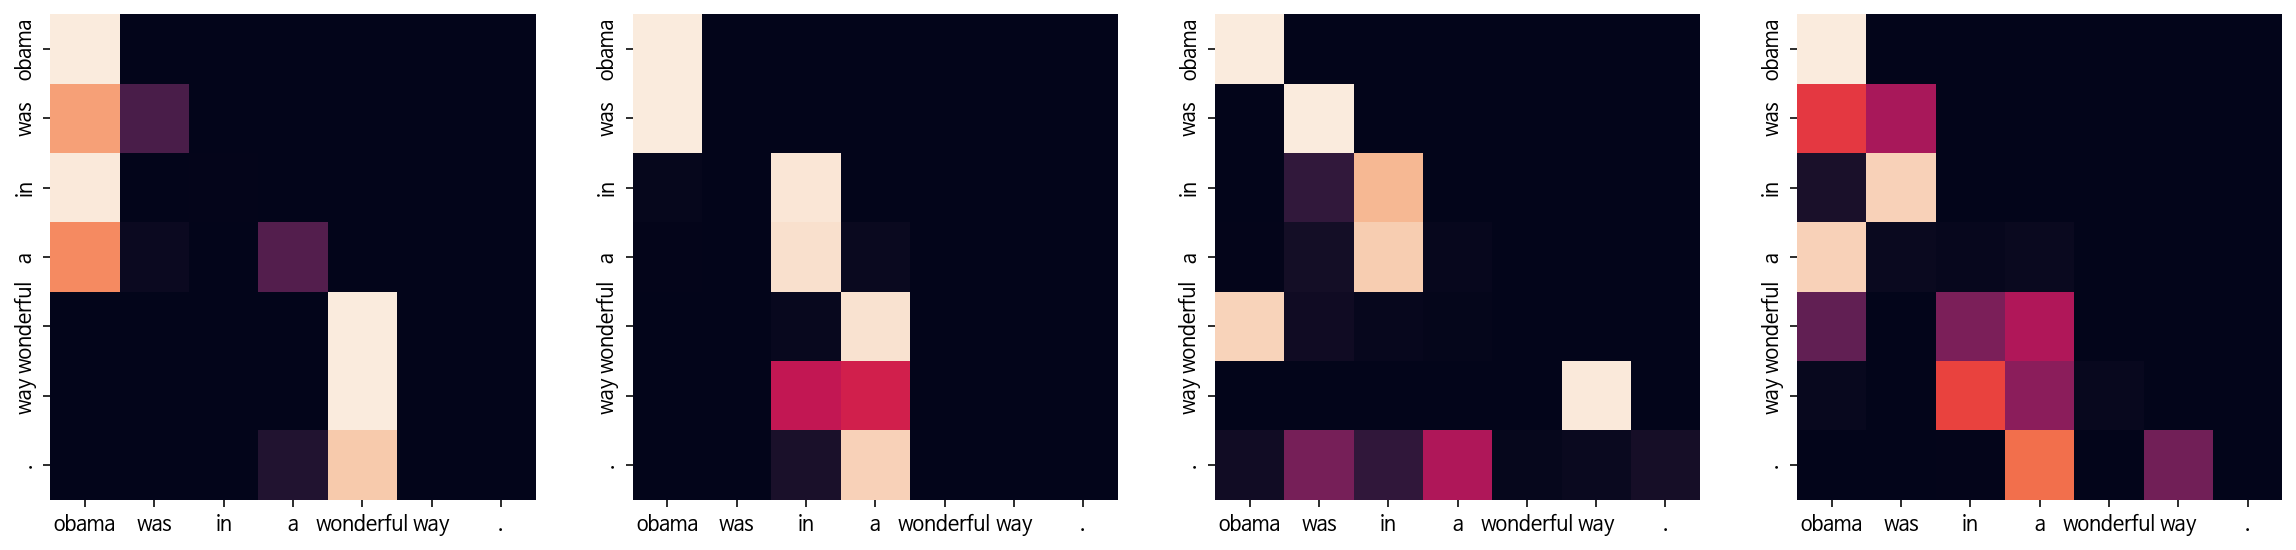

Decoder Src Layer 2


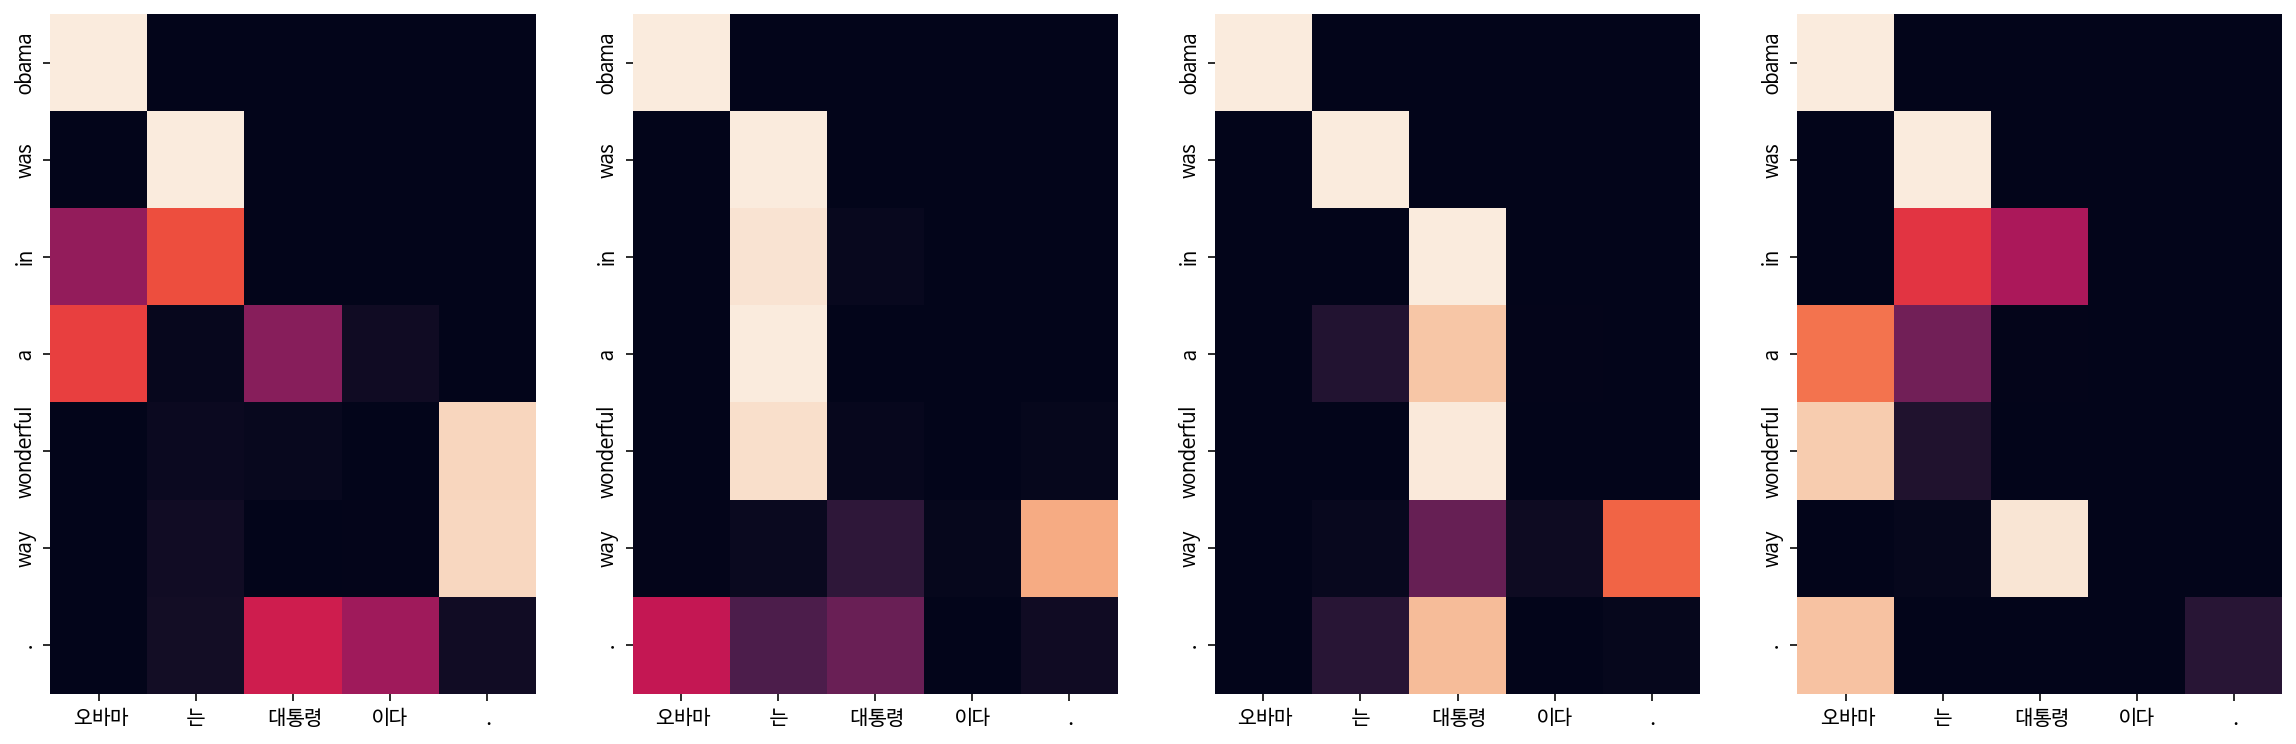

'obama was in a wonderful way .'

In [58]:
translate(examples[0], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


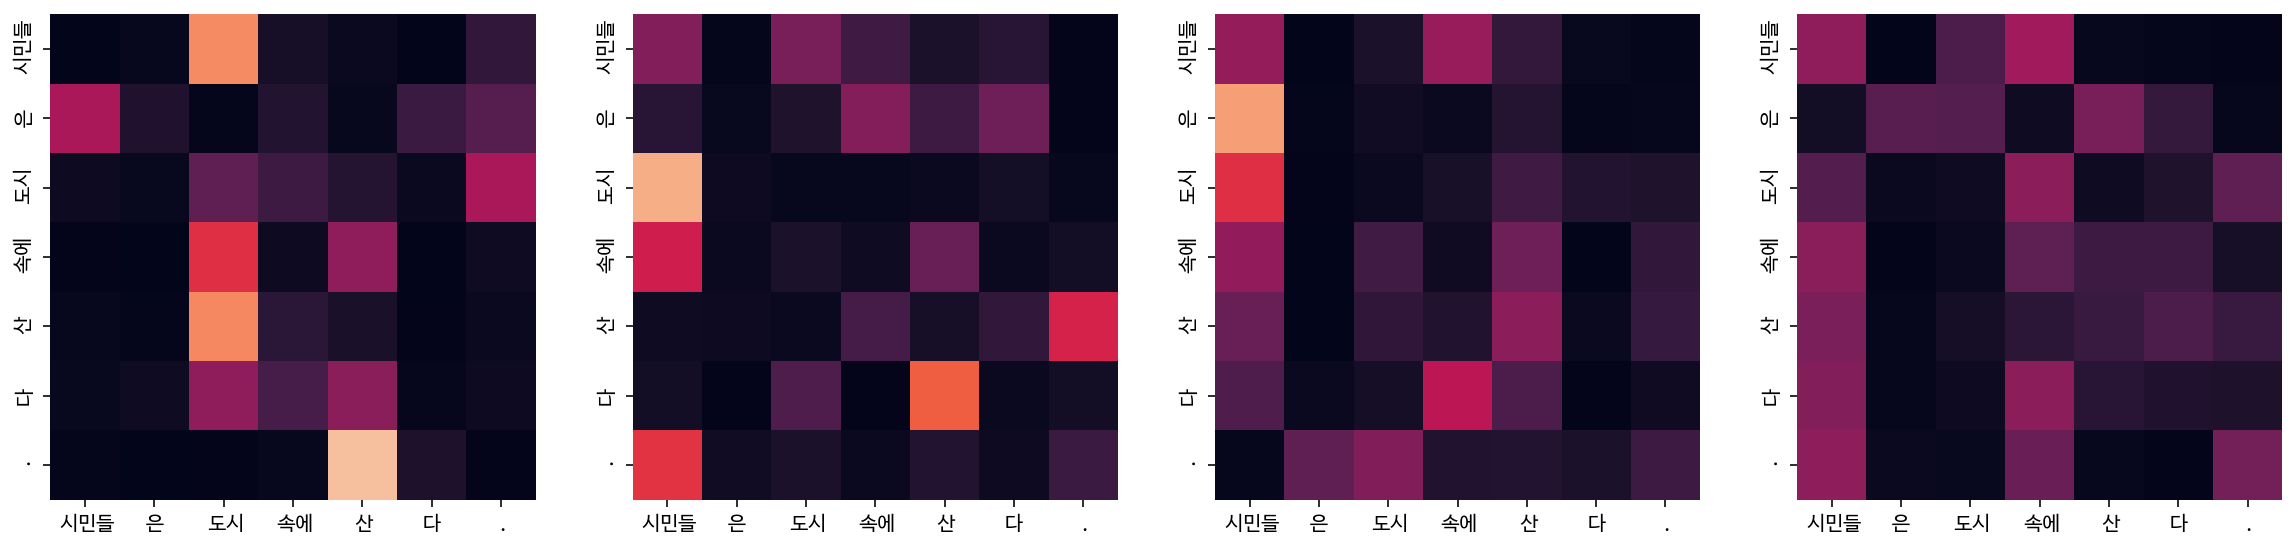

Encoder Layer 2


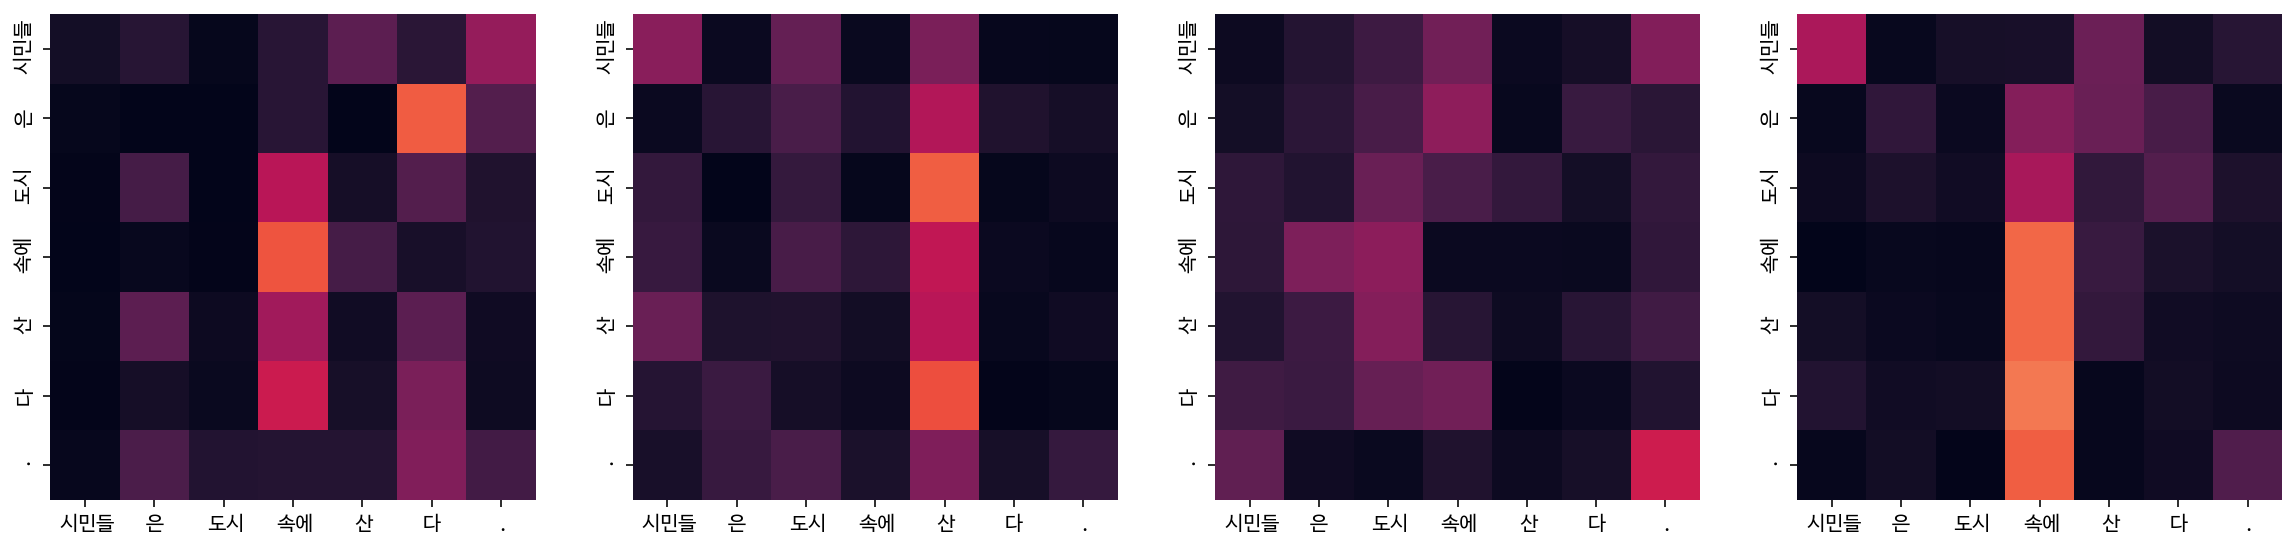

Decoder Self Layer 1


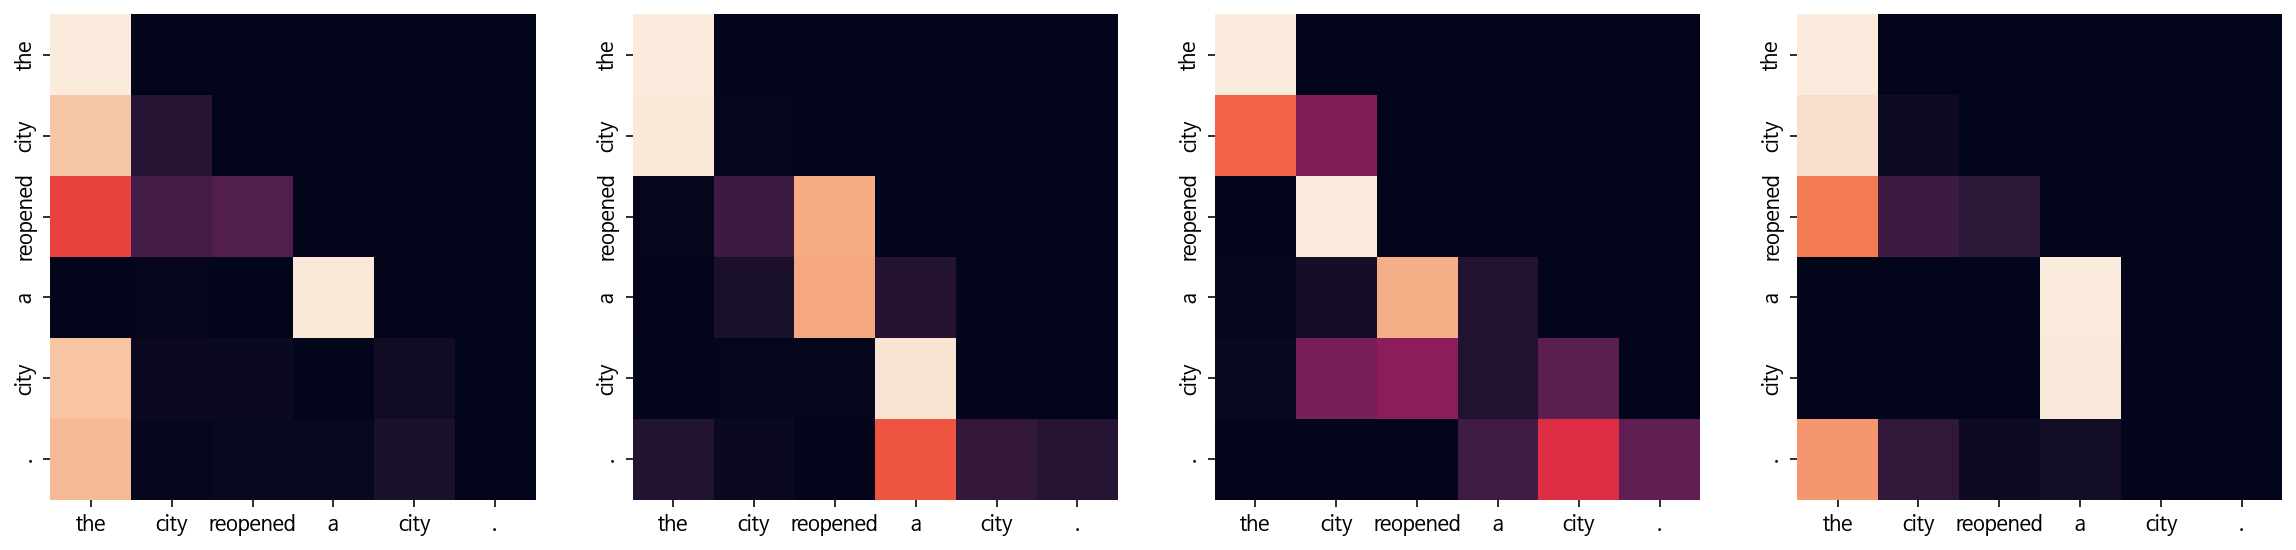

Decoder Src Layer 1


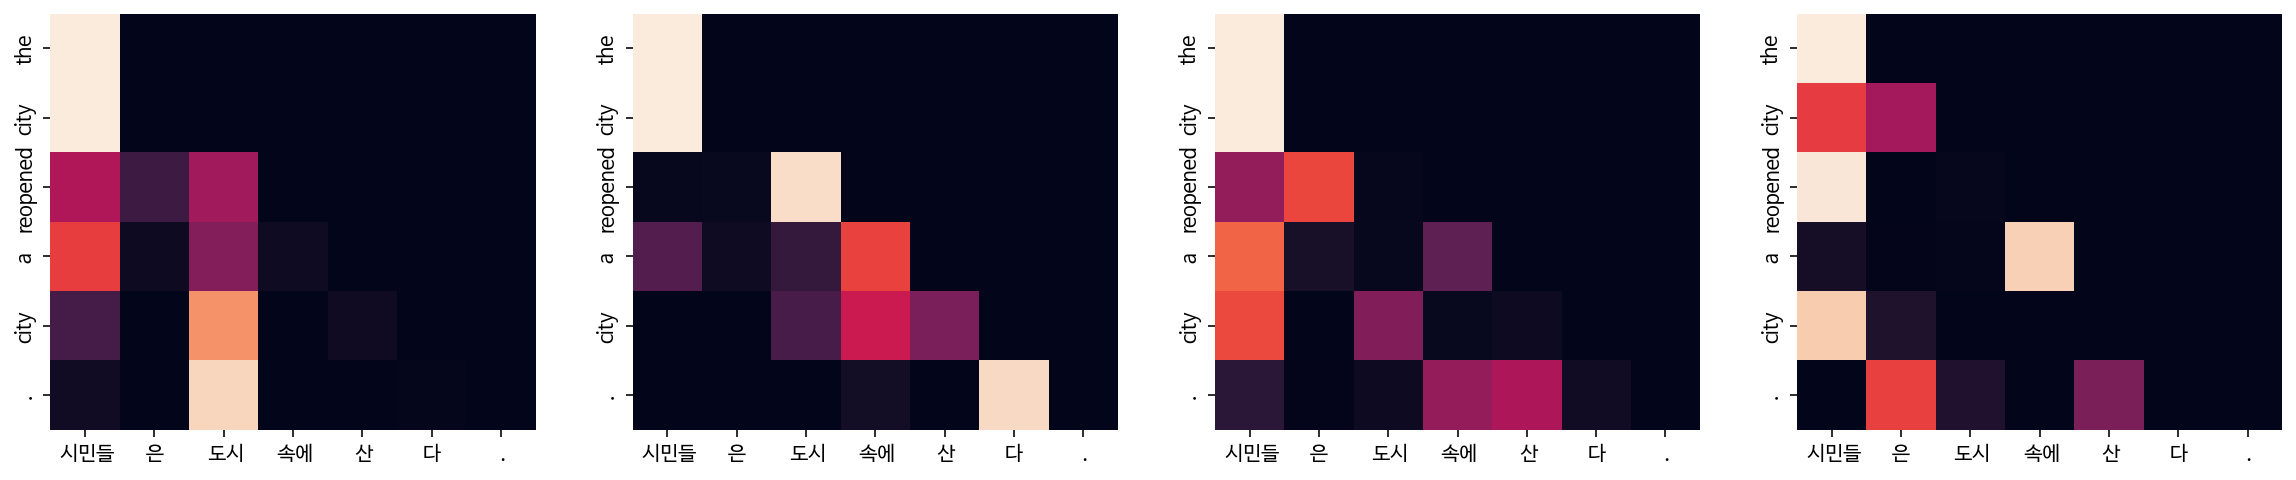

Decoder Self Layer 2


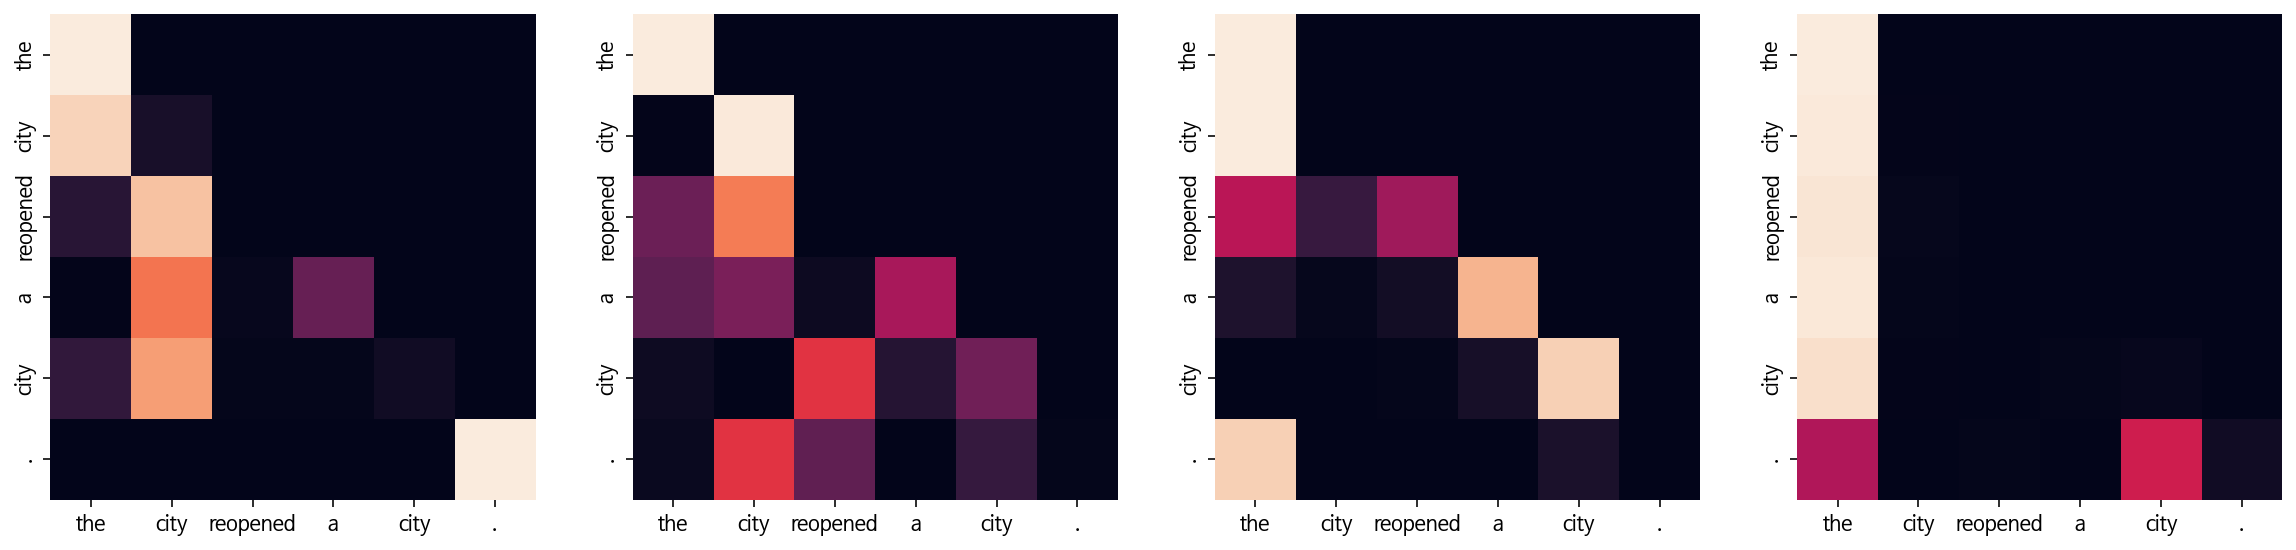

Decoder Src Layer 2


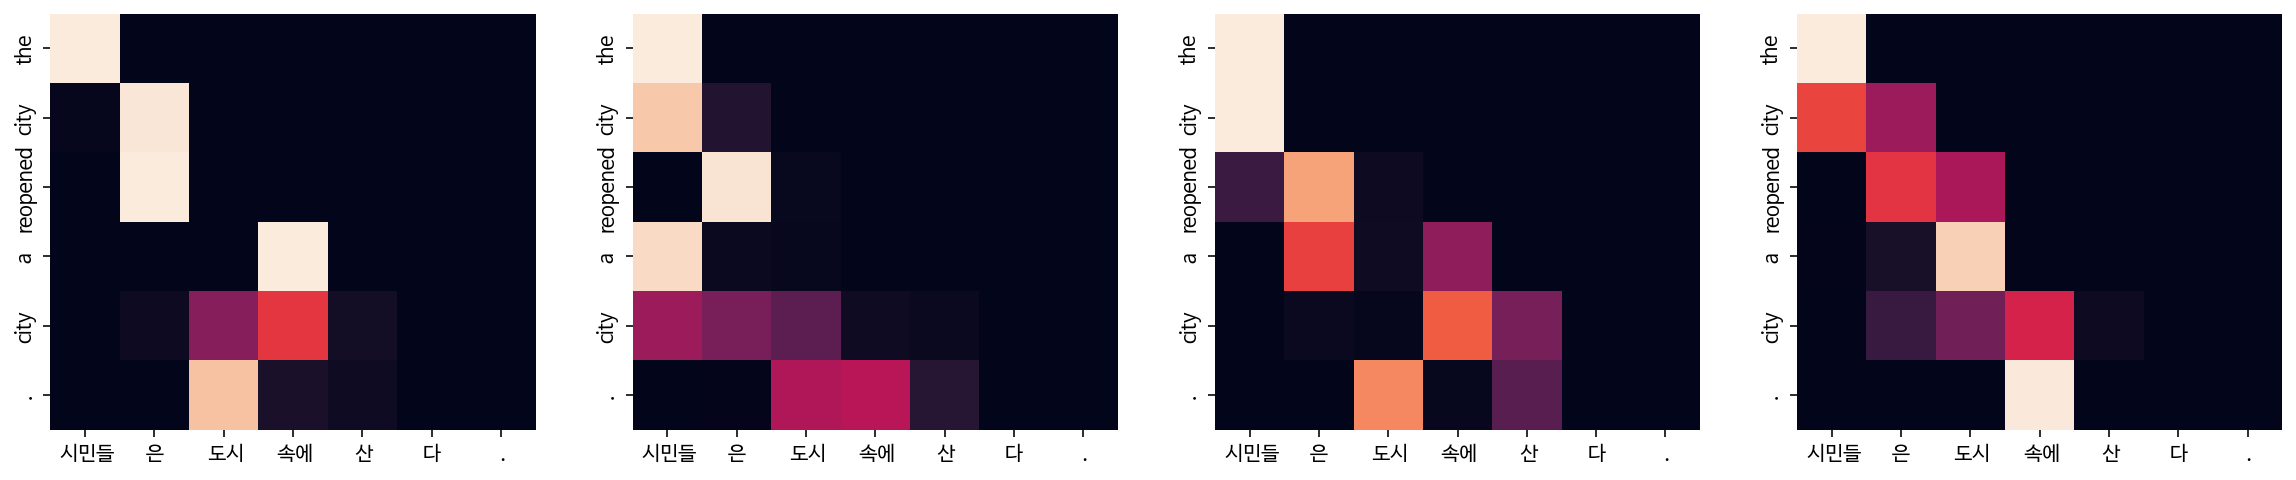

'the city reopened a city .'

In [59]:
translate(examples[1], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


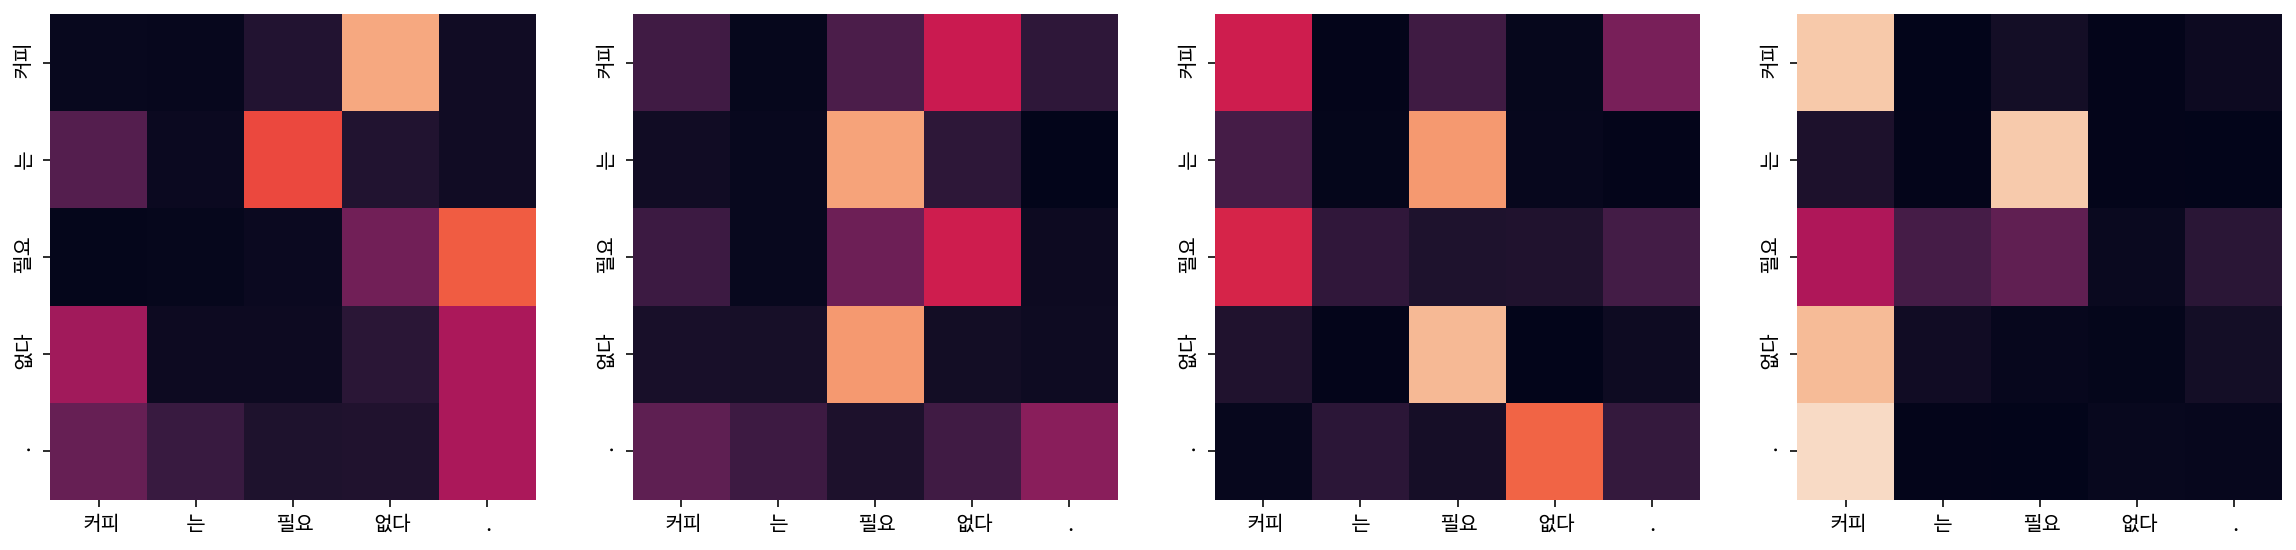

Encoder Layer 2


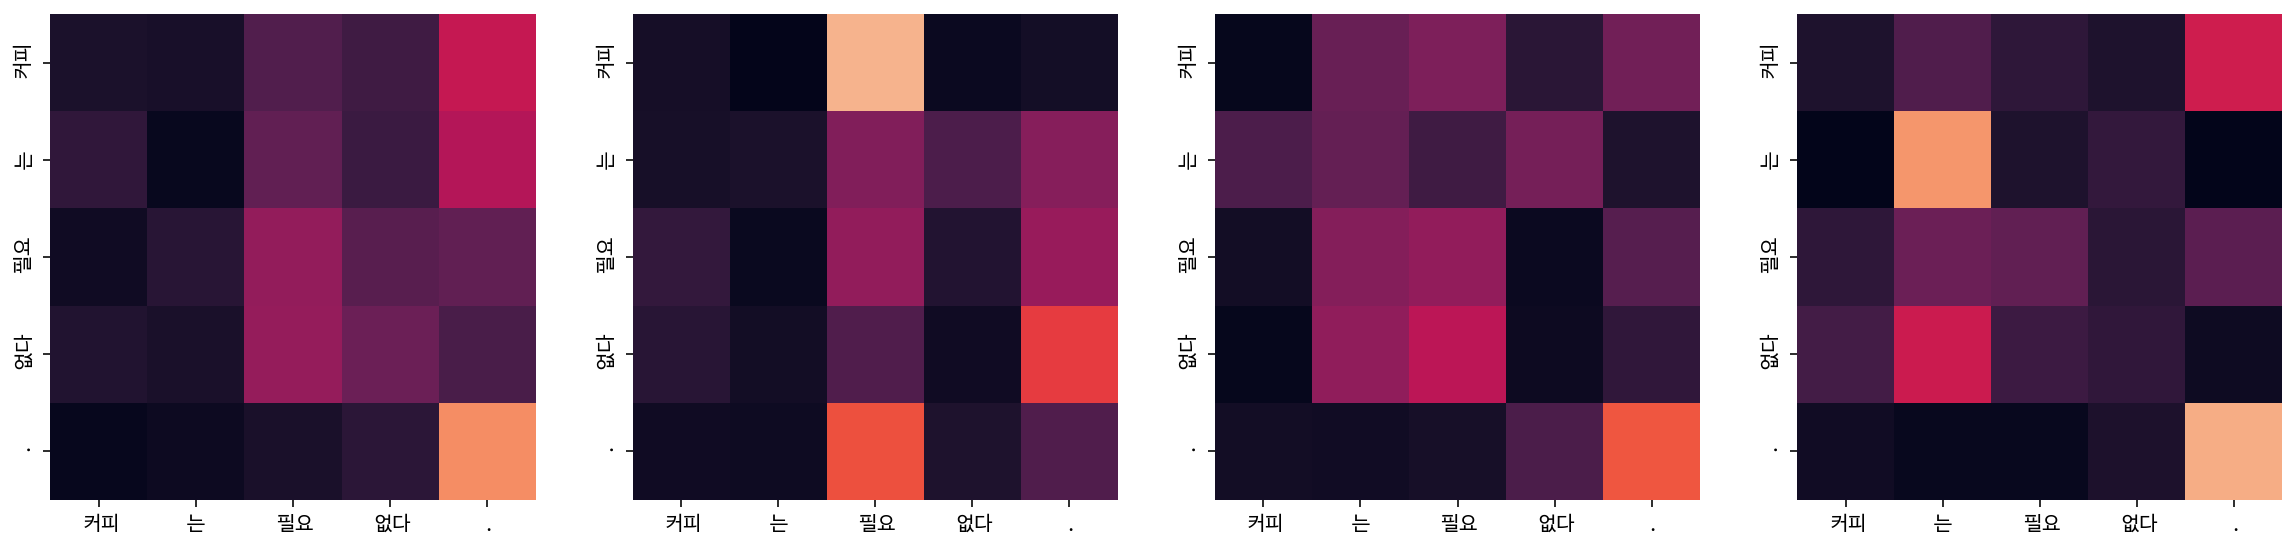

Decoder Self Layer 1


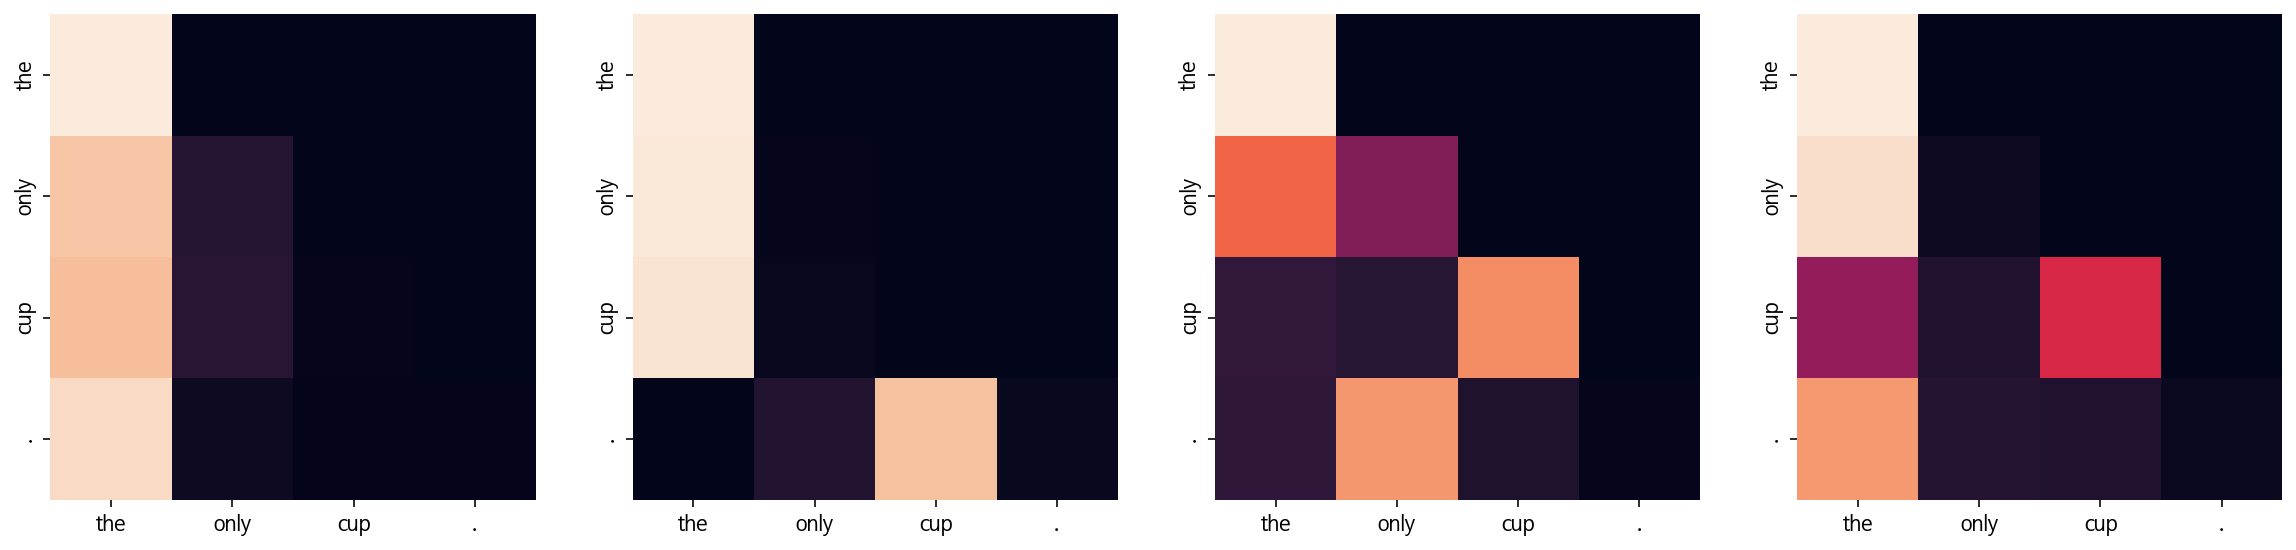

Decoder Src Layer 1


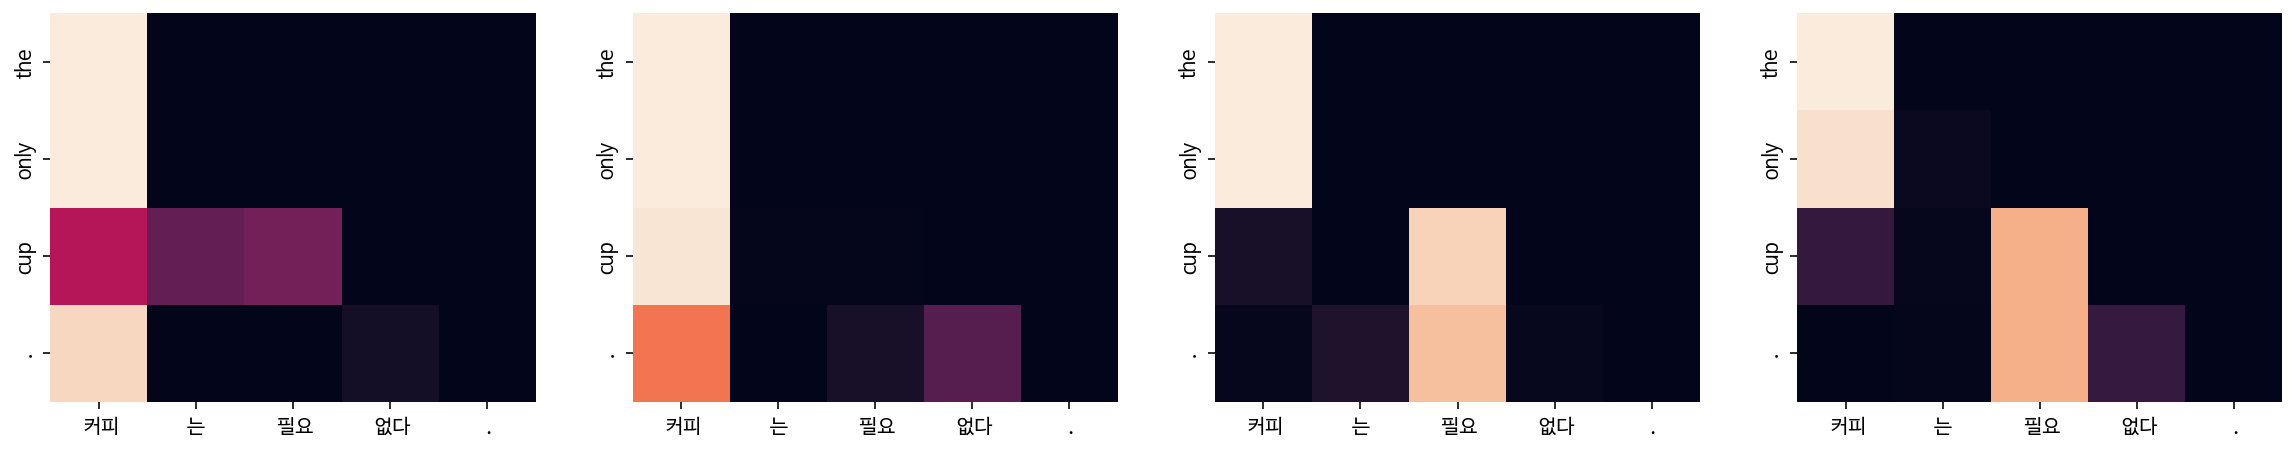

Decoder Self Layer 2


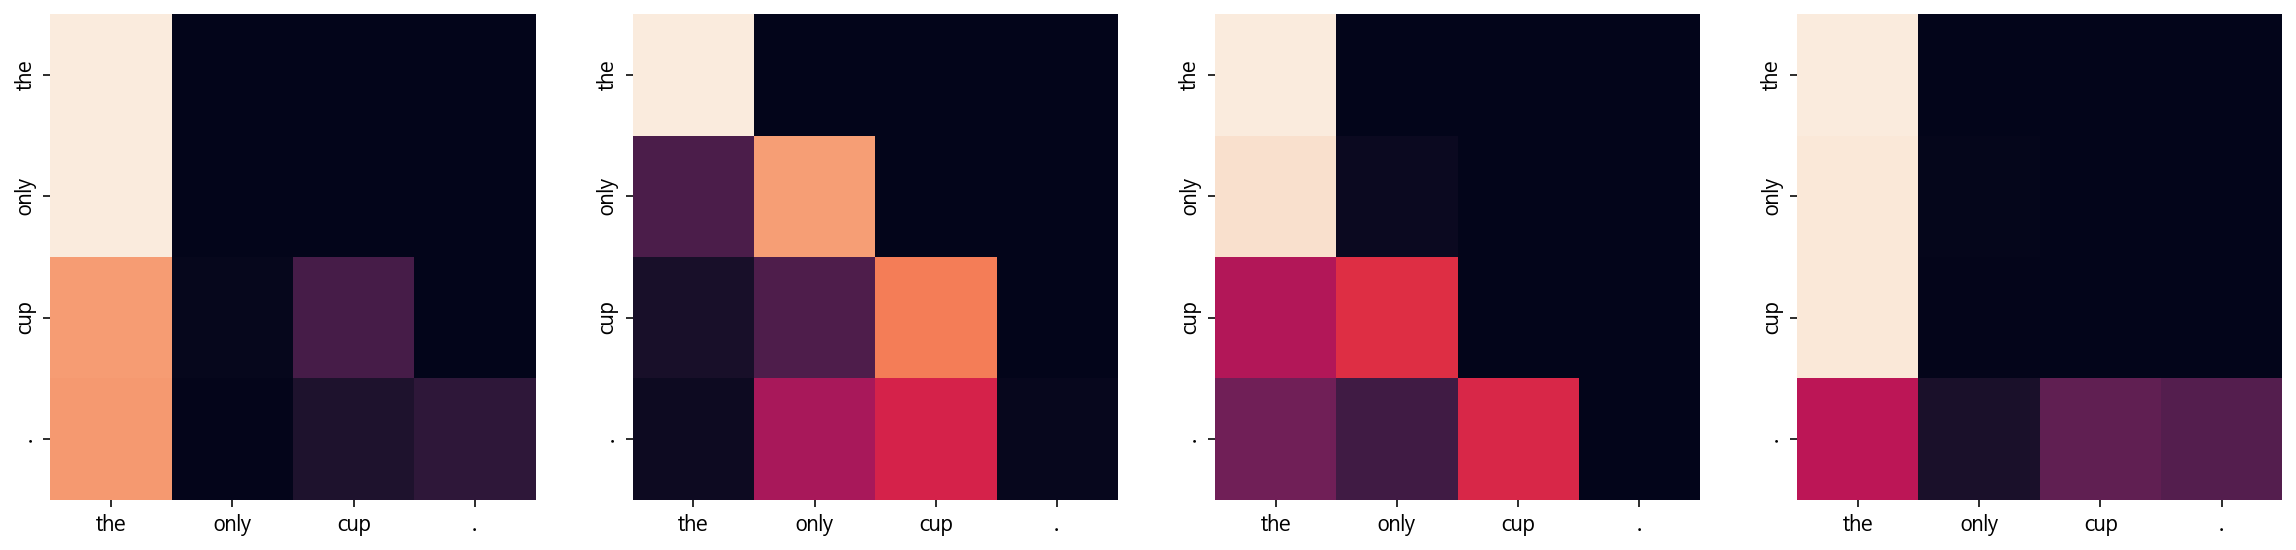

Decoder Src Layer 2


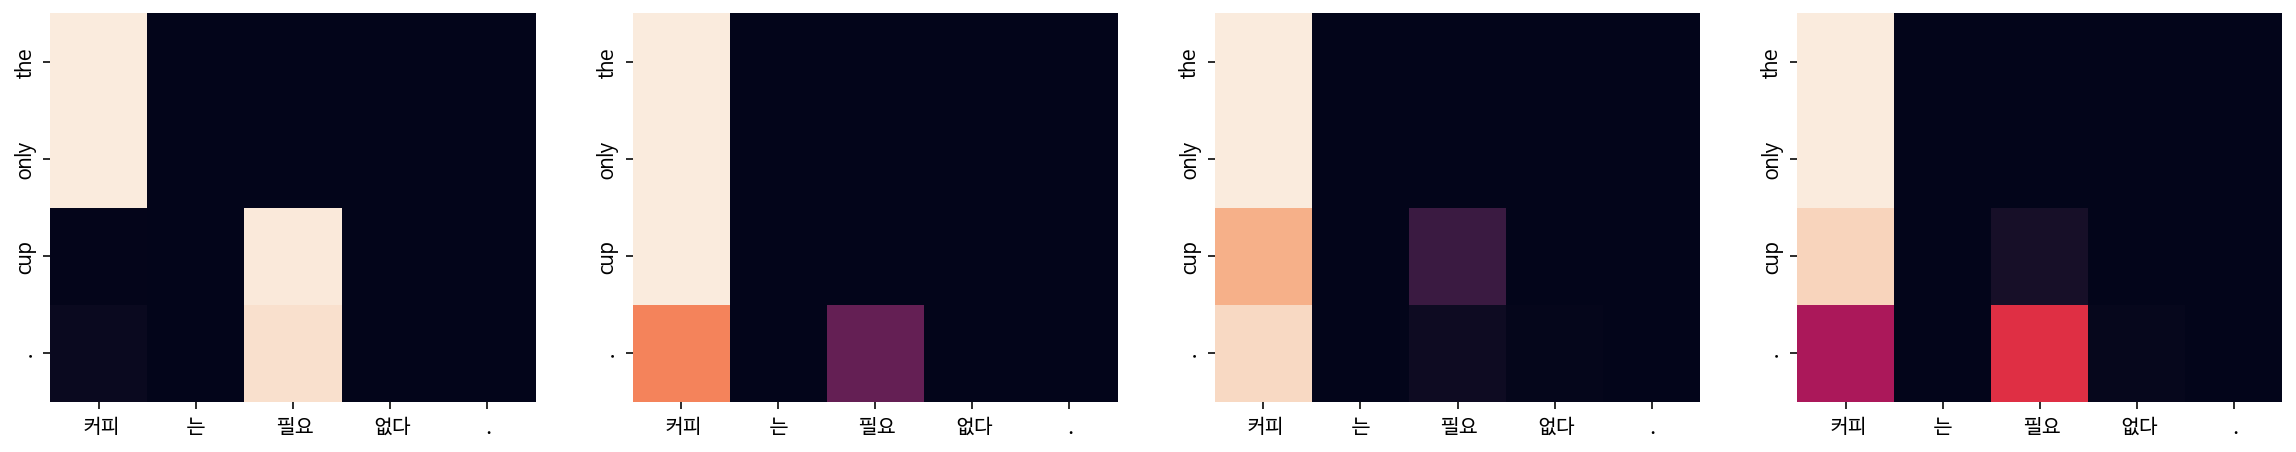

'the only cup .'

In [60]:
translate(examples[2], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


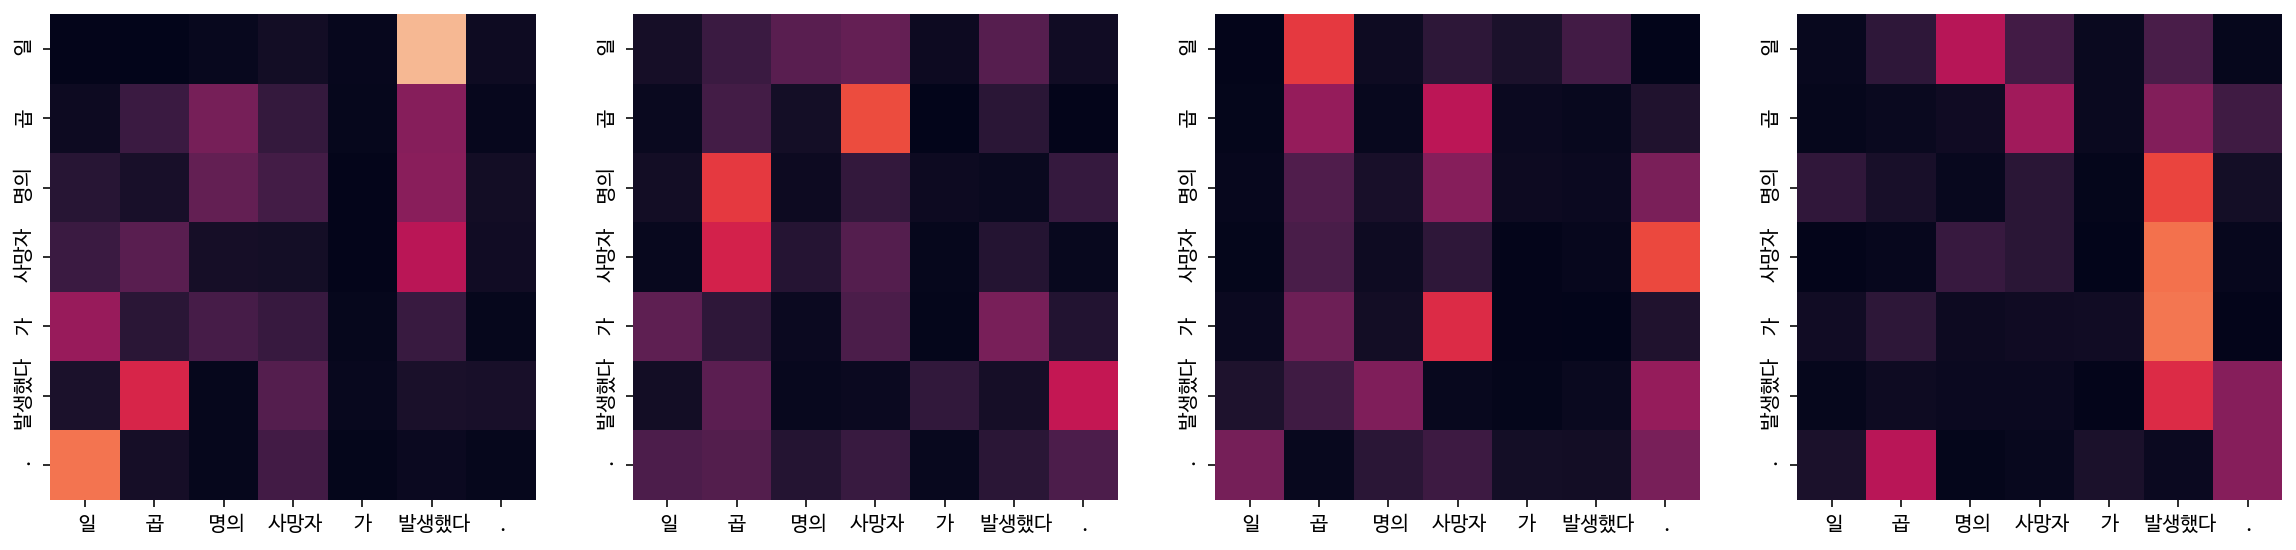

Encoder Layer 2


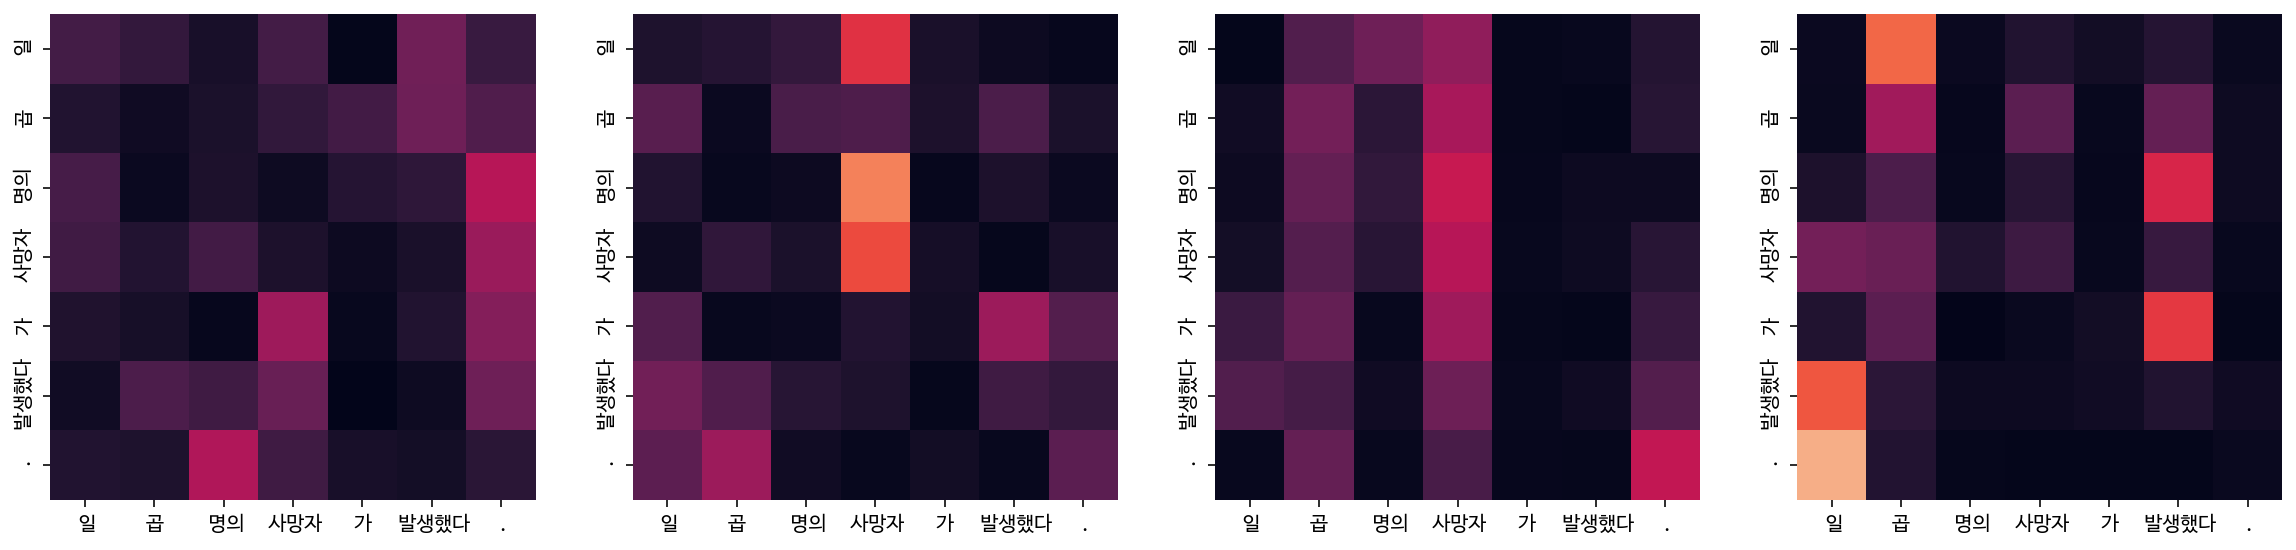

Decoder Self Layer 1


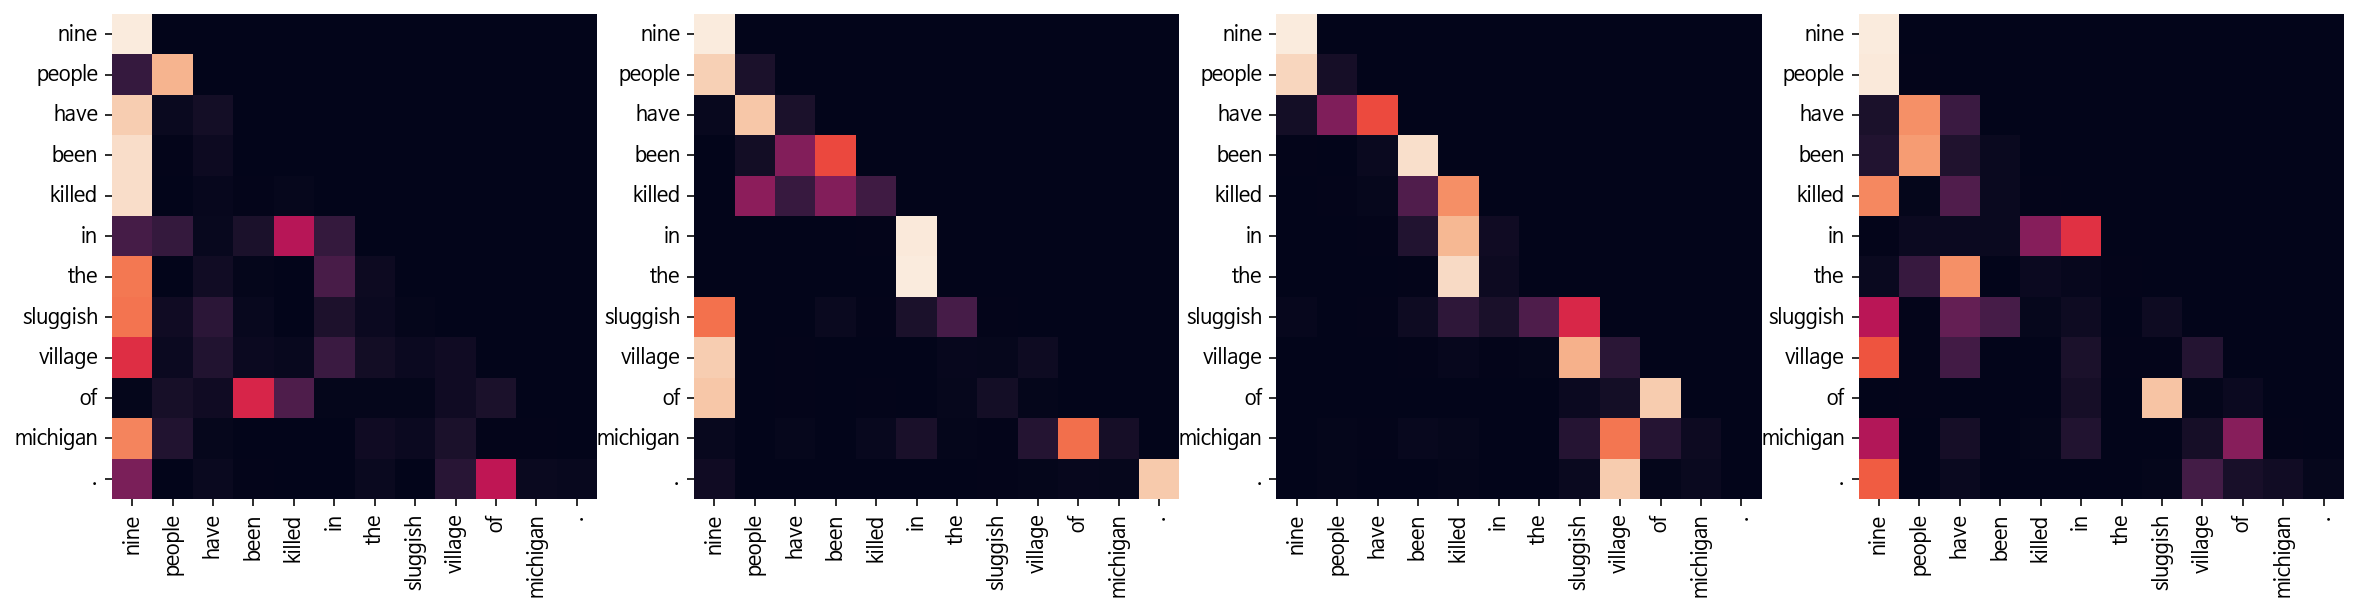

Decoder Src Layer 1


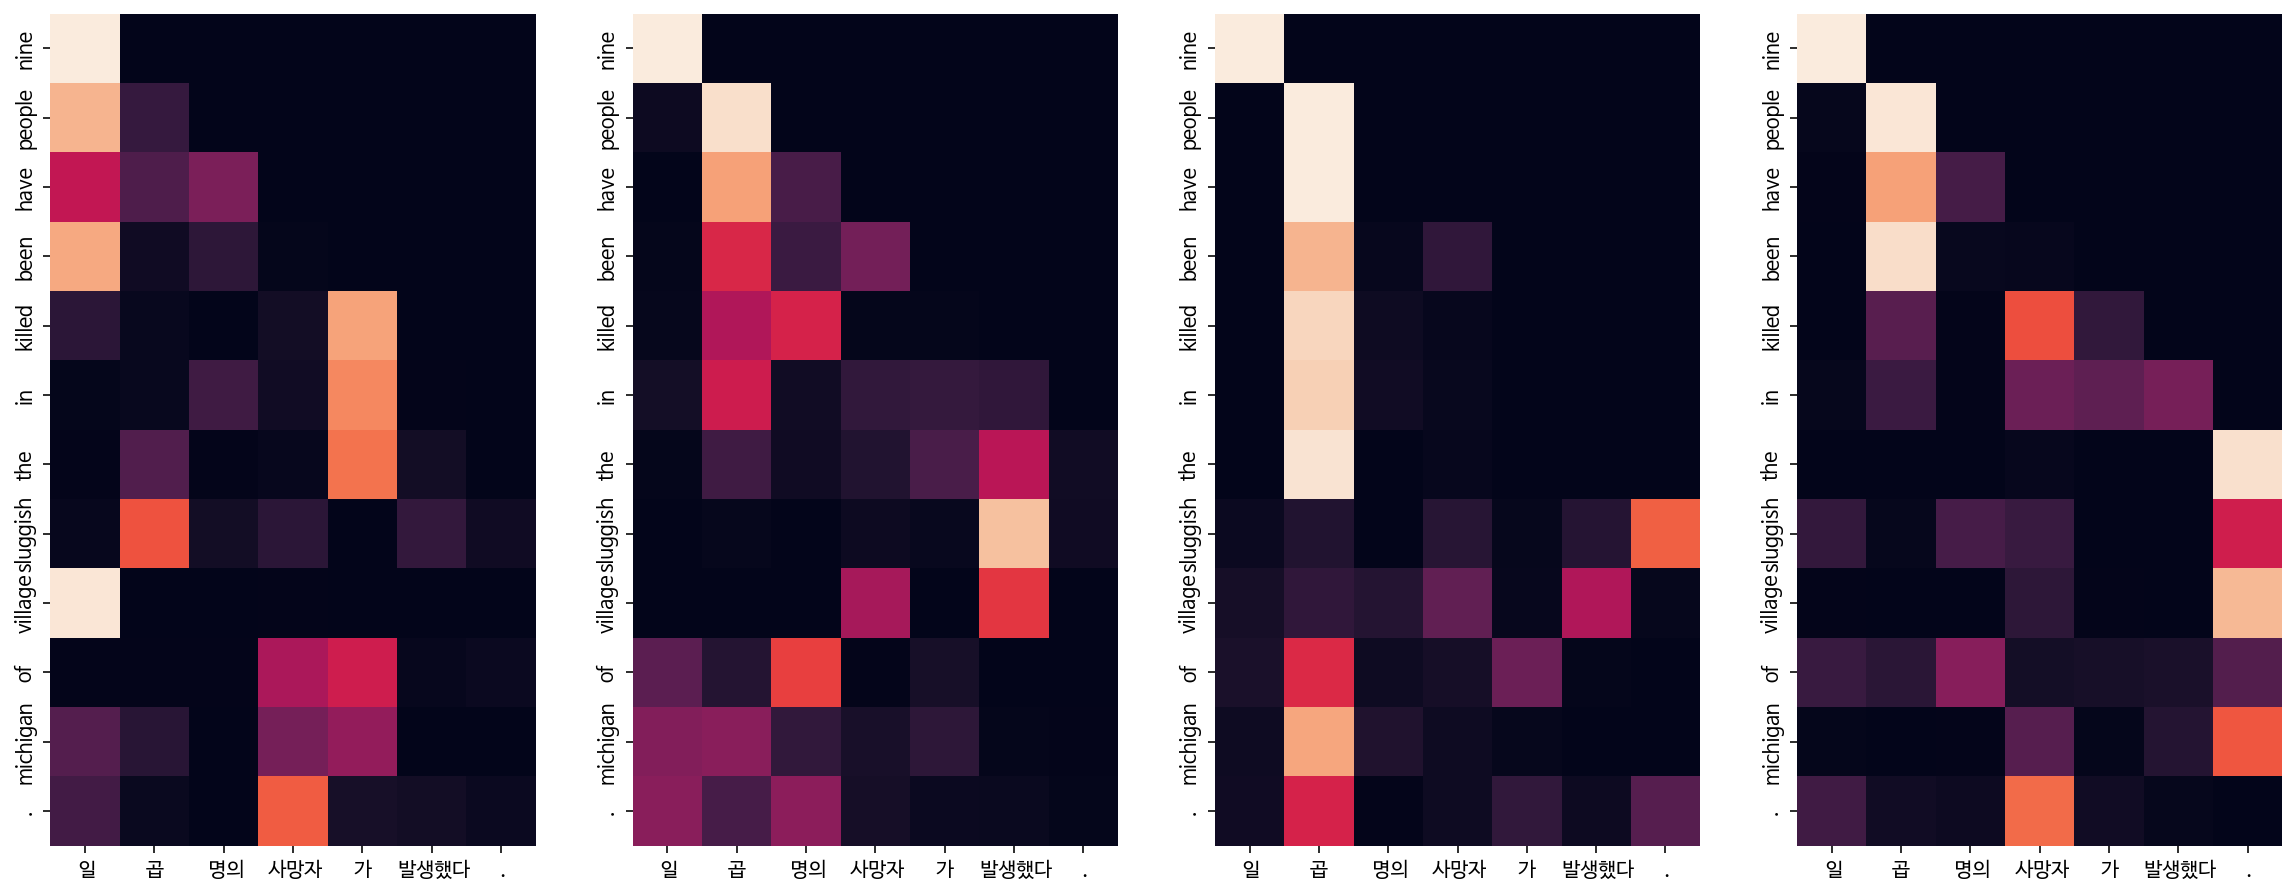

Decoder Self Layer 2


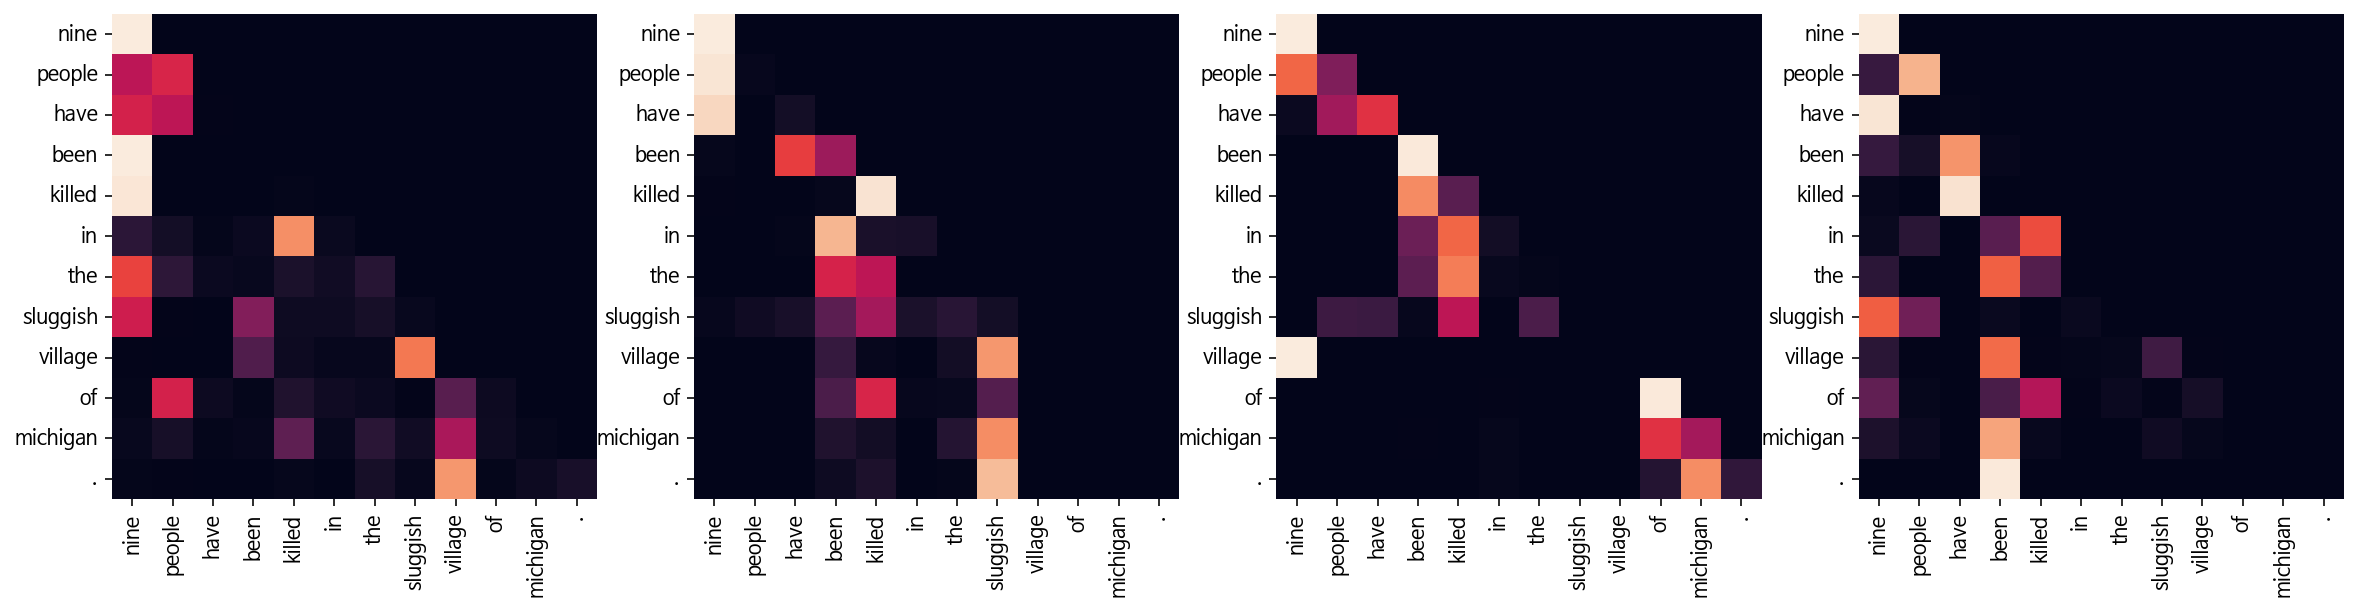

Decoder Src Layer 2


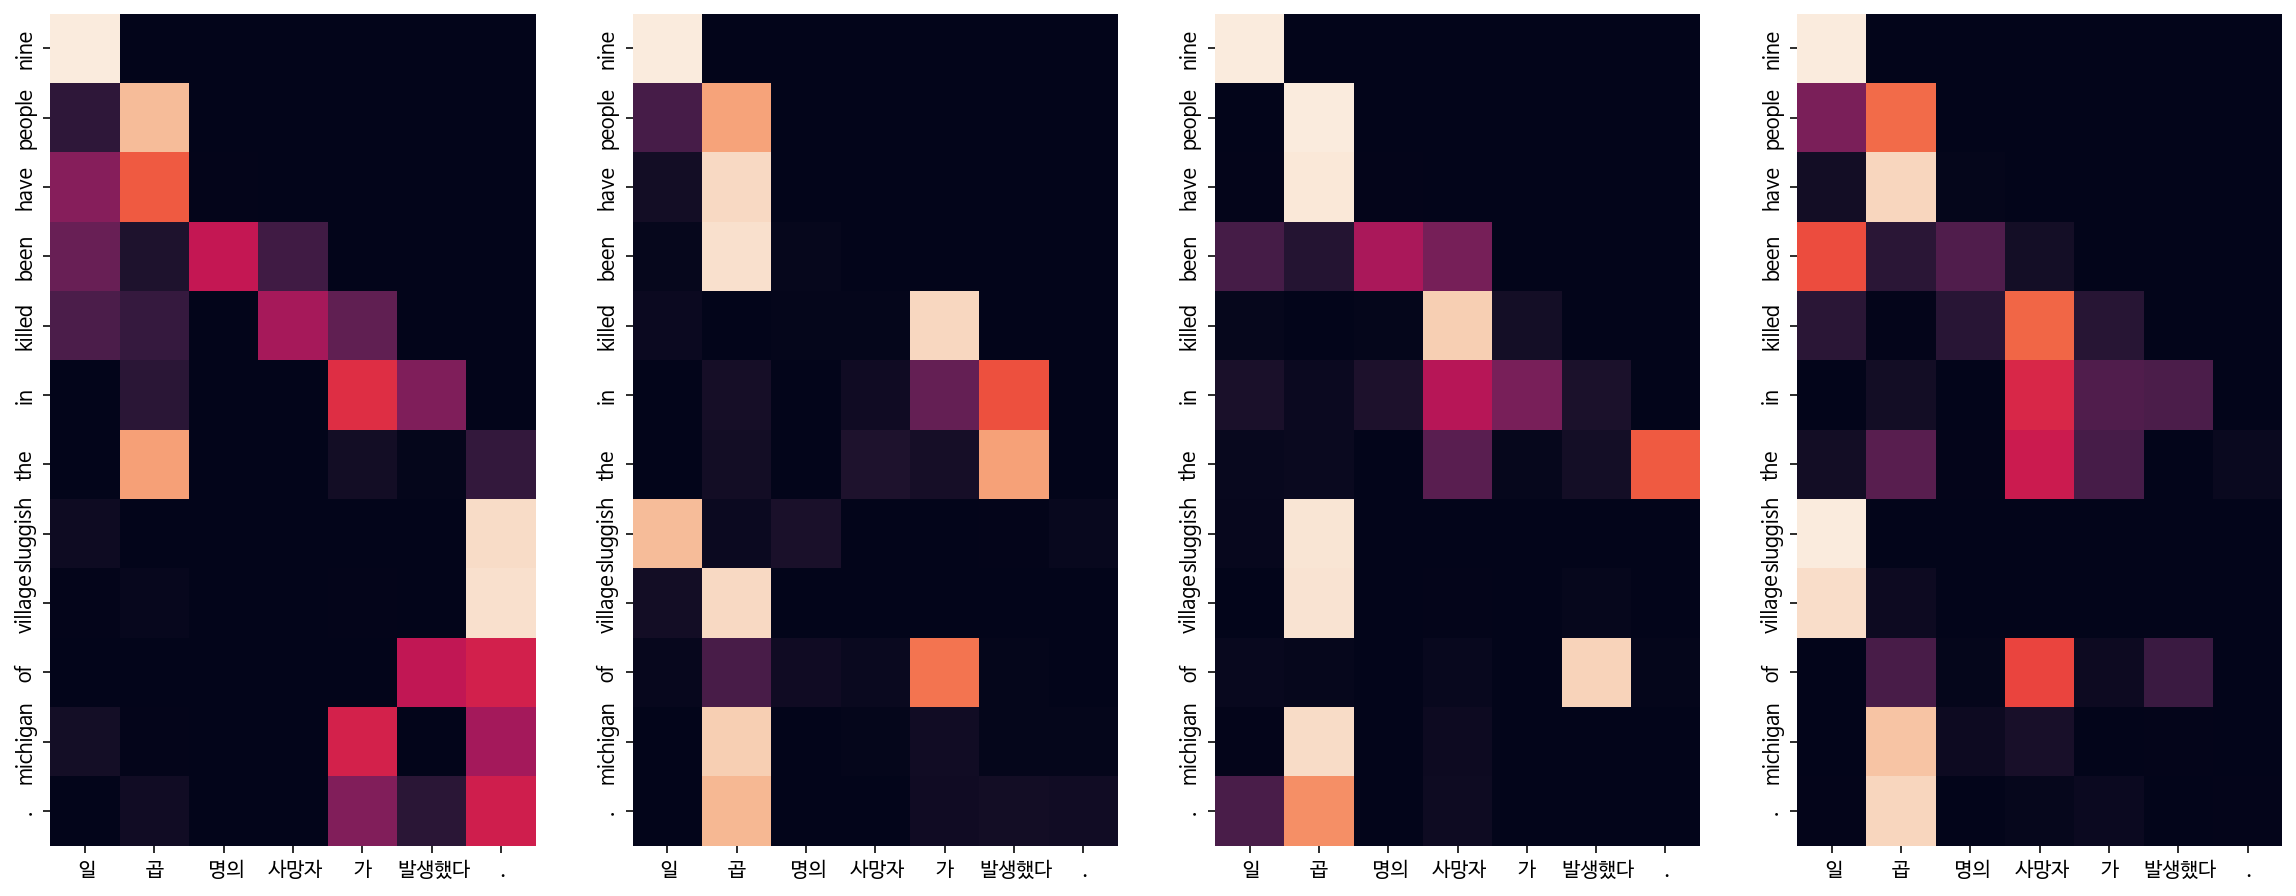

'nine people have been killed in the sluggish village of michigan .'

In [61]:
translate(examples[3], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

## 실험 결과

In [64]:
import pandas as pd

In [72]:
results = pd.DataFrame(translates, columns=['epoch','sentences'])
results = pd.DataFrame(results.sentences.to_list(), columns=['sent1','sent2','sent3','sent4'])

In [94]:
results.shape

(40, 4)

In [79]:
examples

['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [101]:
print(f'문장 : {examples[0]} \n ->', end=' ')
print('\n -> '.join(results.sent1.tolist()[::5]))

문장 : 오바마는 대통령이다. 
 -> obama s obama is a new president elect .
 -> obama is in the presidential race .
 -> obama takes him into office .
 -> obama is president of illinois .
 -> obama holds a presidential primary .
 -> obama won t be president .
 -> obama was a president .
 -> they obama released a presidential candidate for obama .


In [102]:
print(f'문장 : {examples[1]} \n ->', end=' ')
print('\n -> '.join(results.sent2.tolist()[::5]))

문장 : 시민들은 도시 속에 산다. 
 -> the first time of the first time .
 -> the city s city is home .
 -> the city s city is a city of brown moammar .
 -> the city streets are crowds who st . city .
 -> the city quicklyest rested with a city .
 -> the city of connecticut , who sought a city on the city s upside disperse with a crowd months ago .
 -> the city s old city is home to the city .
 -> the city s mayor is home to the city .


In [103]:
print(f'문장 : {examples[2]} \n ->', end=' ')
print('\n -> '.join(results.sent3.tolist()[::5]))

문장 : 커피는 필요 없다. 
 -> it is a lot of the new york .
 -> coffee is a coffee .
 -> the coffee needs .
 -> the only journey without a requirement , nei requirementable .
 -> the only journey without a coffee .
 -> the only journey withoutoutout seal .
 -> the only east asiaized party without eastly cheap .
 -> the once governable party .


In [104]:
print(f'문장 : {examples[3]} \n ->', end=' ')
print('\n -> '.join(results.sent4.tolist()[::5]))

문장 : 일곱 명의 사망자가 발생했다. 
 -> the death tolls were killed in the death of the deaths .
 -> on tuesday , people were killed .
 -> on saturday , the state was killed .
 -> nine people were killed in tuesday s second death were reported .
 -> nine people have been killed .
 -> of the deaths were blamed , he said .
 -> that s four deaths have been killed , but the death toll bringing out reclusive leader days later .
 -> of the earthquake struck southwestern baghdad on tuesday , a february report said .


In [ ]:
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5

## parameter 변경 후 수행

In [107]:
N_LAYERS = 2       # 인코더와 디코더의 층의 개수
D_MODEL = 512     # 인코더와 디코더 내부 입, 출력의 고정 차원
N_HEADS = 8        # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 2048       # 피드 포워드 신경망의 은닉층의 크기
# src_vocab_size
# tgt_vocab_size,
POS_LEN = enc_train.shape[1]
DROPOUT = 0.5      #dropout
#shared

# SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

# Train Step 함수 정의
tf.keras.backend.clear_session()

transformer = Transformer(N_LAYERS,
                     D_MODEL,
                     N_HEADS,
                     UNITS,
                     SRC_VOCAB_SIZE,
                     TGT_VOCAB_SIZE,
                     POS_LEN,
                     dropout=DROPOUT,
                     shared=True)

In [108]:
BATCH_SIZE = 64
EPOCHS = 10
INTERVAL = 5

loss_history, translates = train_and_translate(transformer, optimizer, enc_train, dec_train, ko_tokenizer, en_tokenizer, EPOCHS, BATCH_SIZE, examples, INTERVAL)

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 5
Translations: 
> obama is the president .
> the city is the city s urbana .
> no needs to be a larger needs to be a coffee .
> the death toll from the top of the death toll .


  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 10
Translations: 
> obama is approaching .
> the city is the city s mountain to see the mountain .
> need need need things a need too .
> six died sunday from the carous .


Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


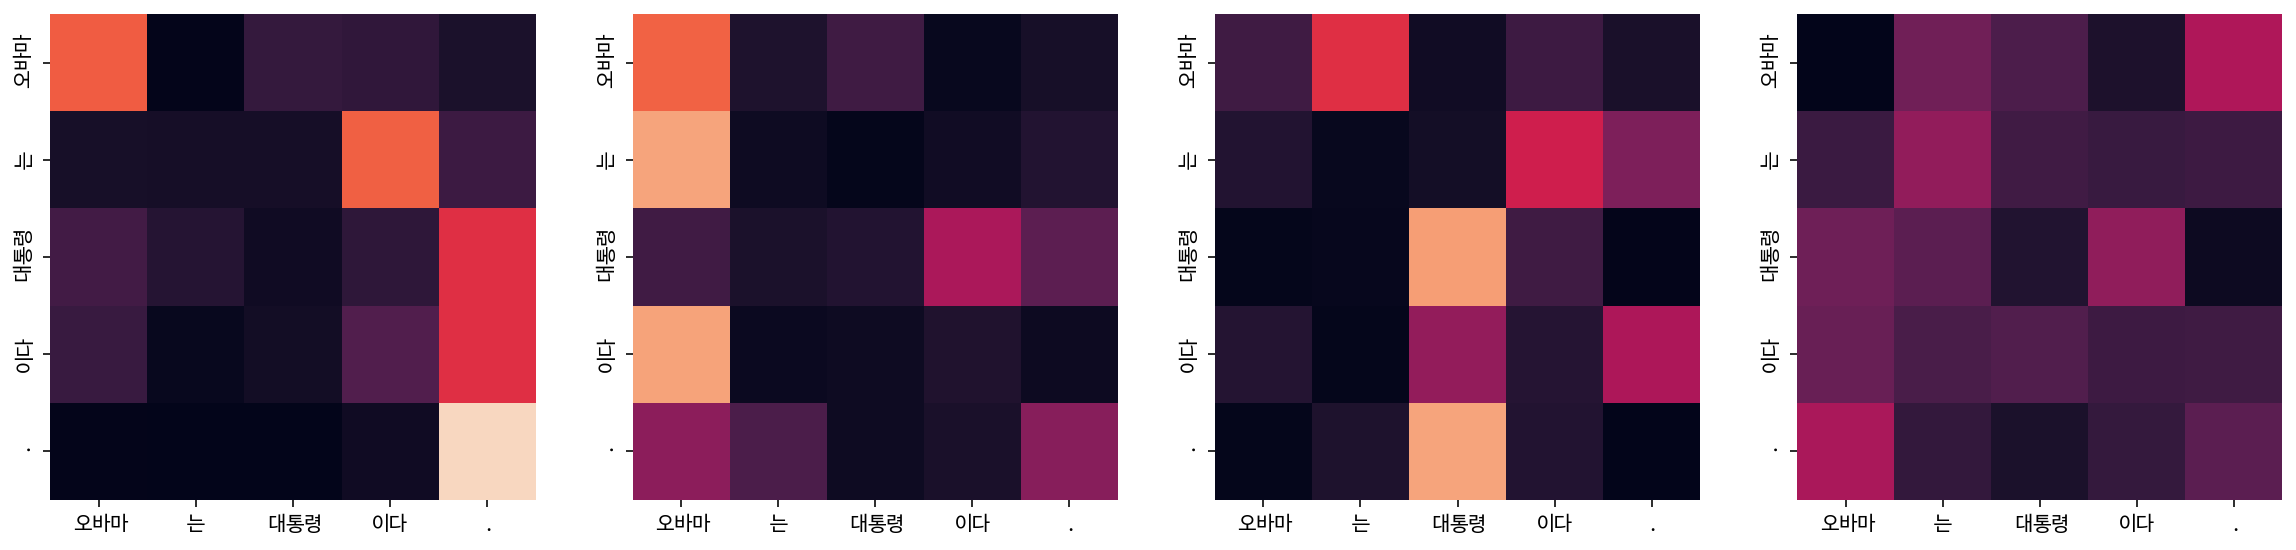

Encoder Layer 2


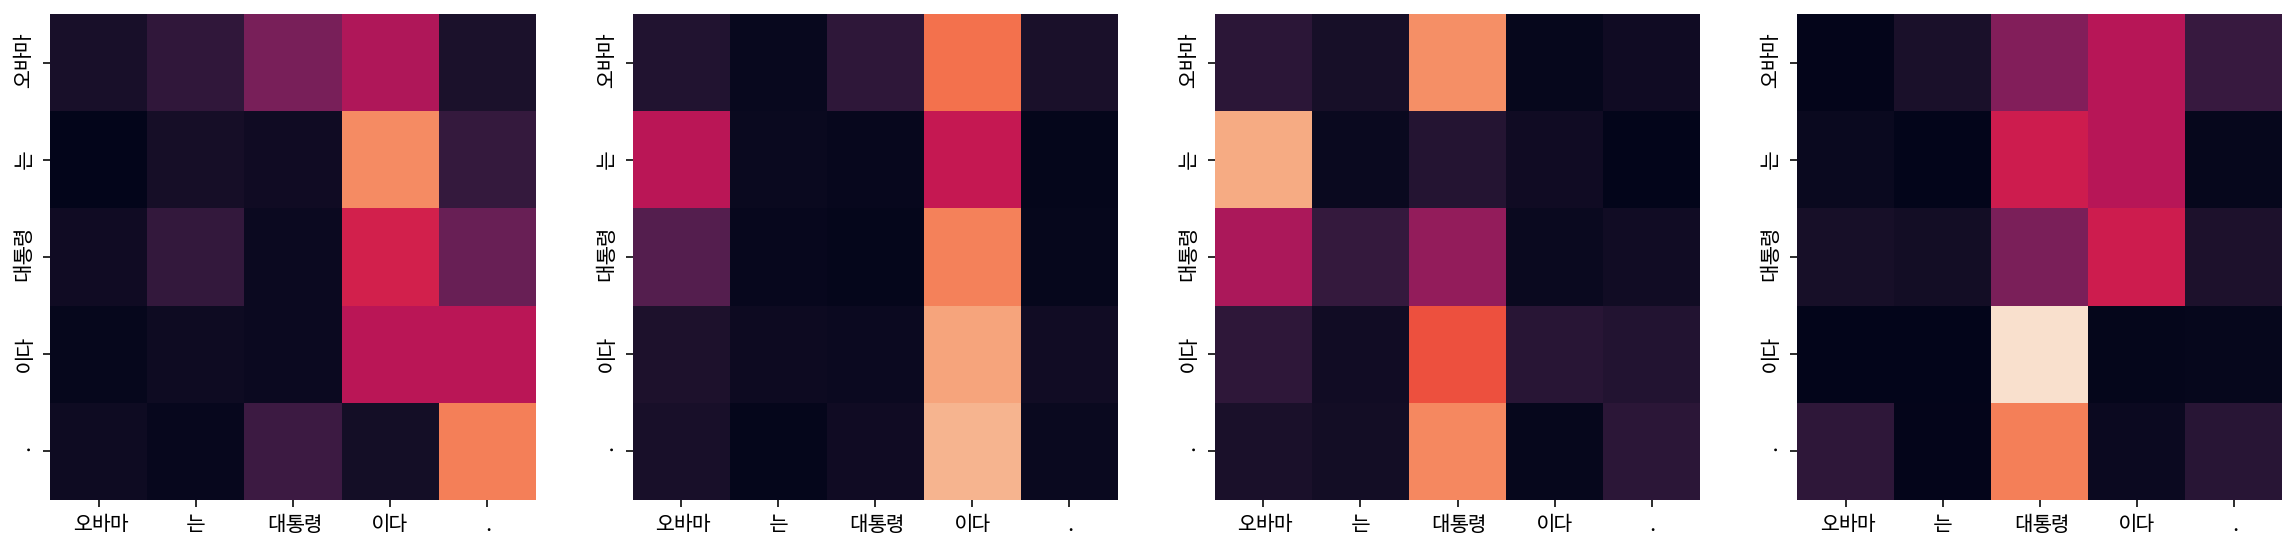

Decoder Self Layer 1


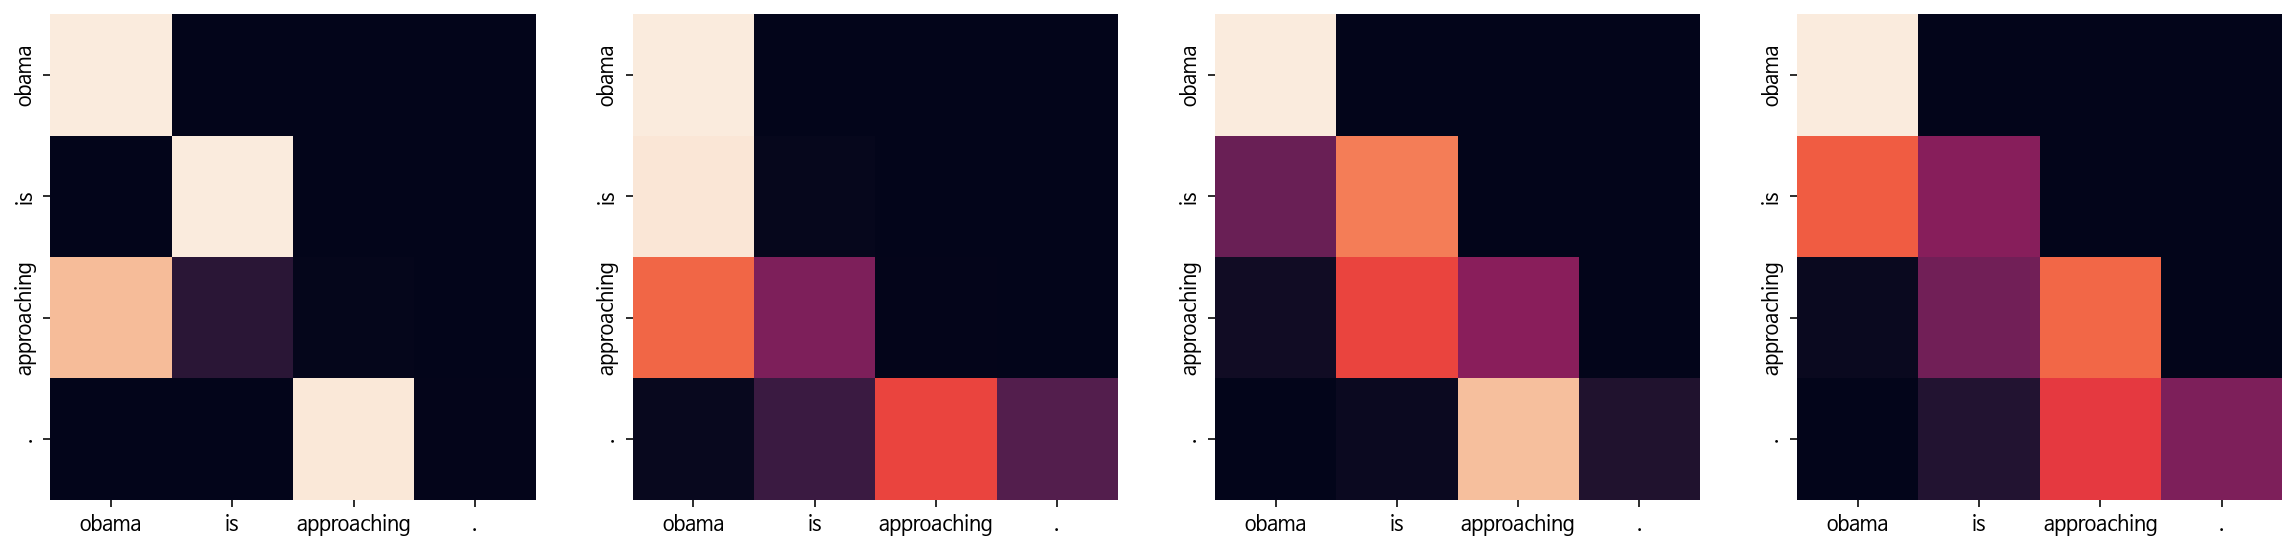

Decoder Src Layer 1


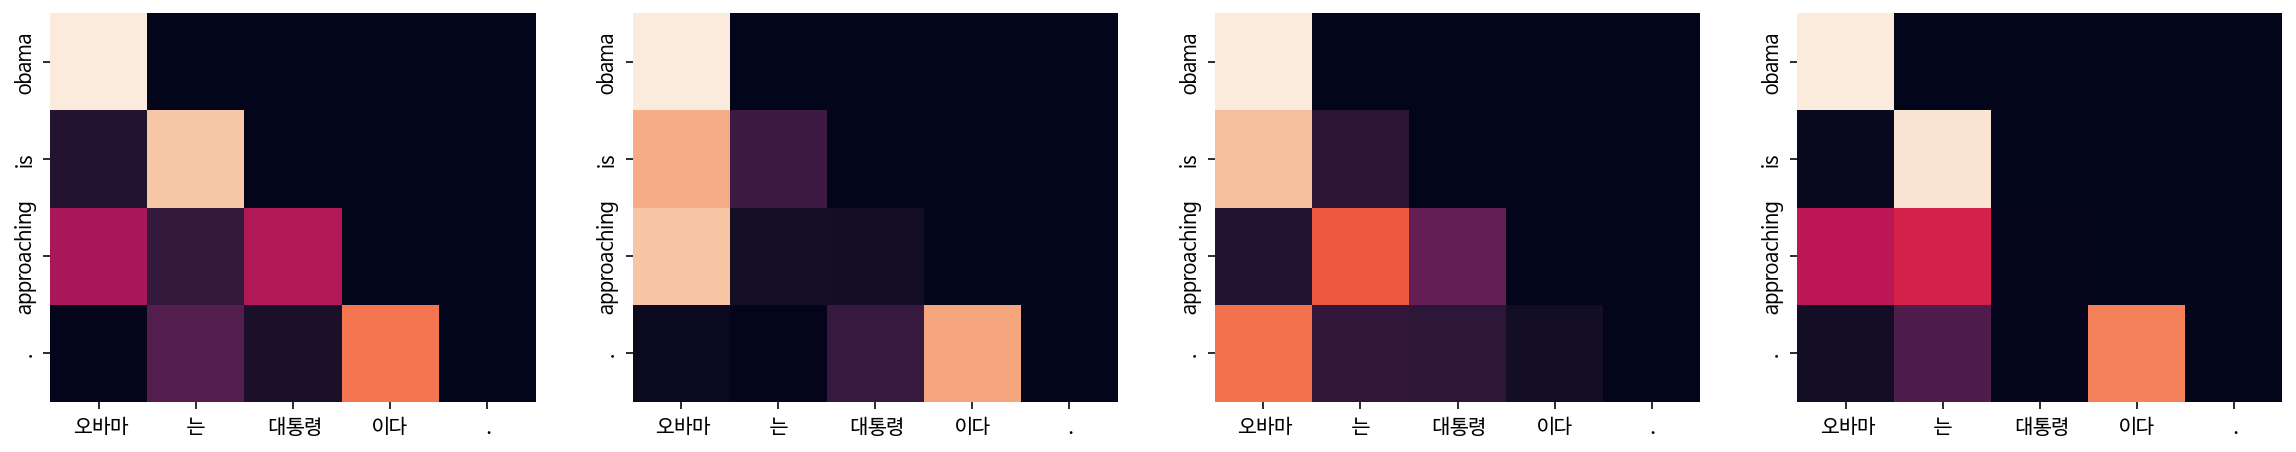

Decoder Self Layer 2


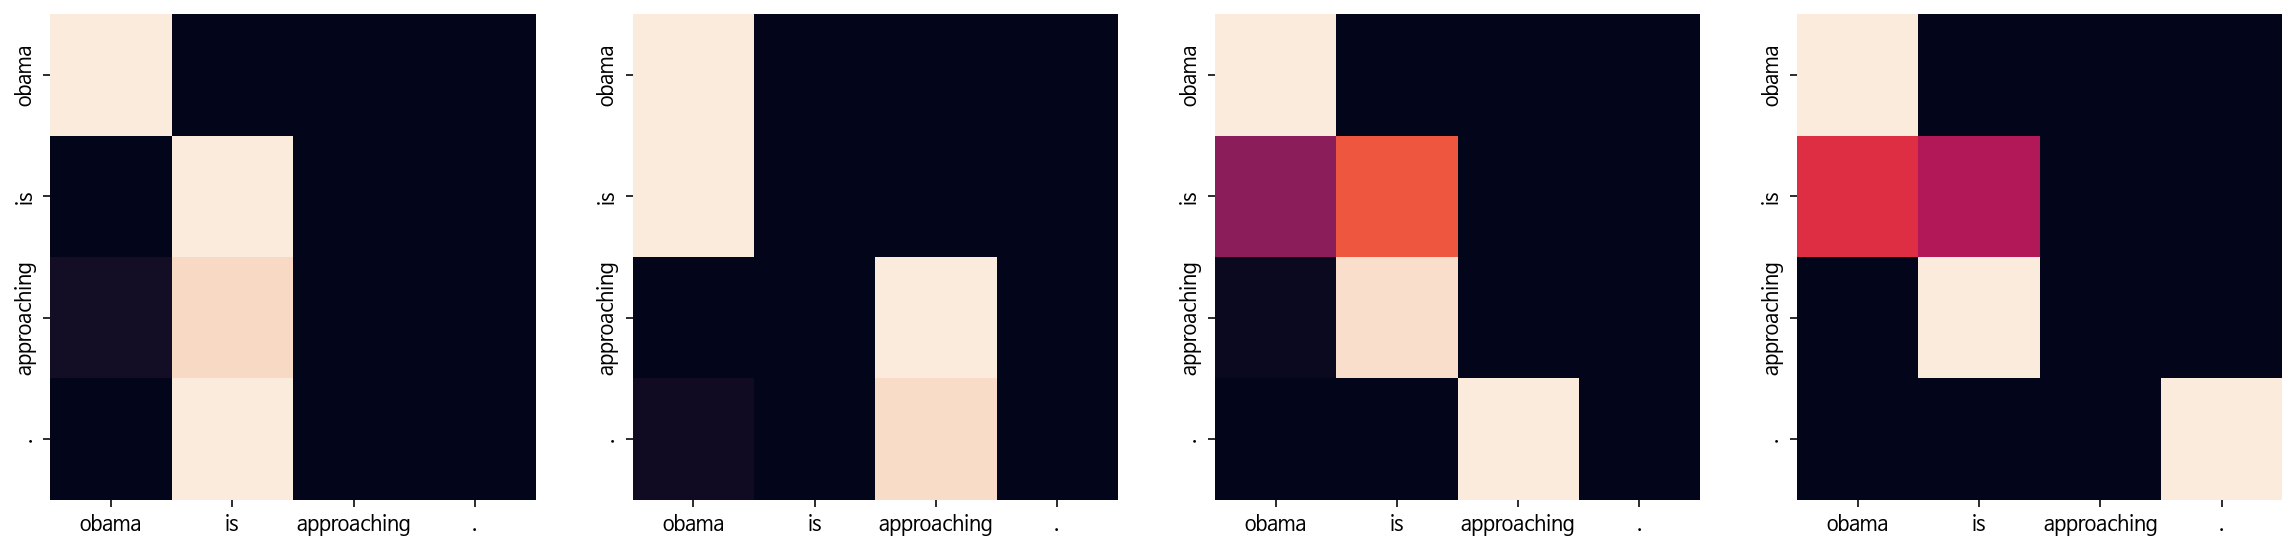

Decoder Src Layer 2


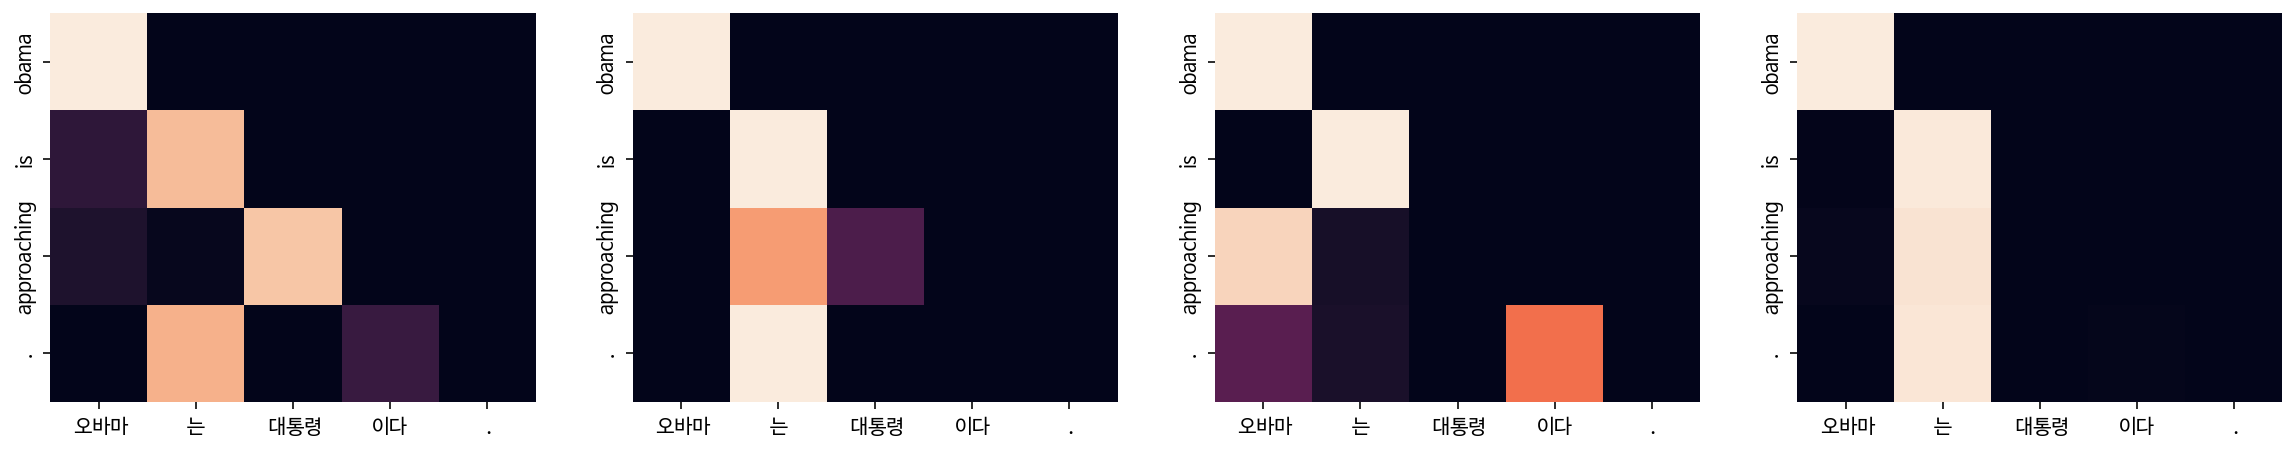

'obama is approaching .'

In [109]:
translate(examples[0], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


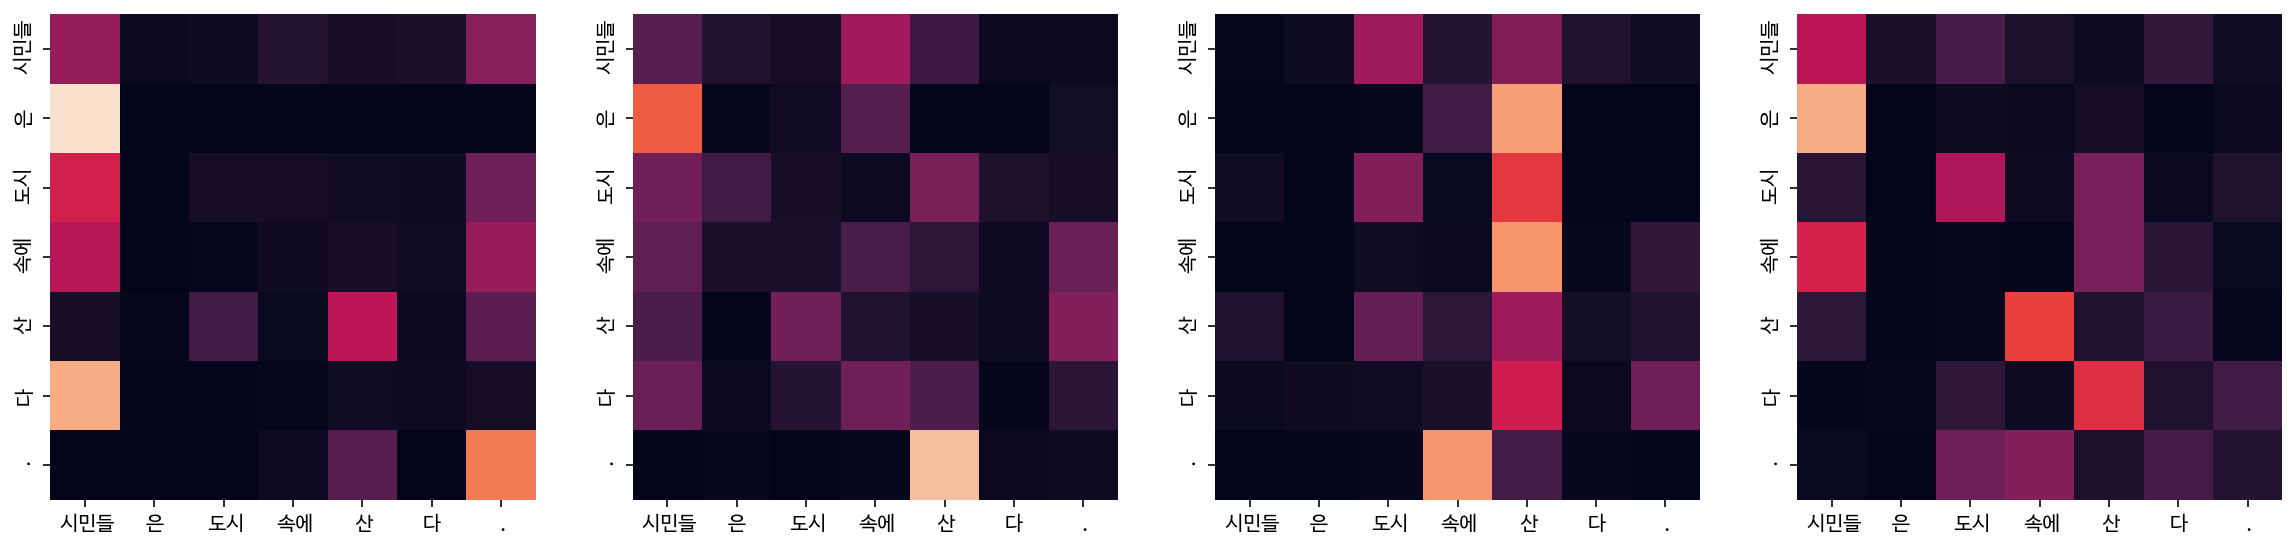

Encoder Layer 2


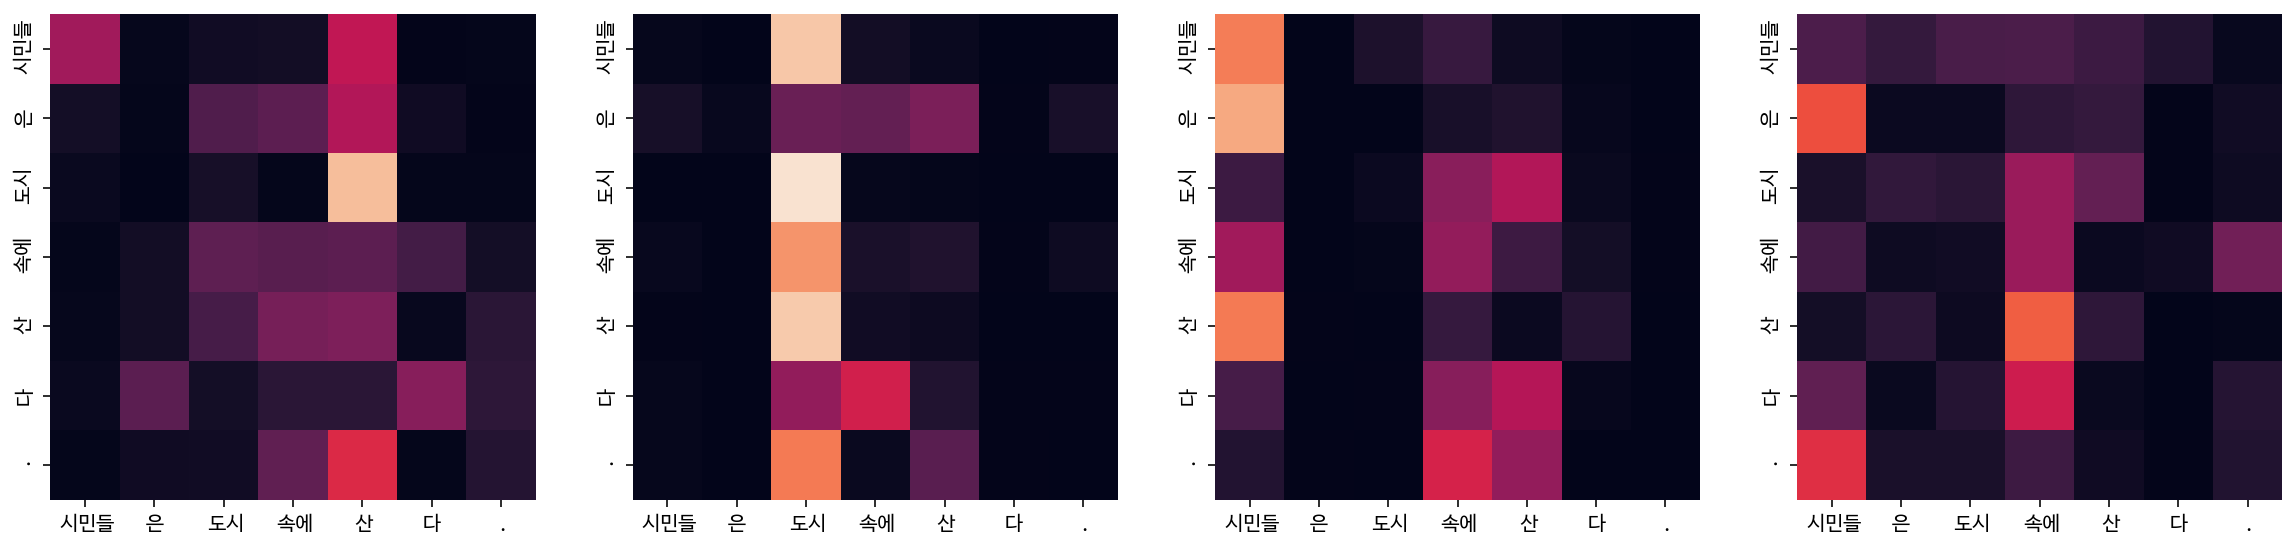

Decoder Self Layer 1


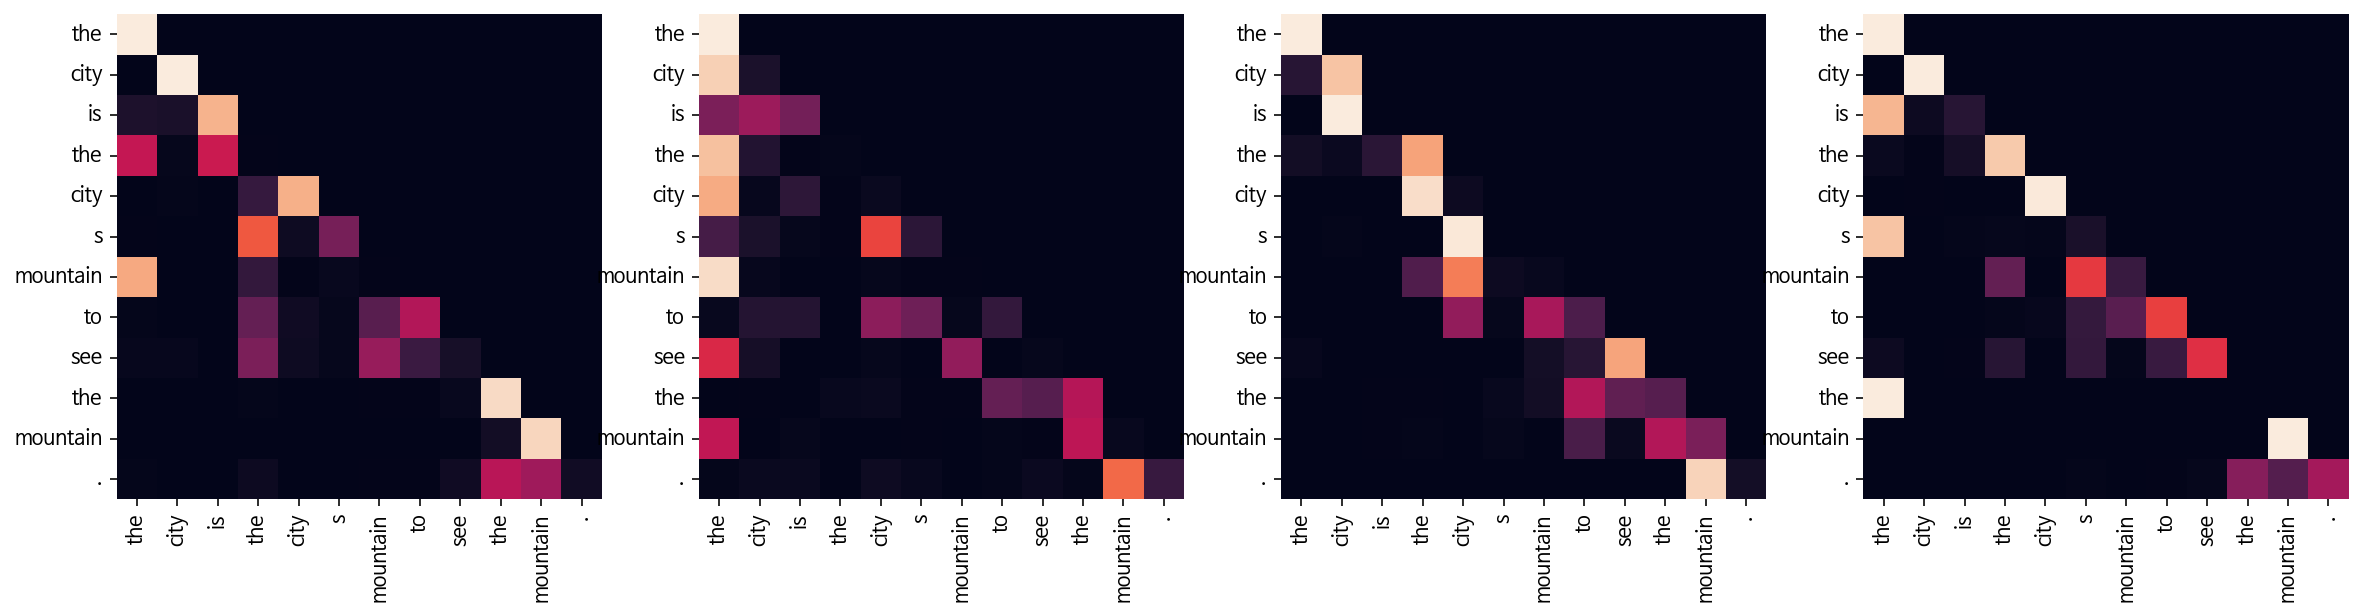

Decoder Src Layer 1


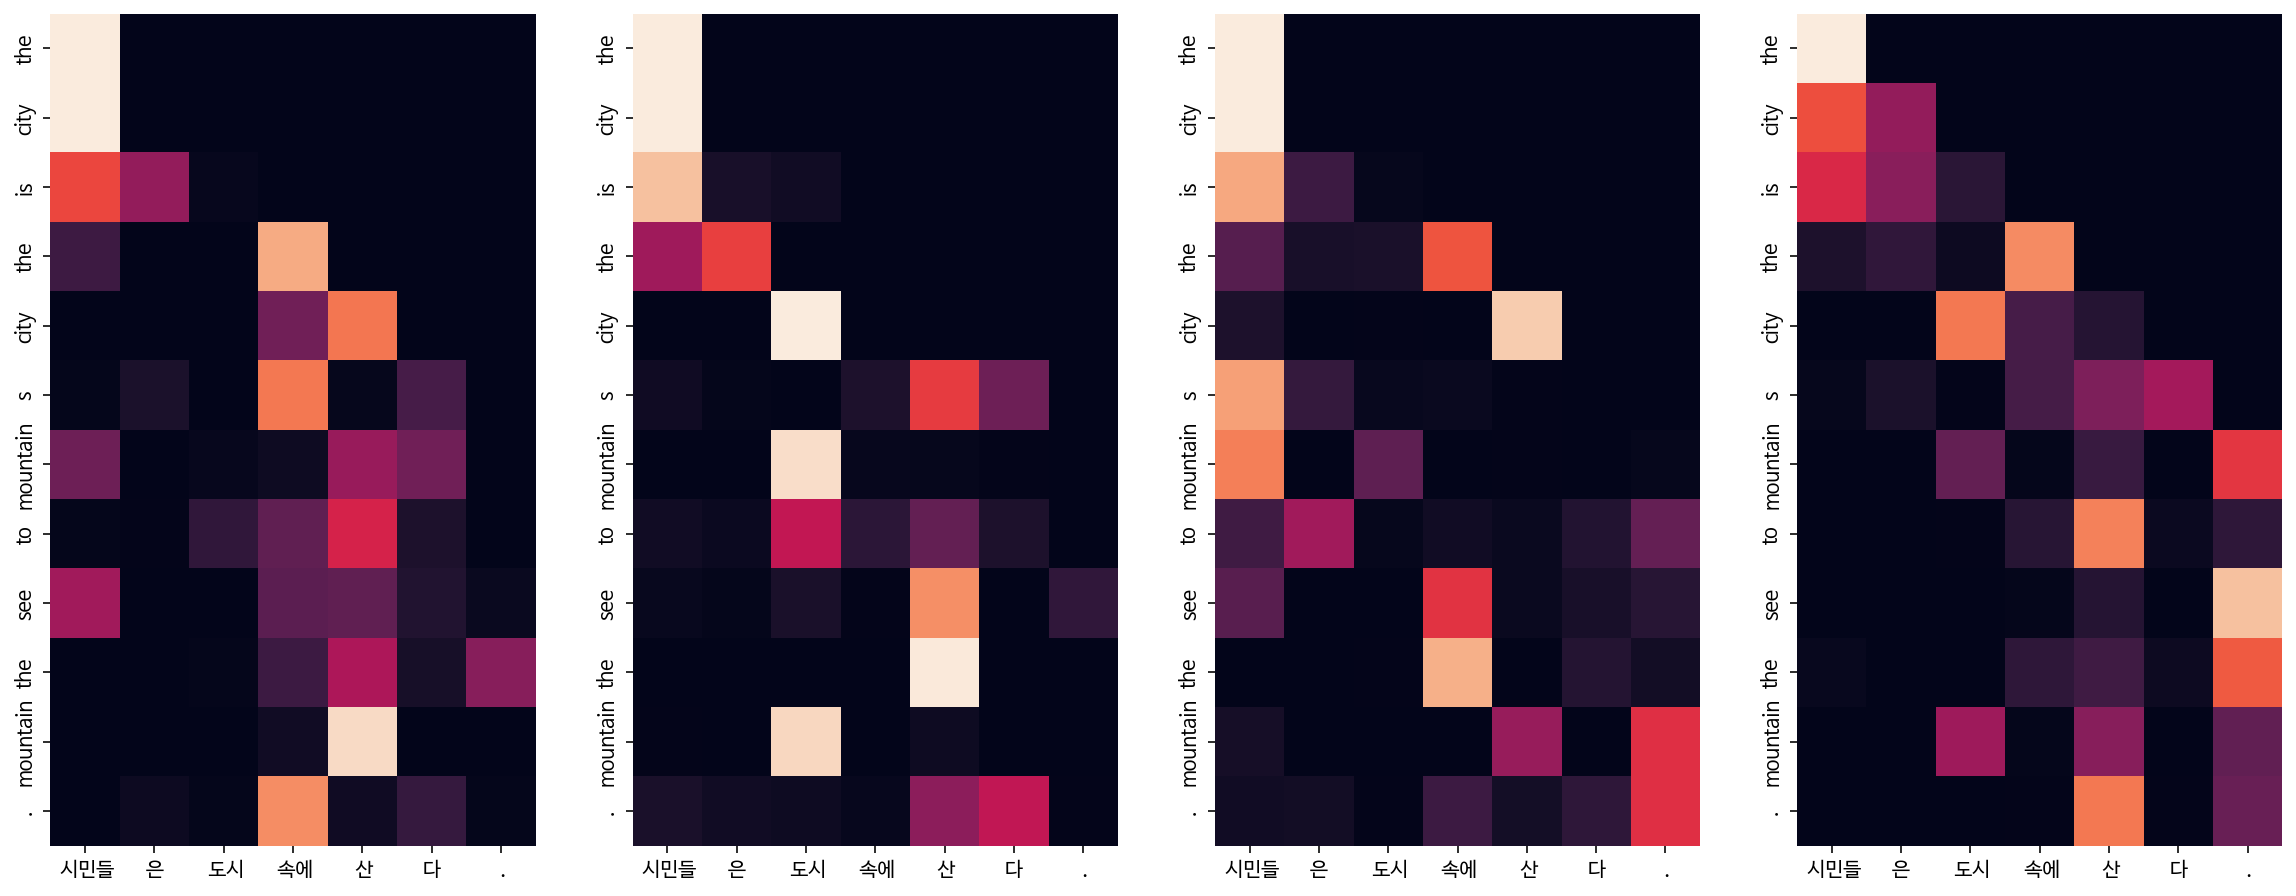

Decoder Self Layer 2


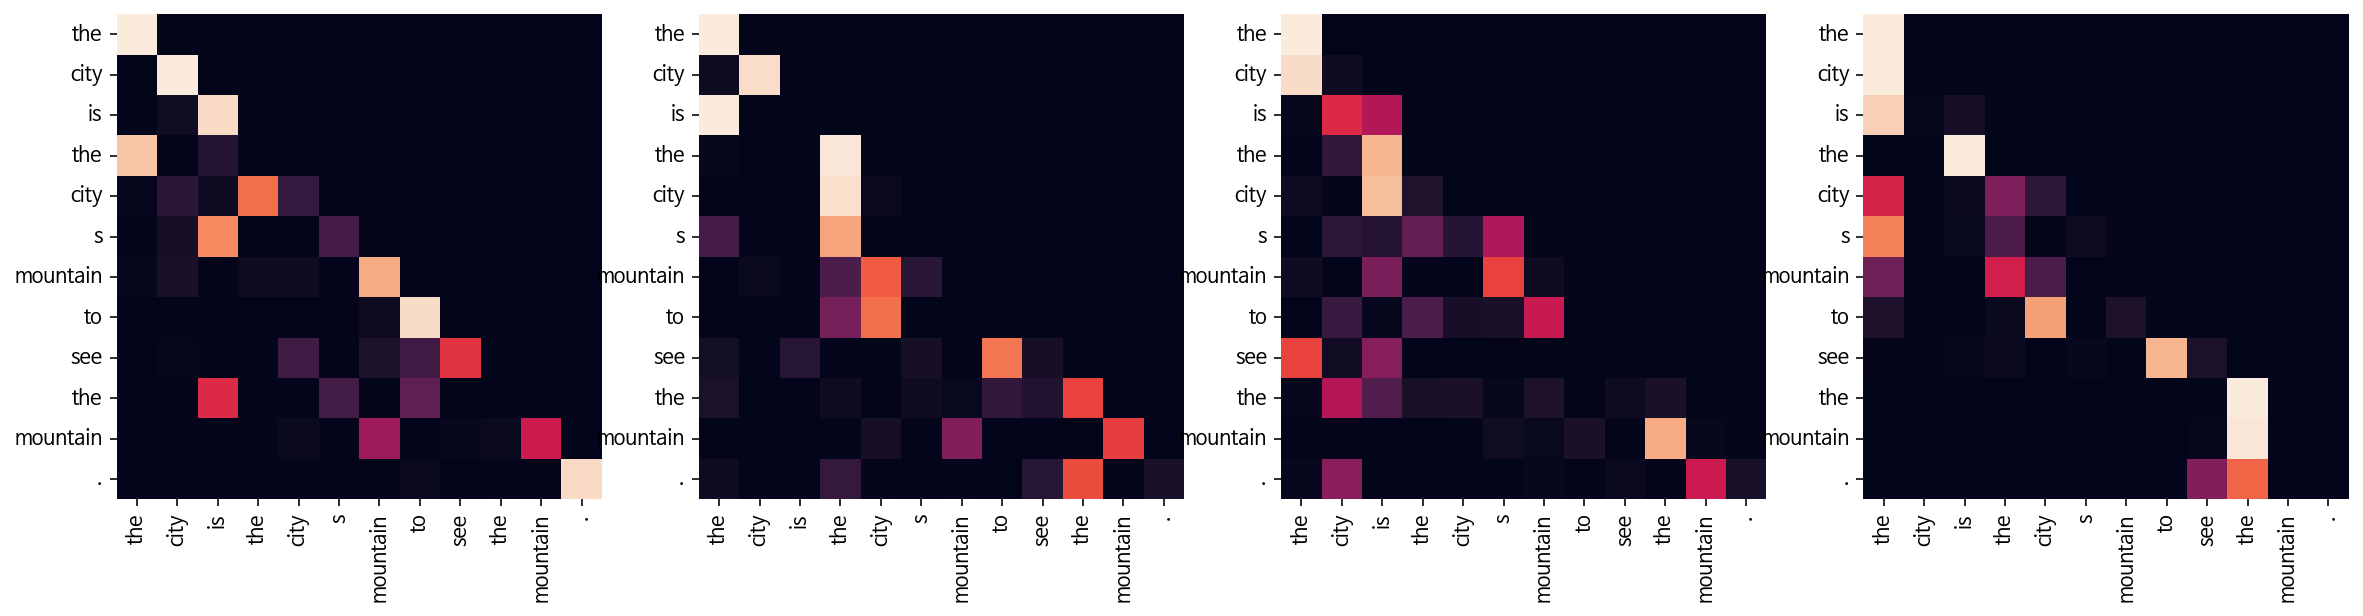

Decoder Src Layer 2


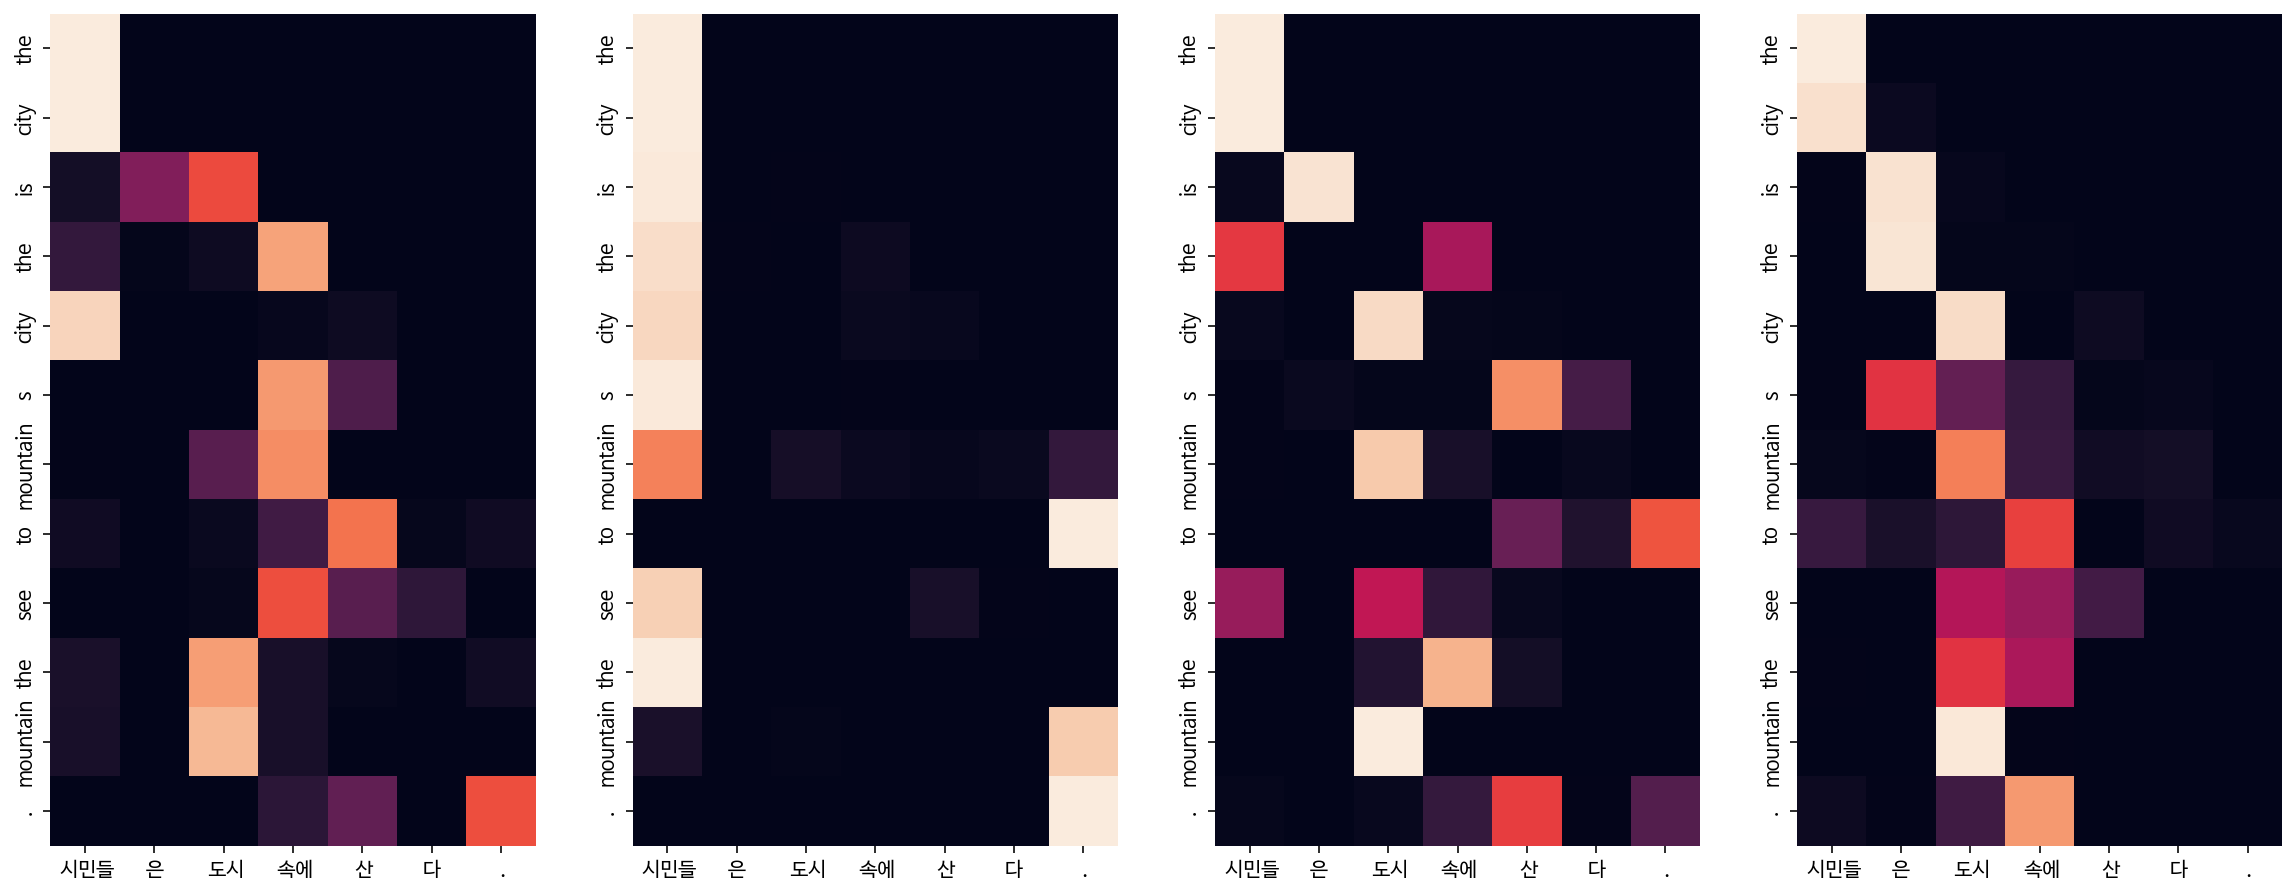

'the city is the city s mountain to see the mountain .'

In [110]:
translate(examples[1], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


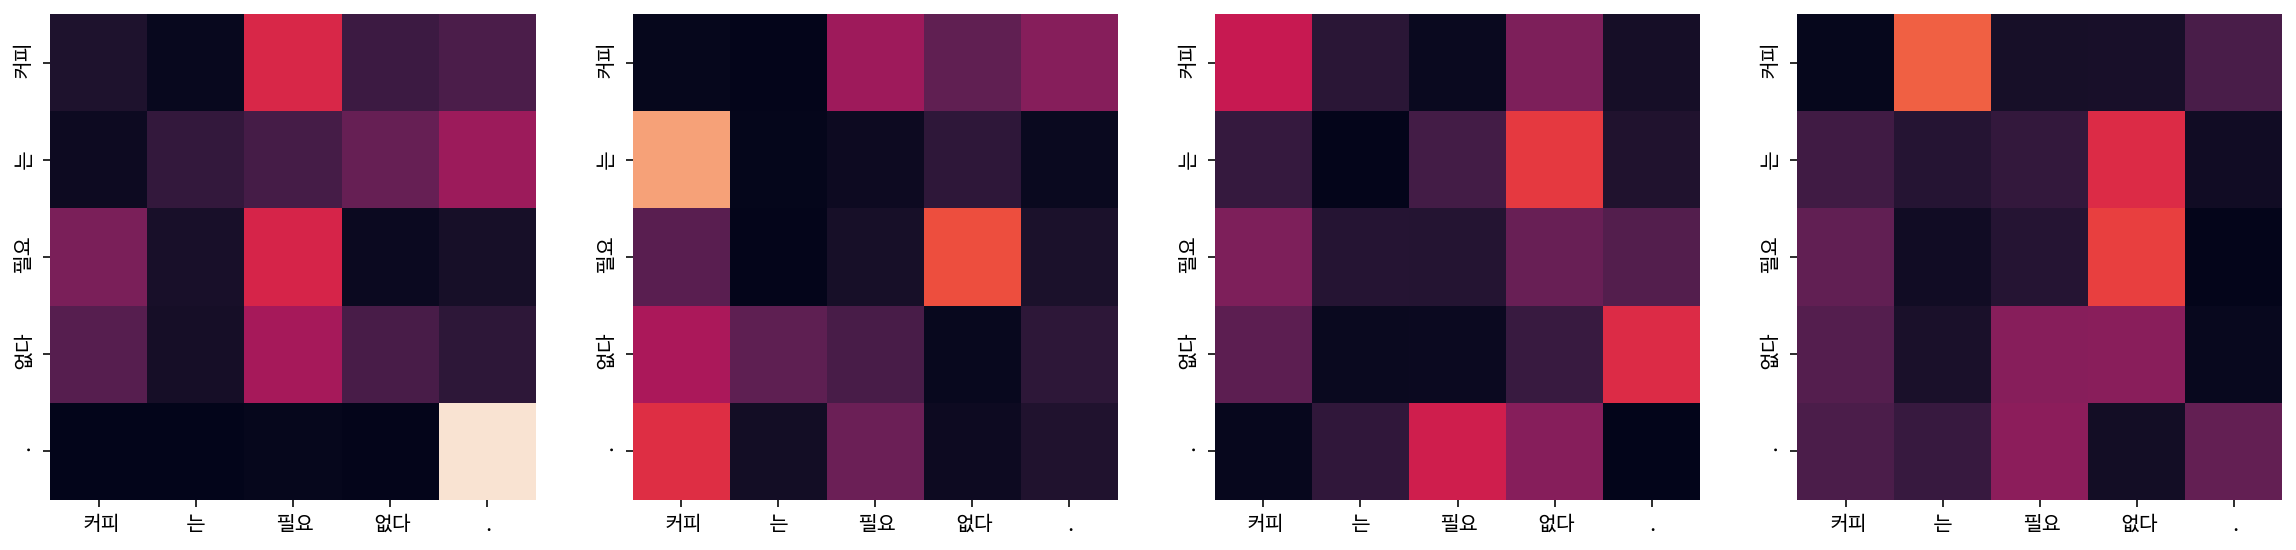

Encoder Layer 2


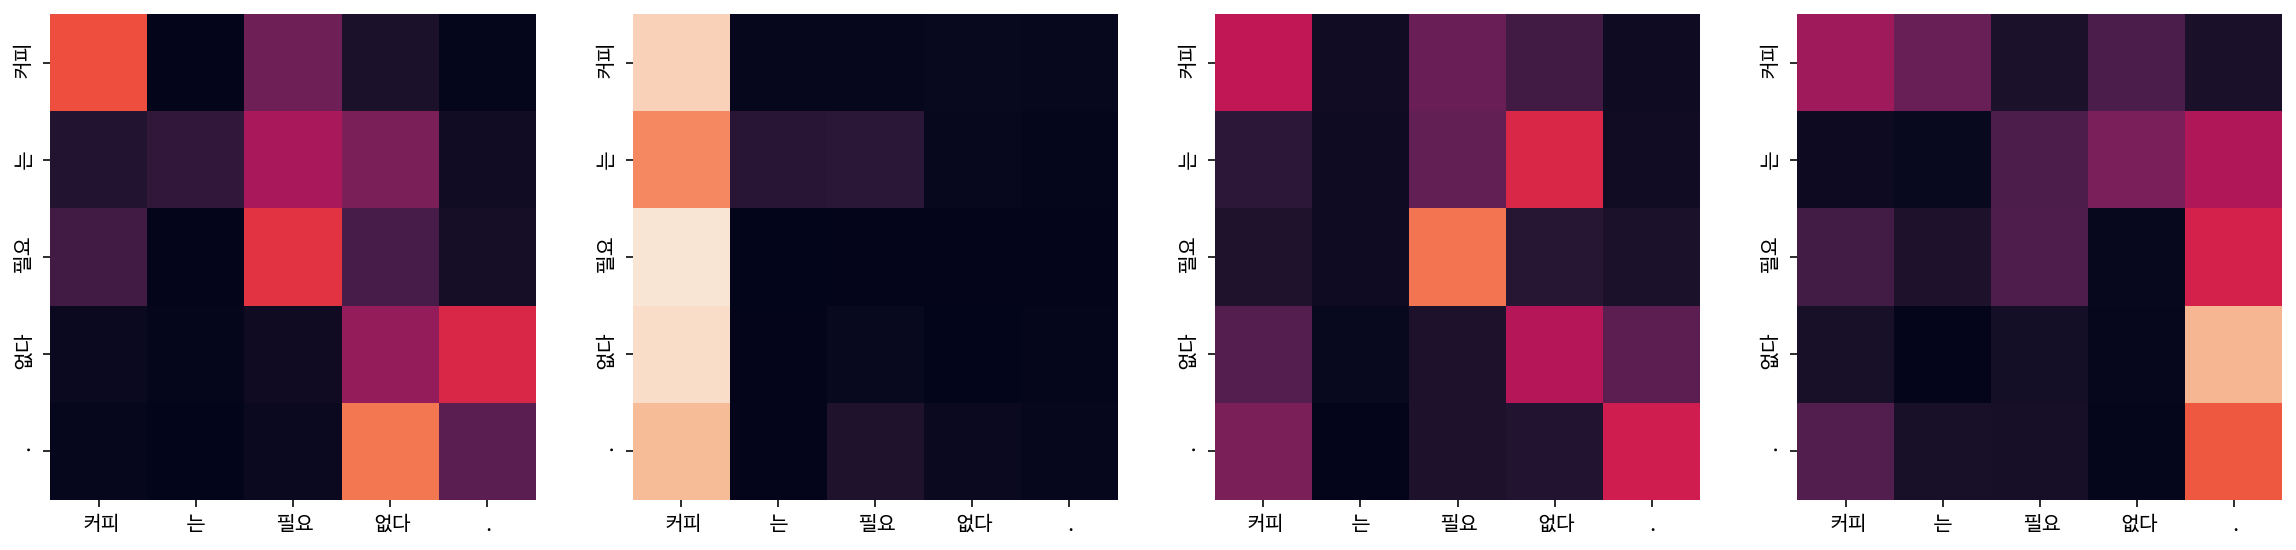

Decoder Self Layer 1


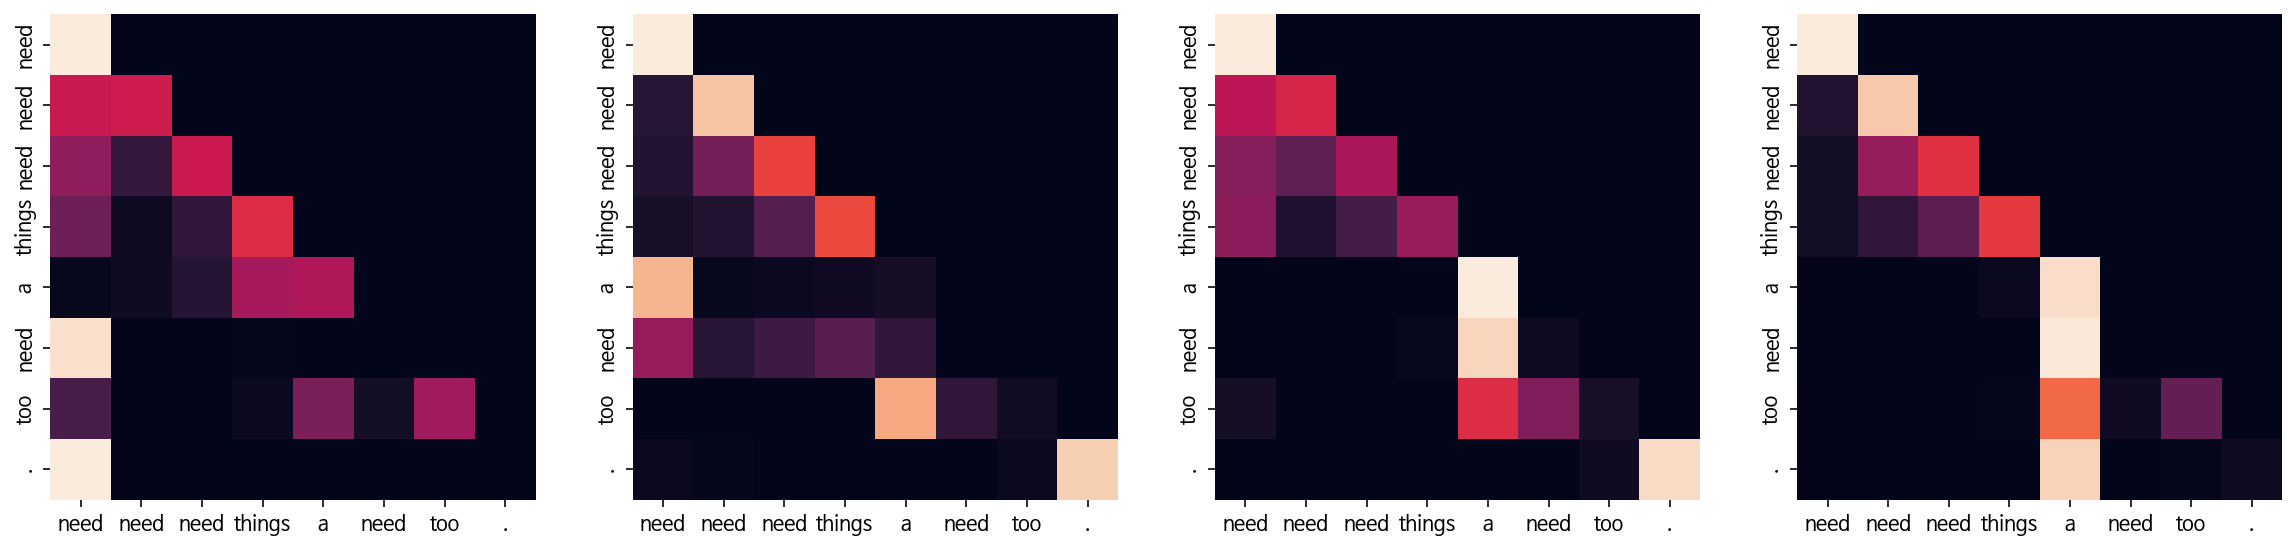

Decoder Src Layer 1


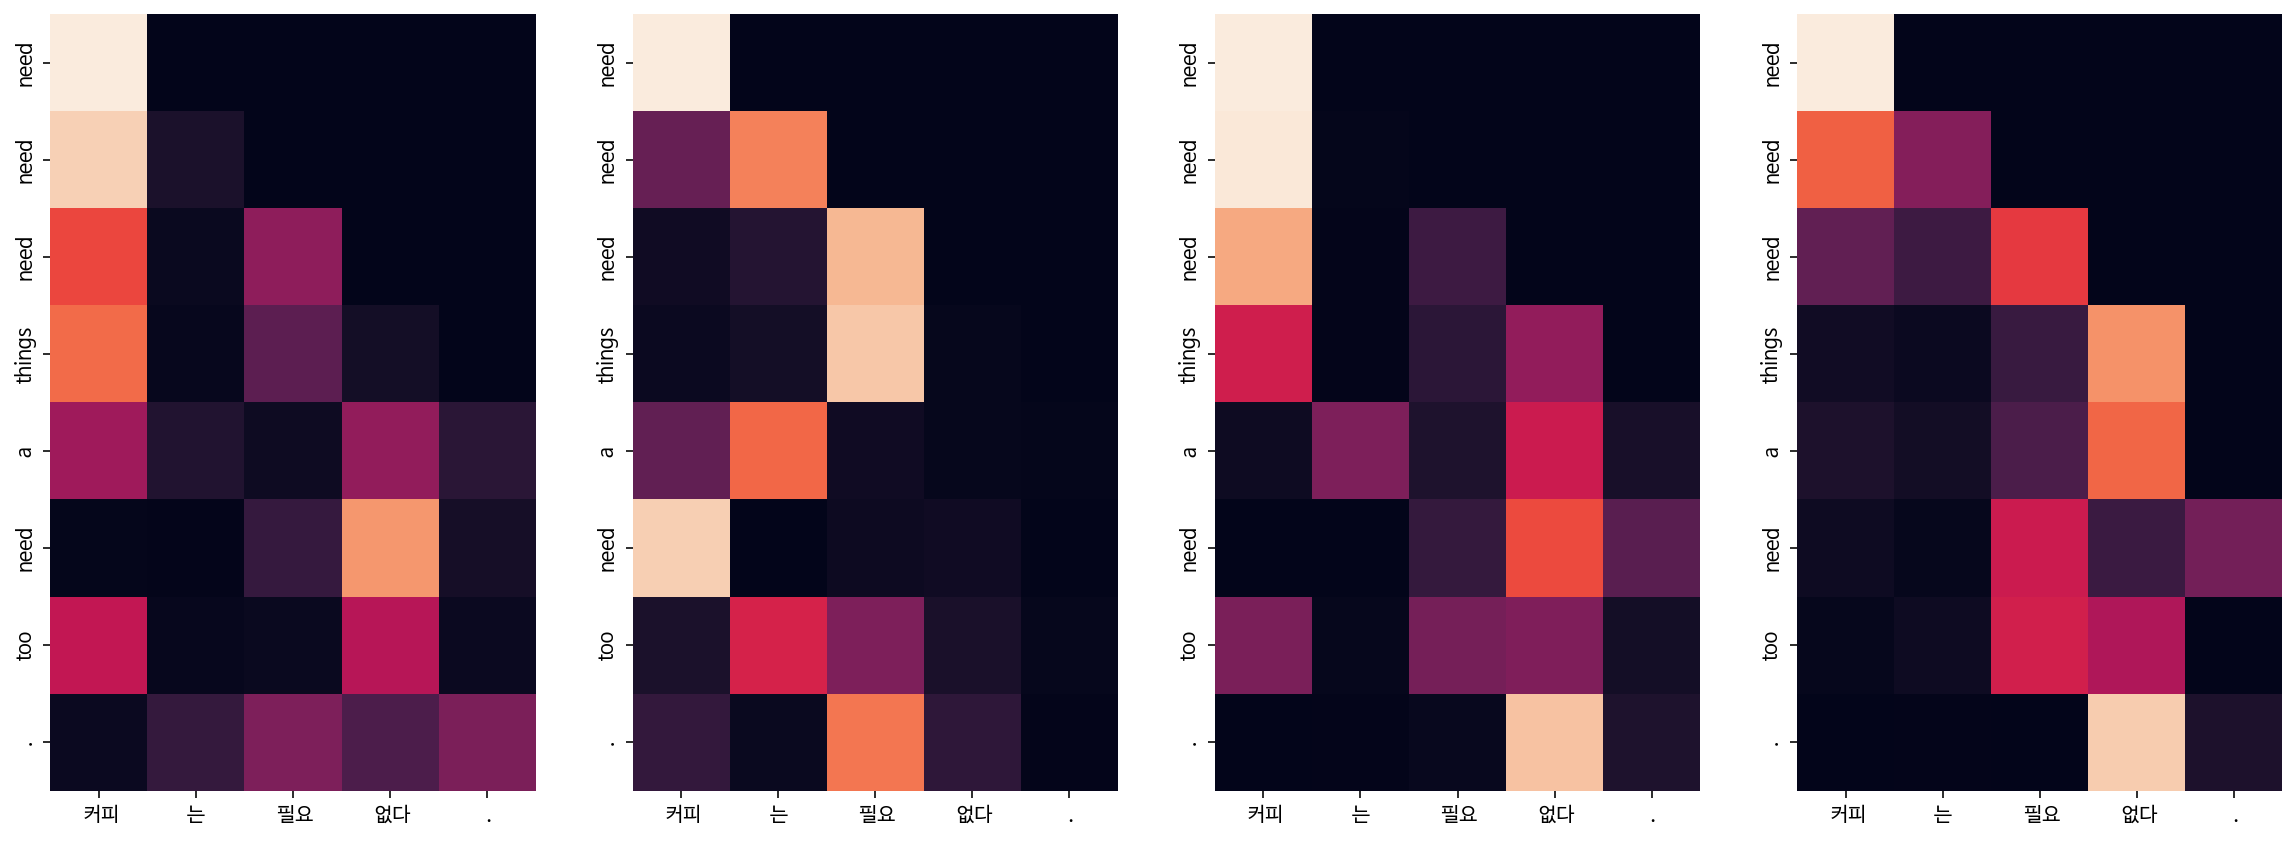

Decoder Self Layer 2


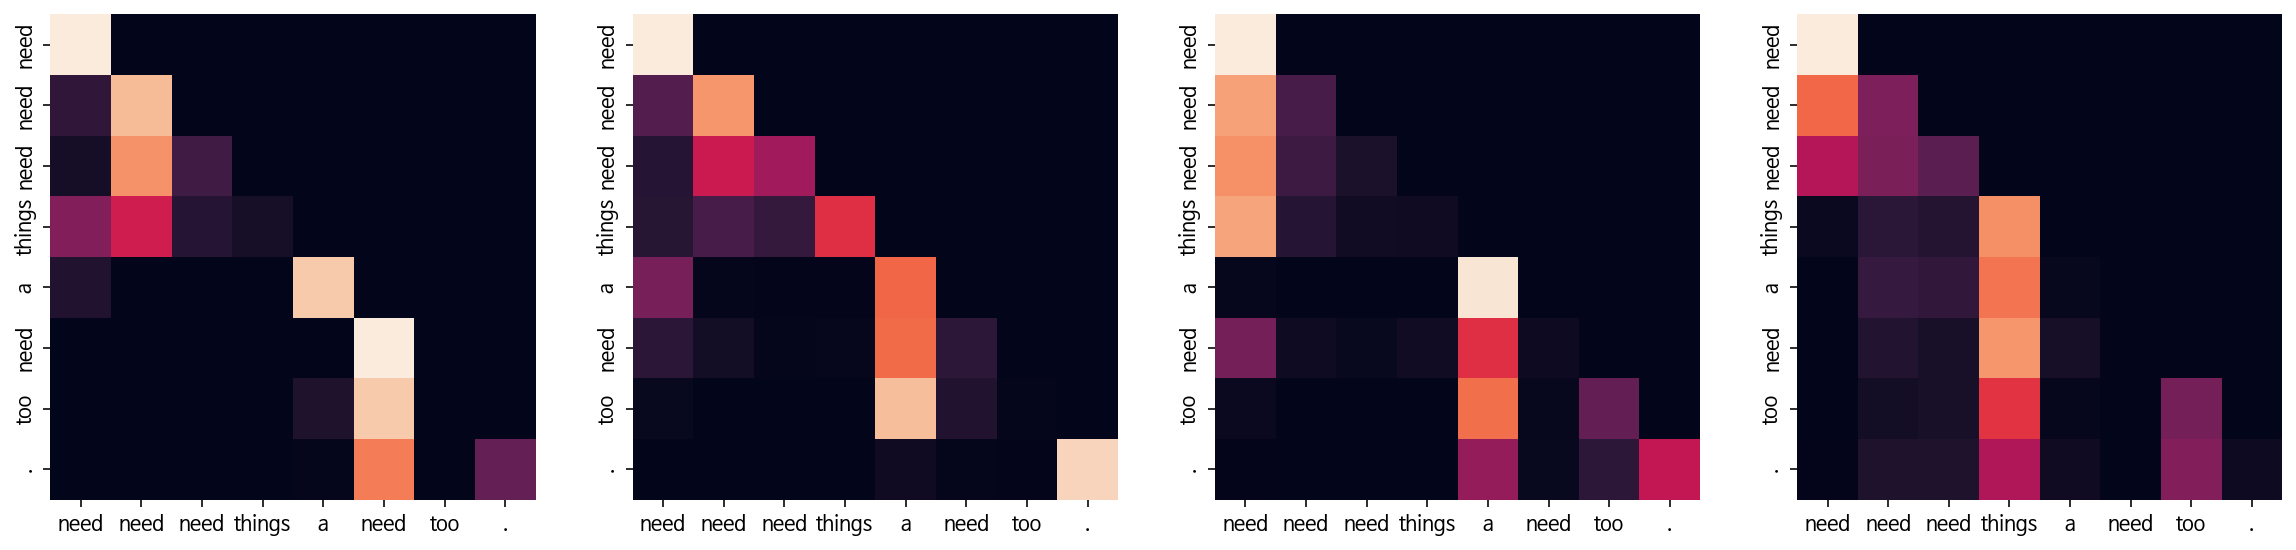

Decoder Src Layer 2


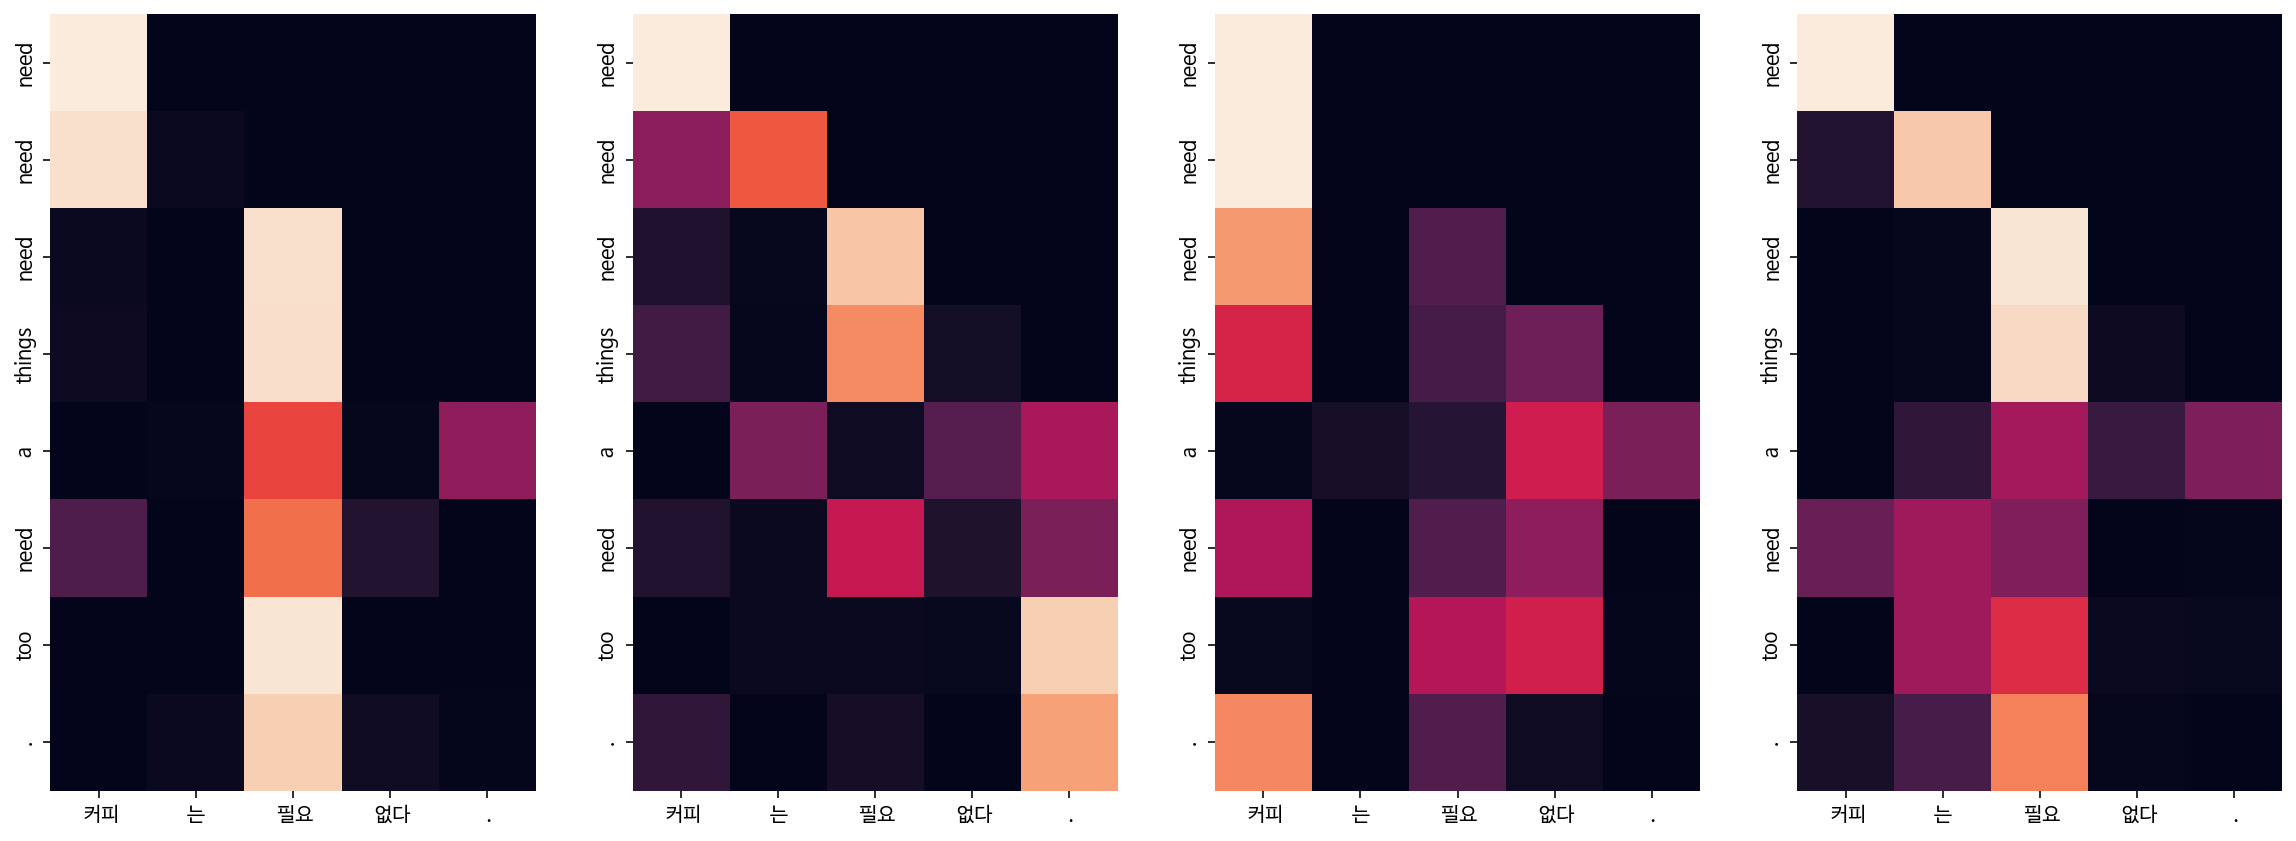

'need need need things a need too .'

In [111]:
translate(examples[2], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Encoder Layer 1


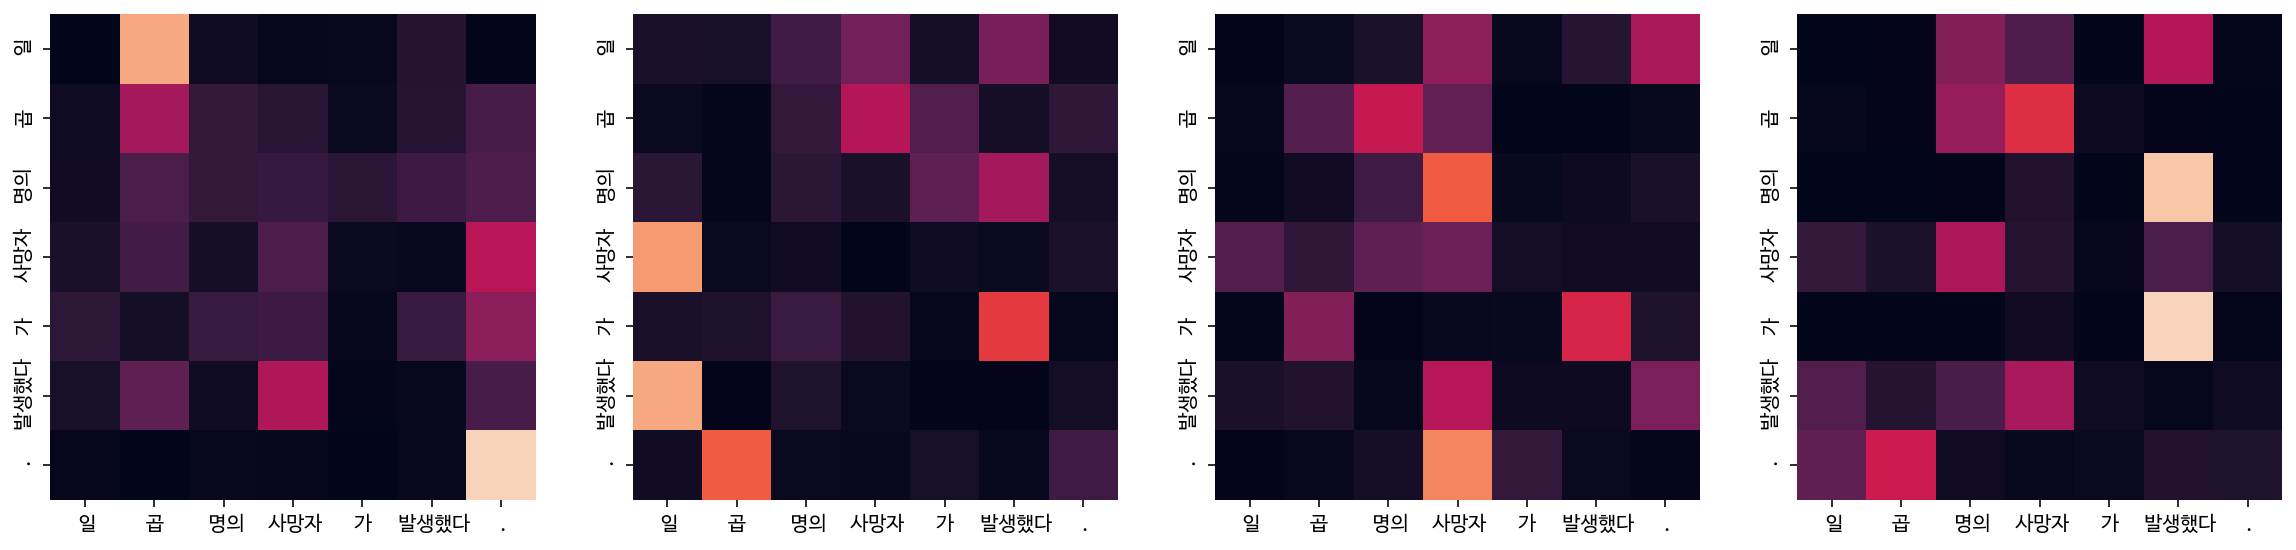

Encoder Layer 2


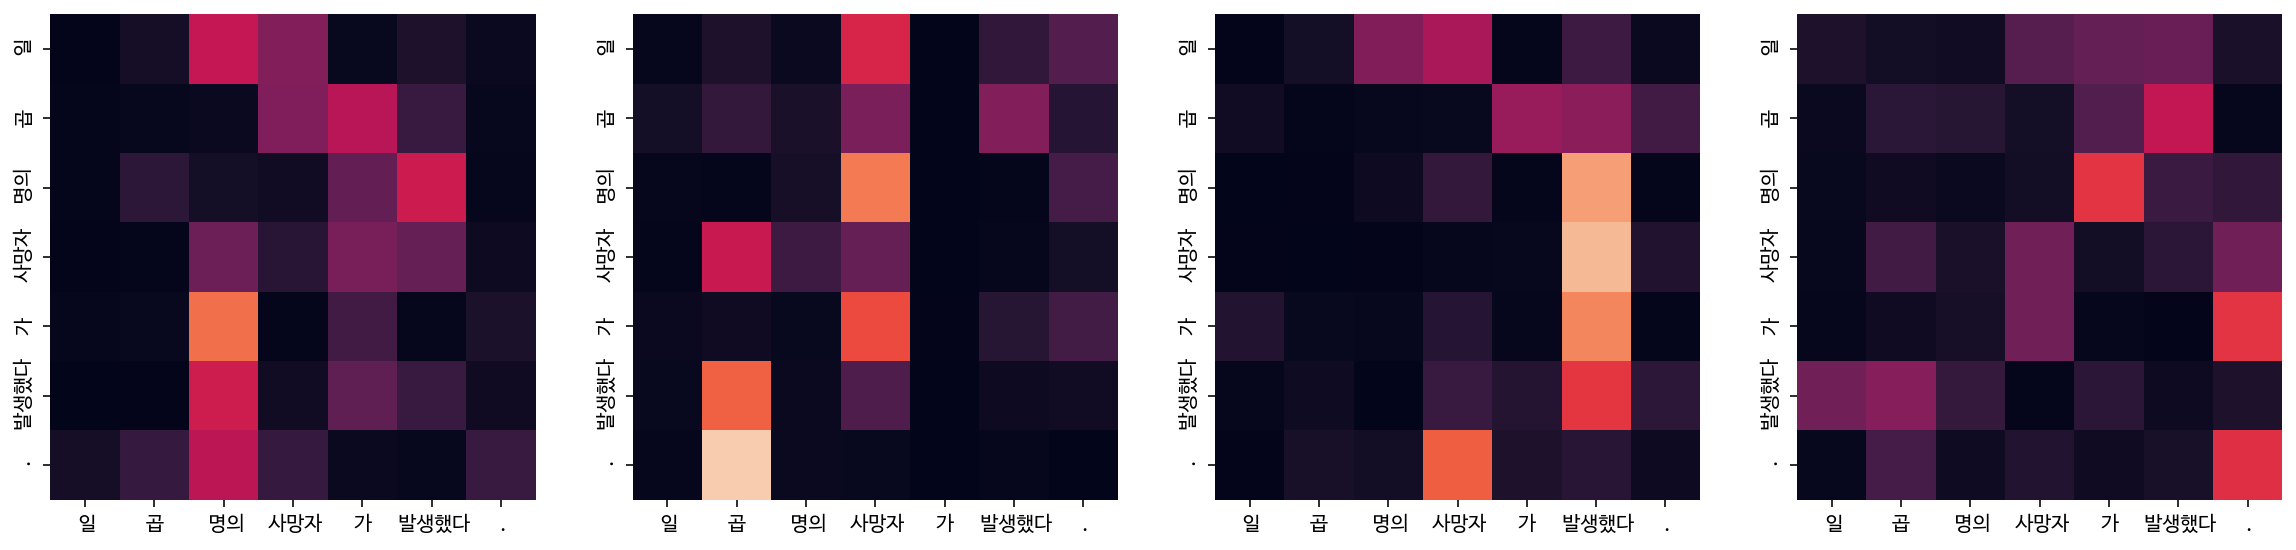

Decoder Self Layer 1


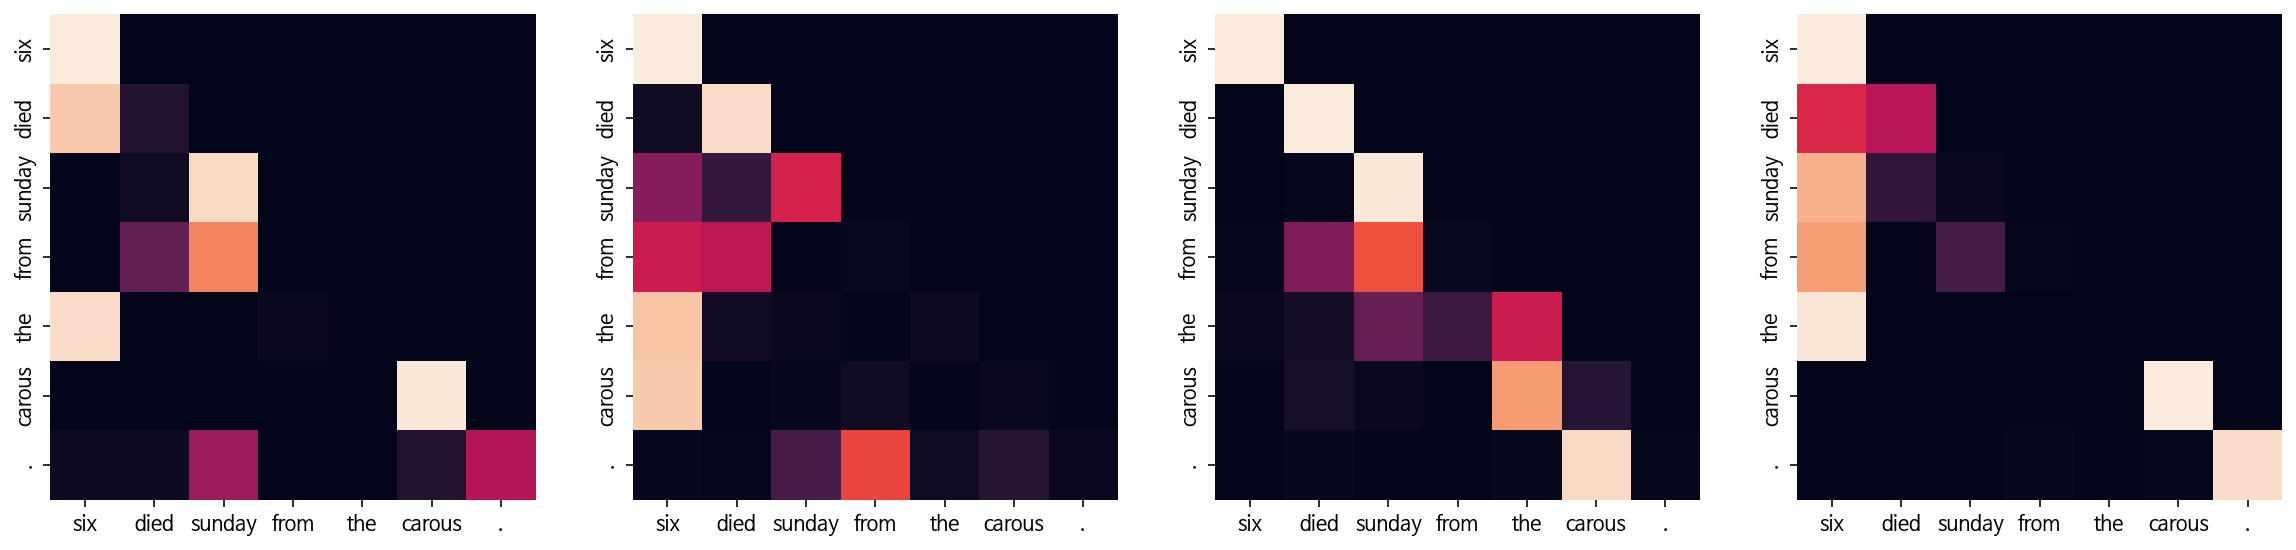

Decoder Src Layer 1


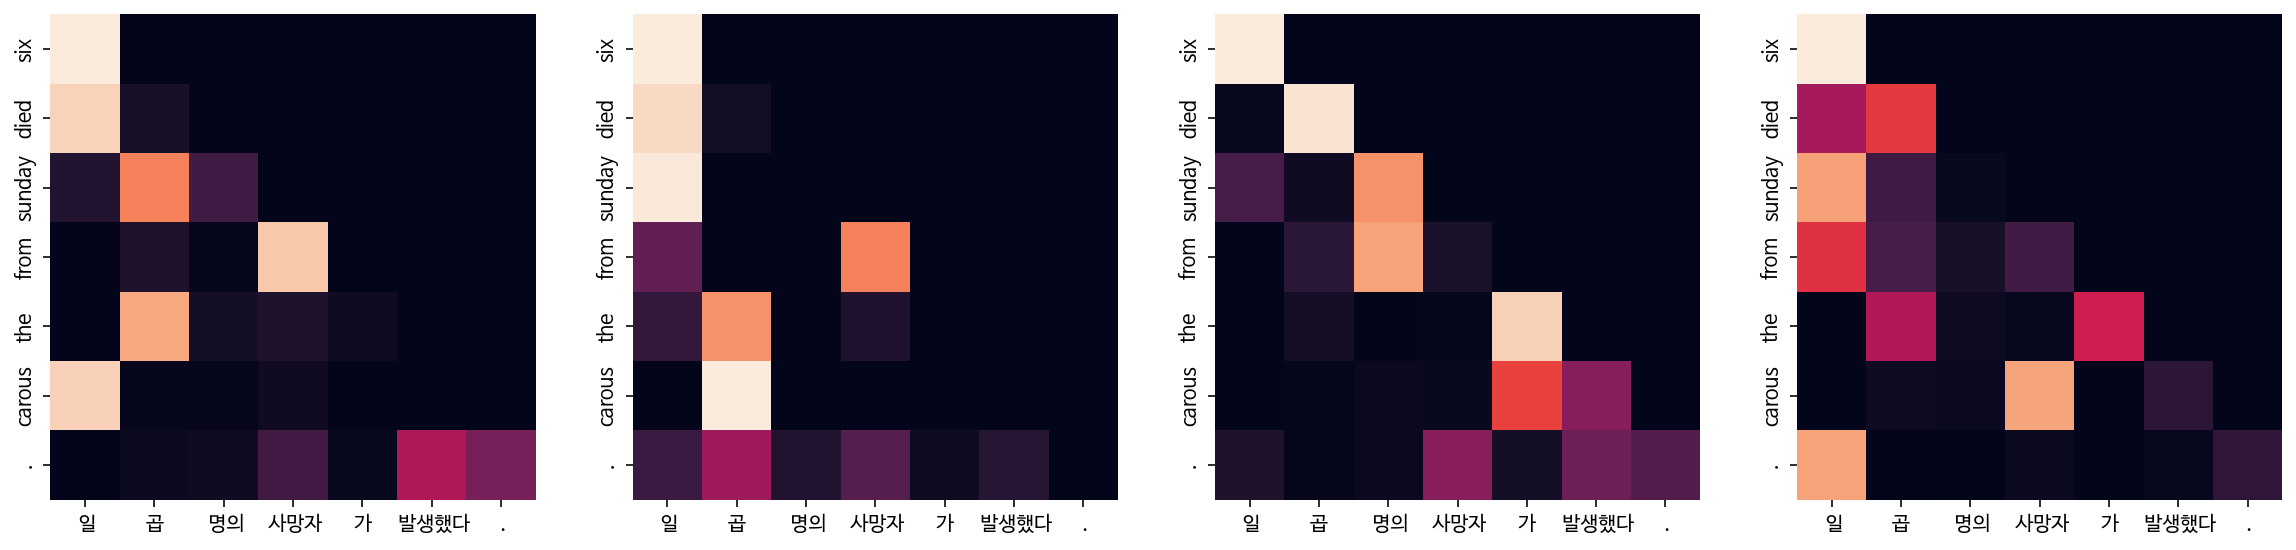

Decoder Self Layer 2


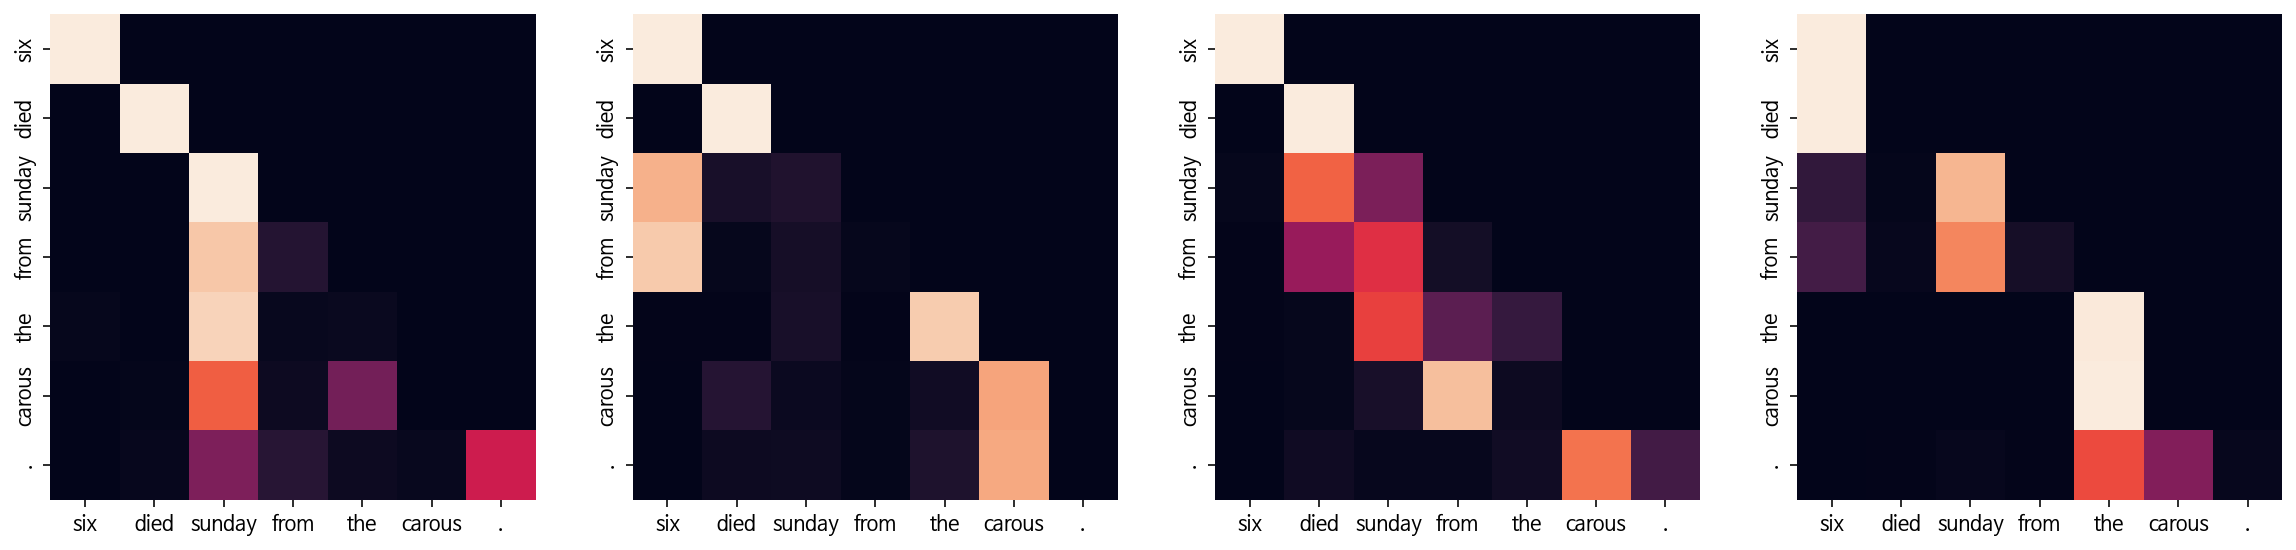

Decoder Src Layer 2


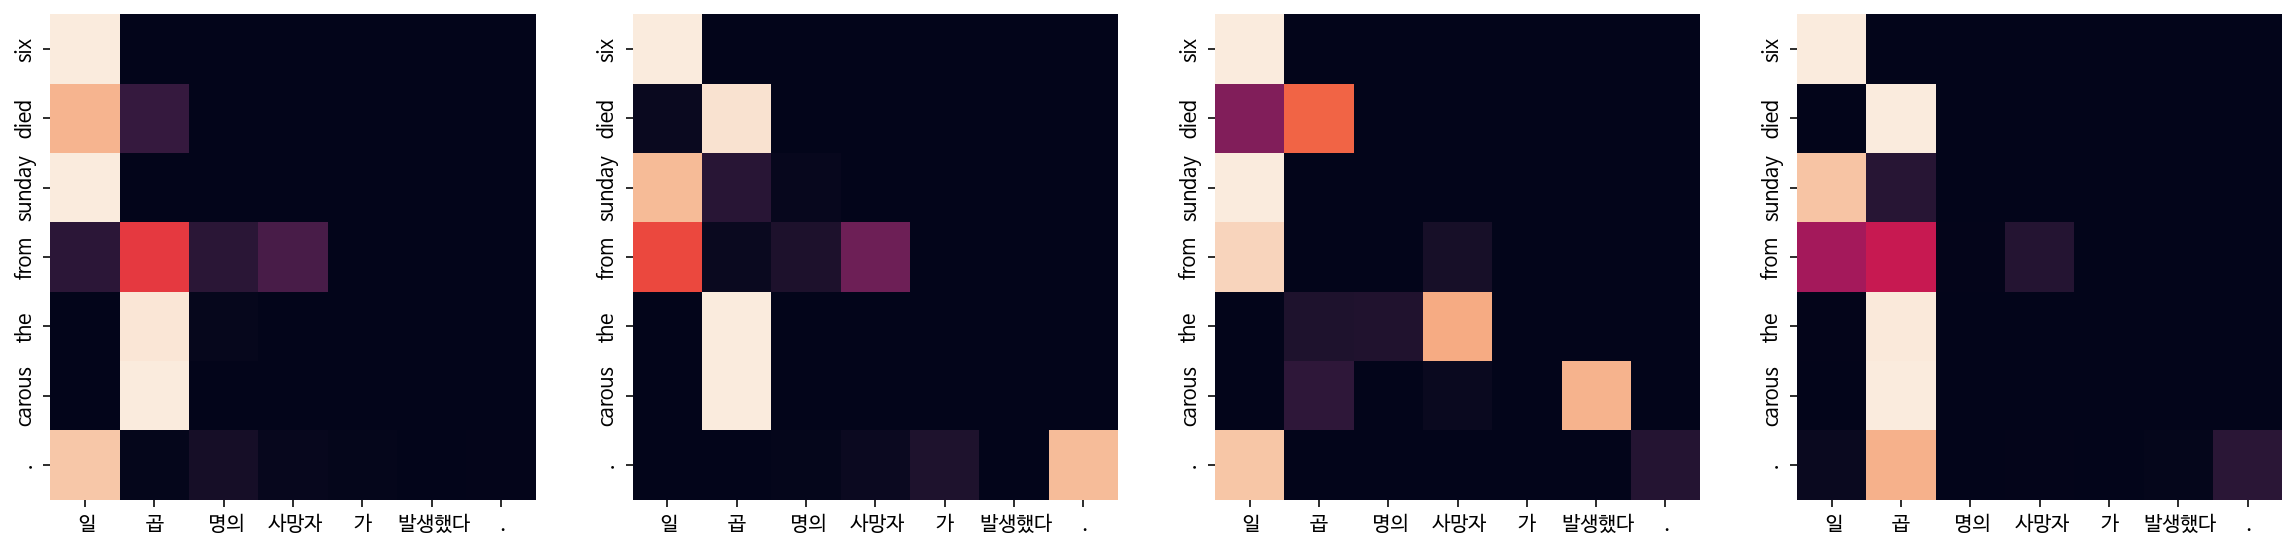

'six died sunday from the carous .'

In [112]:
translate(examples[3], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

In [113]:
additional_epochs = 10
loss_history, translates = train_and_translate(transformer, optimizer, enc_train, dec_train, ko_tokenizer, en_tokenizer, additional_epochs, BATCH_SIZE, examples, INTERVAL, start_epoch=EPOCHS, loss_history=loss_history, translates=translates)

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 15
Translations: 
> obama is increasing .
> in this city is permanent .
> need coffee , the needs to be needs .
> six died in the car along with the local authority said thursday .


  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 20
Translations: 
> obama is in .
> the city was seen as the city .
> need need weather .
> six died in the hospital , there were .


In [114]:
# Continue training from the last epoch
EPOCHS += additional_epochs
loss_history, translates = train_and_translate(transformer, optimizer, enc_train, dec_train, ko_tokenizer, en_tokenizer, additional_epochs, BATCH_SIZE, examples, INTERVAL, start_epoch=EPOCHS, loss_history=loss_history, translates=translates)

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/1231 [00:00<?, ?it/s]

Epoch 30
Translations: 
> obama is coming into white .
> in the city was mountain restaurants around the city mountain .
> need coffee , there needs to be a larger needs to be need .
> seven people were killed thursday .


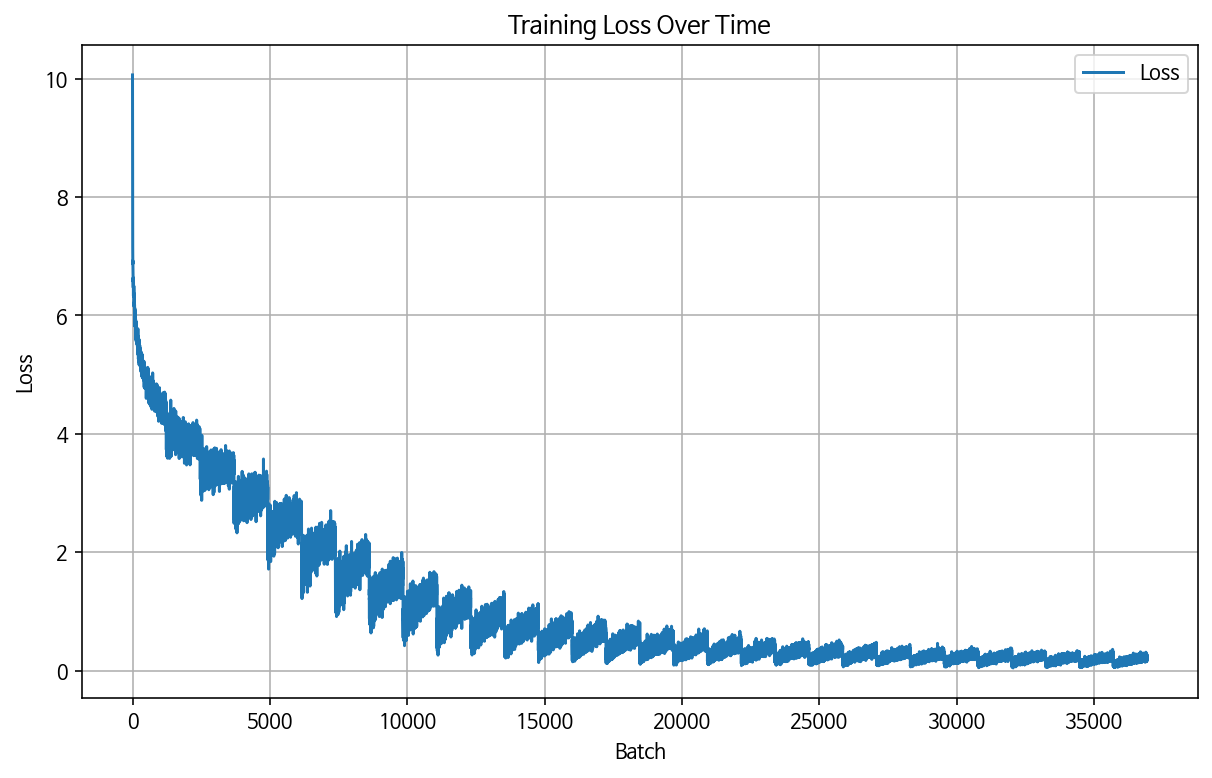

In [115]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
result1 = results.copy()

In [120]:
result1.to_csv('result1.csv', index=False)

In [121]:
results = pd.DataFrame(translates, columns=['epoch','sentences'])
results = pd.DataFrame(results.sentences.to_list(), columns=['sent1','sent2','sent3','sent4'])

In [122]:
results.shape

(30, 4)

In [123]:
examples

['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [129]:
print(f'문장 : {examples[0]} \n ->', end=' ')
print('\n -> '.join(results.sent1.tolist()[::2]))

문장 : 오바마는 대통령이다. 
 -> obama is a big day .
 -> obama is the president elect .
 -> obama is the president .
 -> obama is coming .
 -> obama is scheduled to .
 -> obama is
 -> obama picks up .
 -> obama is increasing .
 -> obama is . .
 -> obama is widely headed by obama .
 -> obama is increasingly reways in .
 -> obama is increasingly being .
 -> obama is on the president .
 -> obama is on a president .
 -> obama is on a president .


In [130]:
print(f'문장 : {examples[1]} \n ->', end=' ')
print('\n -> '.join(results.sent2.tolist()[::2]))

문장 : 시민들은 도시 속에 산다. 
 -> the city s largest city .
 -> the city is the city s urban .
 -> the city is the city s urbana .
 -> the city is down as the city s urban .
 -> the city is a symbol of .
 -> the city is the in cities where the city s mountain is the city s mountain .
 -> the city is permanent .
 -> in this city is permanent .
 -> in this city baby s suburbs , where the city s mountain boy is the on to be here mountain mountain viewed off , brown said in the city mountain .
 -> in the cities of cities large mountain .
 -> the city is permanently ceremony for kids in the city .
 -> in the city streets britain is everywhere .
 -> in the city , the city police are cheered to the city mountain .
 -> in this city prompts the urban .
 -> in the city prompts their arms .


In [131]:
print(f'문장 : {examples[2]} \n ->', end=' ')
print('\n -> '.join(results.sent3.tolist()[::2]))

문장 : 커피는 필요 없다. 
 -> there is no longer no longer .
 -> no needs to be a coffee .
 -> no needs to be a larger needs to be a coffee .
 -> no needs need to be needs to be needs to be needs to be needs to be needs to be necessary .
 -> need to be needs to be needing .
 -> need need need to be need to need need need too .
 -> need coffee .
 -> need coffee , the needs to be needs .
 -> need coffee , she needs to be coffee .
 -> need coffee , the need for needs .
 -> need coffee , she needs to be coffee .
 -> need coffee .
 -> need coffee , the needs .
 -> need coffee eating a need to be a close season .
 -> need need medicine is a need for need need need too .


In [132]:
print(f'문장 : {examples[3]} \n ->', end=' ')
print('\n -> '.join(results.sent4.tolist()[::2]))

문장 : 일곱 명의 사망자가 발생했다. 
 -> the dead were killed in the dead .
 -> the death toll was killed monday .
 -> the death toll from the top of the death toll .
 -> six death toll from the deaths on wednesday
 -> six were killed friday morning , and several other live conditions that were hospitalized sunday .
 -> six deaths were among them .
 -> six died thursday of a localous climbing .
 -> six died in the car along with the local authority said thursday .
 -> there was some deaths in the friday .
 -> six were wounded in friday s key injuries thursday .
 -> seven people died thursday were missing and .
 -> seven people died were local thursday .
 -> seven people were killed thursday .
 -> six were civilians died on thursday .
 -> seven people were killed wednesday .


In [133]:
results

,sent1,sent2,sent3,sent4
0,obama is a big day .,the city s largest city .,there is no longer no longer .,the dead were killed in the dead .
1,obama is a second .,the city s urban city is the city .,coffee coffee is a coffee .,the dead was killed in the death of .
2,obama is the president elect .,the city is the city s urban .,no needs to be a coffee .,the death toll was killed monday .
3,obama is the president .,the boys are in the city .,no needs need to be a coffee .,the death toll from the death toll from the de...
4,obama is the president .,the city is the city s urbana .,no needs to be a larger needs to be a coffee .,the death toll from the top of the death toll .
5,obama is .,the people is in the city .,no needs to be a larger train needs to be safer .,six people died in the iraqi city .
6,obama is coming .,the city is down as the city s urban .,no needs need to be needs to be needs to be ne...,six death toll from the deaths on wednesday
7,obama is going to .,the city is a city police to be in the city .,no needs need to be need .,"six death toll from the , there was some , off..."
8,obama is scheduled to .,the city is a symbol of .,need to be needs to be needing .,"six were killed friday morning , and several o..."
9,obama is approaching .,the city is the city s mountain to see the mou...,need need need things a need too .,six died sunday from the carous .


## 에포크별 번역 결과 및 분석

#### Epoch 1
1. obama is a big day.
2. the city s largest city.
3. there is no longer no longer.
4. the dead were killed in the dead.

**분석**: 첫 번째 에포크에서는 번역이 매우 부정확하며, 특히 문맥적으로도 맞지 않는 번역이 많습니다. 이는 초기 학습 단계에서 흔히 발생하는 문제입니다.

#### Epoch 2
1. obama is a second.
2. the city s urban city is the city.
3. coffee coffee is a coffee.
4. the dead was killed in the death of.

**분석**: 여전히 부정확한 번역이 많지만, 일부 문장에서 반복되는 단어를 사용한 오류가 발생합니다.

#### Epoch 3
1. obama is the president elect.
2. the city is the city s urban.
3. no needs to be a coffee.
4. the death toll was killed monday.

**분석**: 번역 품질이 약간 개선되었습니다. 첫 번째 문장은 거의 정확하지만, 나머지 문장은 여전히 부정확합니다.

#### Epoch 4
1. obama is the president.
2. the boys are in the city.
3. no needs need to be a coffee.
4. the death toll from the death toll from the de...

**분석**: 첫 번째 문장은 정확합니다. 하지만, 두 번째 문장은 원래 문장과 다르며, 네 번째 문장은 반복 오류가 발생합니다.

#### Epoch 5
1. obama is the president.
2. the city is the city s urbana.
3. no needs to be a larger needs to be a coffee.
4. the death toll from the top of the death toll.

**분석**: 첫 번째 문장은 여전히 정확하지만, 두 번째 문장에서 'urbana'와 같은 불필요한 단어가 등장합니다. 네 번째 문장도 반복 오류가 있습니다.

#### Epoch 6
1. obama is.
2. the people is in the city.
3. no needs to be a larger train needs to be safer.
4. six people died in the iraqi city.

**분석**: 첫 번째 문장이 더 짧아지며 의미를 잃었습니다. 세 번째 문장은 일부 정확하지만 'larger train' 등 불필요한 단어가 추가되었습니다. 네 번째 문장은 일부 번역 오류가 있지만 비교적 정확합니다.

#### Epoch 7-30
(각 에포크별 번역 결과는 간략하게 요약합니다.)

- **6-10**: 번역 품질이 조금씩 개선되지만, 여전히 문맥에 맞지 않거나 반복되는 오류가 발생합니다.
- **11-15**: 첫 번째 문장은 대부분 정확해졌지만, 나머지 문장은 여전히 부정확합니다.
- **16-20**: 일부 문장에서 'need coffee'와 같은 불필요한 반복이 발생합니다.
- **21-25**: 번역 품질이 향상되었지만, 여전히 일부 문장에서 번역 오류가 발생합니다.
- **26-30**: 일부 문장에서 오버피팅이 의심될 수 있는 반복 및 불필요한 단어가 등장합니다.

### 결론
- **초기 에포크(1-5)**: 번역이 매우 부정확하고 반복 오류가 많습니다.
- **중기 에포크(6-20)**: 첫 번째 문장은 대부분 정확해졌지만, 나머지 문장에서는 여전히 오류가 발생합니다.
- **후기 에포크(21-30)**: 번역 품질이 더 이상 크게 개선되지 않으며, 일부 문장에서 오버피팅이 의심될 수 있는 반복 및 불필요한 단어가 등장합니다.

### 오버피팅 의심
- **오버피팅 징후**: 후기 에포크에서 'need coffee'와 같은 반복 오류가 계속 발생하는 것은 모델이 훈련 데이터에 지나치게 적응했음을 나타낼 수 있습니다. 이는 모델이 새로운 문장을 일반화하는 능력이 부족할 수 있음을 시사합니다.

이를 통해, 번역 모델이 초기에는 개선되지만, 어느 정도 에포크가 지나면 더 이상 성능이 크게 개선되지 않으며, 일부 경우 오버피팅이 의심될 수 있음을 알 수 있습니다. 추가적인 데이터 확장 및 정교한 모델 튜닝이 필요할 수 있습니다.

## 회고

배운 점
- transformer의 구현방법을 알 수 있었다
- seq2seq와 비교했을 때 확실히 더 좋은 성능이 나왔다

아쉬운 점
- 데이터가 부족해서 성능이 잘 나오지 않은 것 같다
- 코드에 대한 이해를 좀 더 꼼꼼하게 하지 못해서 아쉬웠다

느낀 점
- shape을 바꿀때 순서를 왜 바꿨다가 하는지 고민을 하는 시간을 가졌는데 꼼꼼하게 공부하는 것이 중요하게 느껴졌다
- 앞으로는 좀 더 꼼꼼하게 코드나 내용을 이해하는 시간을 가져야 겠다

어려웠던 점
- transformer의 구조를 이해했다 생각했는데 다시 코드로 구현하려하니까 어려웠다
- input shape 맞추는 것이 생각보다 까다롭게 느껴졌다